# `Aadhaar Demographic Updates Dataset Analysis`

**Purpose**: To analyze demographic corrections (name, address, DOB, gender) and understand data quality and mobility patterns.

| **Attribute** | **Type** | **Description** | **Range/Format** |
| --- | --- | --- | --- |
| `date` | datetime | Demographic update date | YYYY-MM-DD |
| `state` | categorical | State or Union Territory | 28 states + 8 UTs |
| `district` | categorical | District-level unit | ~750 districts |
| `pincode` | categorical | 6-digit postal code | 100000-999999 |
| `demo_age_5_17` | integer | Demographic updates for age 5–17 | ≥ 0 |
| `demo_age_17_` | integer | Demographic updates for age 17+ | ≥ 0 |

**Usage in Project**:

- Assessing data instability and correction frequency
- Identifying migration-prone or high-update regions
- Measuring operational update load across geographies

## 1. INITIAL SETUP

### 1.1 Neccessary Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

### 1.2 Visual Theming

In [6]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. IMPORT DATA

In [8]:
# Load enrolment datasets
files = [
    "api_data_aadhar_demographic_0_500000.csv",
    "api_data_aadhar_demographic_500000_1000000.csv", 
    "api_data_aadhar_demographic_1000000_1500000.csv",
    "api_data_aadhar_demographic_1500000_2000000.csv",
    "api_data_aadhar_demographic_2000000_2071700.csv"
]

# Read and combine
dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

print(f"Enrolment dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Initial date range: {df['date'].min()} to {df['date'].max()}")

Enrolment dataset loaded: 2,071,700 rows × 6 columns
Initial date range: 01-03-2025 to 31-10-2025


In [44]:
df.nunique()

date                     95
state                    65
district                983
pincode               19742
demo_age_5_17           614
demo_age_17_           2668
year                      1
month                     9
quarter                   4
day_of_week               7
month_year                9
total_updates          2848
pct_5_17              13908
pct_17_plus           13908
update_intensity       2848
youth_update_ratio    13910
dtype: int64

### 2.1 Display basic information

In [15]:
print("Dataset Shape:", df.shape)
print("\nColumn Information:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nColumn Descriptions:")
print(df.columns.tolist())

Dataset Shape: (2071700, 6)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071700 entries, 0 to 2071699
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   date           object
 1   state          object
 2   district       object
 3   pincode        int64 
 4   demo_age_5_17  int64 
 5   demo_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 94.8+ MB
None

First 5 rows:
         date           state    district  pincode  demo_age_5_17  \
0  01-03-2025   Uttar Pradesh   Gorakhpur   273213             49   
1  01-03-2025  Andhra Pradesh    Chittoor   517132             22   
2  01-03-2025         Gujarat      Rajkot   360006             65   
3  01-03-2025  Andhra Pradesh  Srikakulam   532484             24   
4  01-03-2025       Rajasthan     Udaipur   313801             45   

   demo_age_17_  
0           529  
1           375  
2           765  
3           314  
4           785  

Missing Values:
date        

## 3. DATA PREPARATION STRATEGY

### Date Handling

- Convert the `date` column to **datetime format** using `DD-MM-YYYY`
- Extract key temporal features for time-based analysis:
    - `year`
    - `month`
    - `quarter`
    - `day_of_week`
    - `month_year` (monthly period for aggregation)

---

### Demographic Update Aggregation

- Compute **total demographic updates** per record:
    - `total_updates` = `demo_age_5_17` + `demo_age_17_`
- Represents the total number of demographic updates across age groups for each district and date

---

### Age Group Analysis

- Calculate age group contribution percentages:
    - `pct_5_17` = Percentage of updates from ages 5–17
    - `pct_17_plus` = Percentage of updates from ages 17+
- Enables demographic distribution analysis and trend comparison over time

---

### Derived Metrics

- Create additional features to enhance analytical depth:
    - `update_intensity`: total volume of demographic updates
    - `youth_update_ratio`: ratio of youth (5–17) updates to adult (17+) updates
        - Division-by-zero handled safely

---

### Data Quality Checks

- Validate that all dates are properly formatted and fall within the expected range
- Ensure `total_updates` correctly equals the sum of age-group update counts
- Confirm absence of invalid or missing values in key demographic fields

---

### Output for Modeling

The final preprocessed DataFrame includes the following fields:

- `date`
- `state`
- `district`
- `year`
- `month`
- `quarter`
- `day_of_week`
- `month_year`
- `total_updates`
- `pct_5_17`
- `pct_17_plus`
- `update_intensity`
- `youth_update_ratio`

✅ **Dataset is now clean, enriched, and ready for feature engineering, aggregation, and predictive modeling.**

In [18]:
# ----Convert date to datetime----
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# ----Extract temporal features----
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['day_of_week'] = df['date'].dt.dayofweek
df['month_year'] = df['date'].dt.to_period('M')

# ----Calculate total demographic updates per record----
df['total_updates'] = df['demo_age_5_17'] + df['demo_age_17_']

# ----Calculate age group percentages for updates----
df['pct_5_17'] = (df['demo_age_5_17'] / df['total_updates']) * 100
df['pct_17_plus'] = (df['demo_age_17_'] / df['total_updates']) * 100

# ----Create derived metrics----
df['update_intensity'] = df['total_updates']
df['youth_update_ratio'] = df['demo_age_5_17'] / df['demo_age_17_'].replace(0, 1)  # Avoid division by zero

# ----Display cleaned data info----
print("\nData after preprocessing:")
print(df[['date', 'state', 'district', 'total_updates', 'pct_5_17', 'pct_17_plus']].head())
print(f"\nDate Range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of unique states: {df['state'].nunique()}")
print(f"Number of unique districts: {df['district'].nunique()}")


Data after preprocessing:
        date           state    district  total_updates  pct_5_17  pct_17_plus
0 2025-03-01   Uttar Pradesh   Gorakhpur            578  8.477509    91.522491
1 2025-03-01  Andhra Pradesh    Chittoor            397  5.541562    94.458438
2 2025-03-01         Gujarat      Rajkot            830  7.831325    92.168675
3 2025-03-01  Andhra Pradesh  Srikakulam            338  7.100592    92.899408
4 2025-03-01       Rajasthan     Udaipur            830  5.421687    94.578313

Date Range: 2025-03-01 00:00:00 to 2025-12-29 00:00:00
Number of unique states: 65
Number of unique districts: 983


In [19]:
# Aggregate to district-month level (operational decision unit)
district_month = df.groupby(['state', 'district', 'month']).agg({
    'total_updates': 'sum',
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'youth_update_ratio': 'mean',
    'pincode': 'nunique'
}).reset_index()

# Add derived metrics at aggregate level
district_month['updates_per_day'] = district_month['total_updates'] / 30  # Approximate
district_month['updates_per_pincode'] = district_month['total_updates'] / district_month['pincode']
district_month['is_high_volume'] = district_month['total_updates'] > district_month['total_updates'].median()

# Data volatility (coefficient of variation)
district_volatility = district_month.groupby(['state', 'district'])['total_updates'].std() / \
                     district_month.groupby(['state', 'district'])['total_updates'].mean()
district_volatility = district_volatility.reset_index(name='update_volatility')

# Merge volatility back
district_month = district_month.merge(district_volatility, on=['state', 'district'], how='left')

print(f"📈 District-month aggregates: {district_month.shape[0]:,} records")
display(district_month.head())

📈 District-month aggregates: 6,072 records


,state,district,month,total_updates,demo_age_5_17,demo_age_17_,youth_update_ratio,pincode,updates_per_day,updates_per_pincode,is_high_volume,update_volatility
0,100000,100000,12,2,0,2,0.000000,1,0.066667,2.000000,False,NaN
1,Andaman & Nicobar Islands,Andamans,9,162,3,159,0.012626,8,5.400000,20.250000,False,0.503984
2,Andaman & Nicobar Islands,Andamans,10,75,2,73,0.033333,8,2.500000,9.375000,False,0.503984
3,Andaman & Nicobar Islands,Andamans,11,212,0,212,0.000000,10,7.066667,21.200000,False,0.503984
4,Andaman & Nicobar Islands,Andamans,12,301,2,299,0.004002,9,10.033333,33.444444,False,0.503984


## 4. EDA: Exploratory Data Analysis

### 4.1 Monthly Enrolment Trends and Seasonal Pattern Analysis

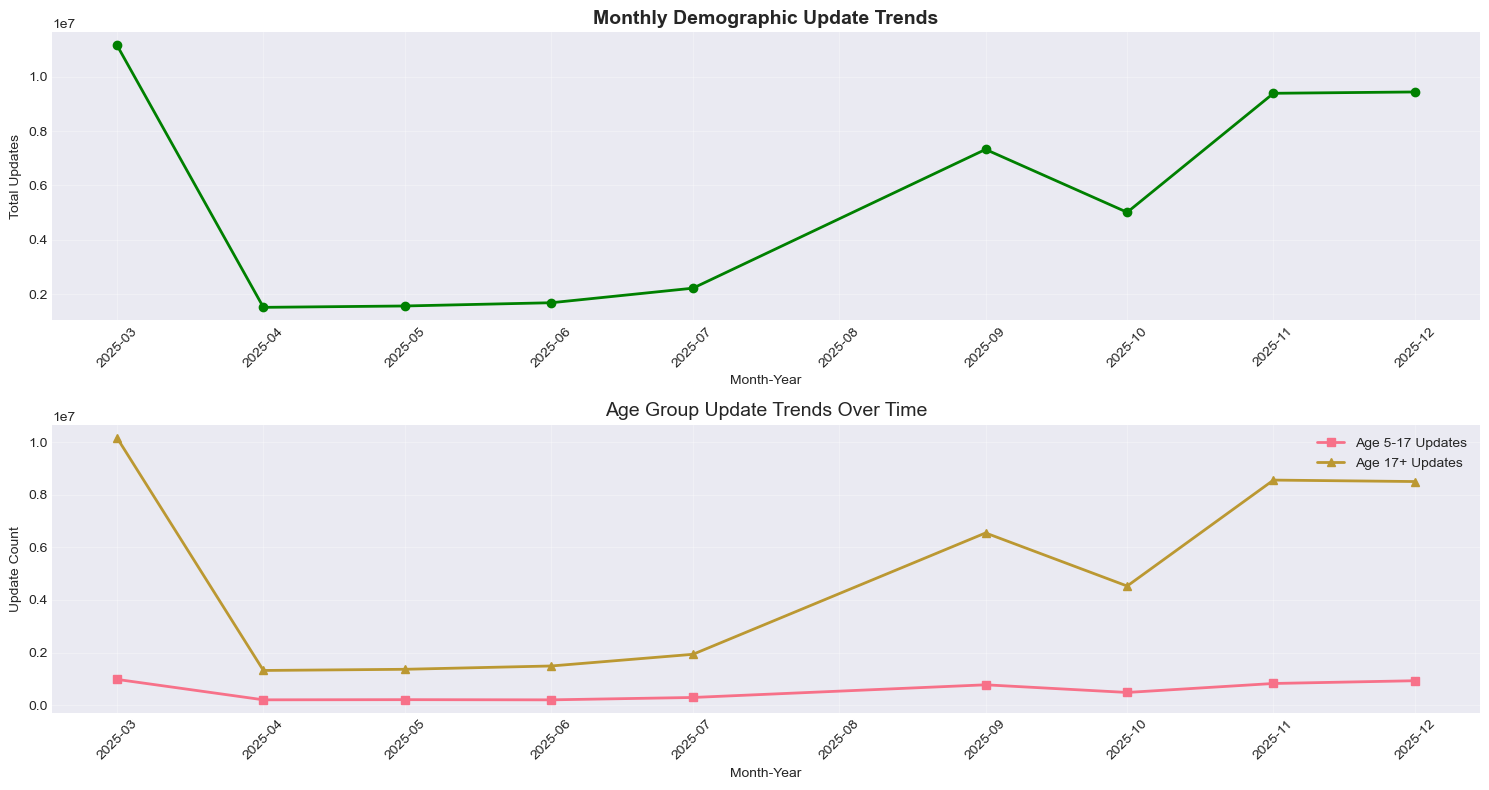

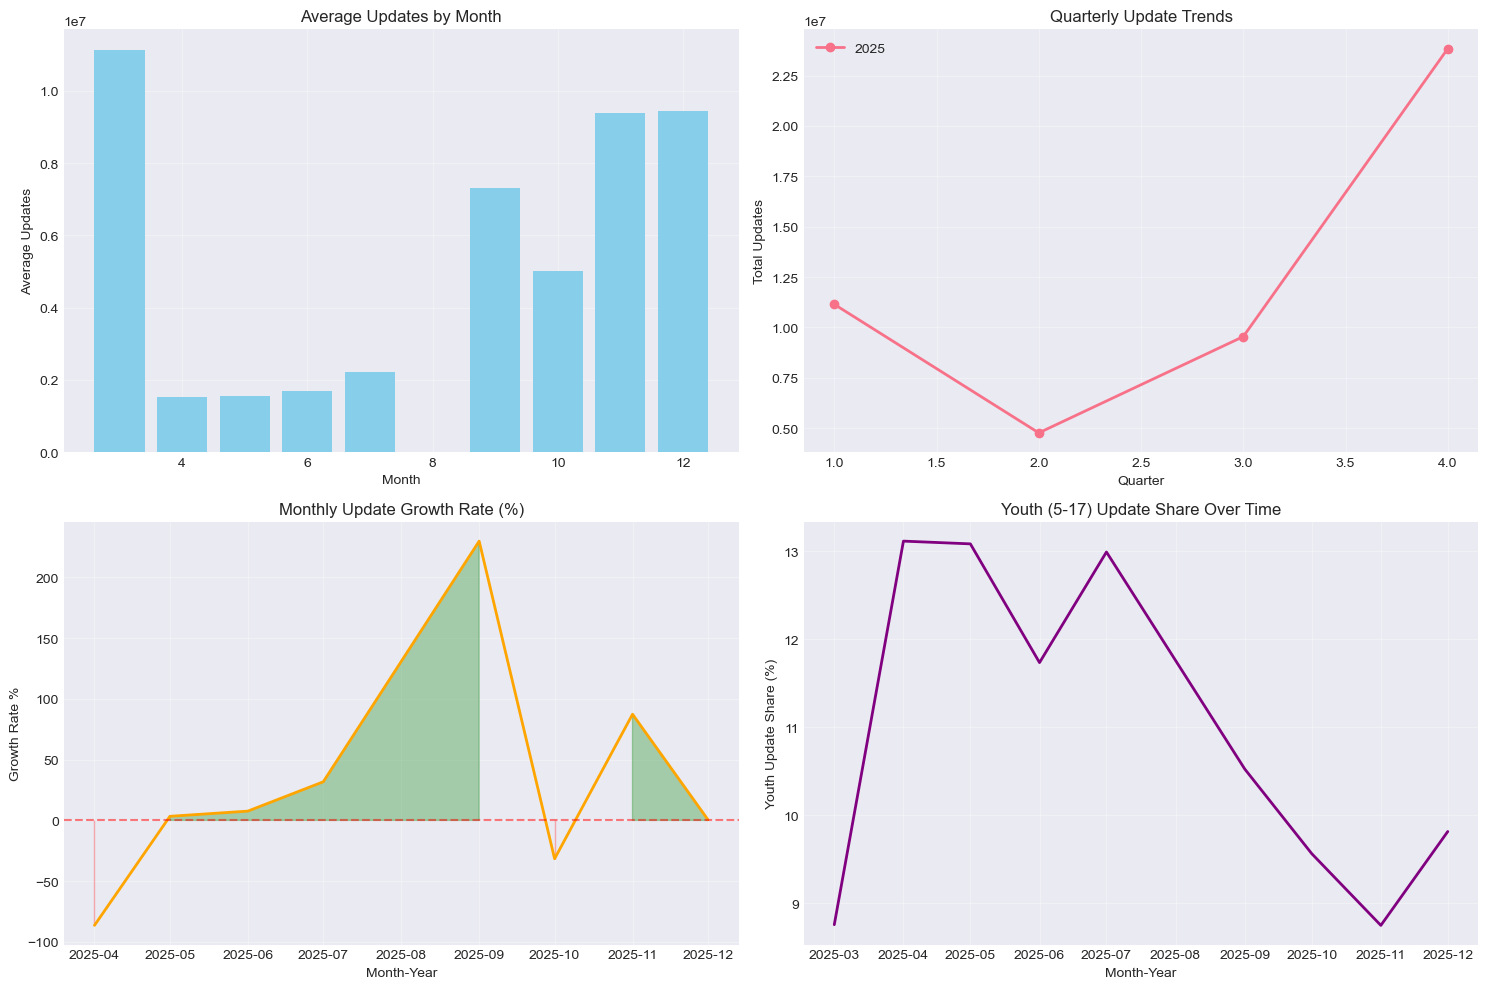

In [22]:
# Monthly trend analysis for demographic updates
monthly_demo_trend = df.groupby(['year', 'month']).agg({
    'total_updates': 'sum',
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum'
}).reset_index()

# Create month-year column for plotting
monthly_demo_trend['month_year'] = pd.to_datetime(
    monthly_demo_trend['year'].astype(str) + '-' + monthly_demo_trend['month'].astype(str) + '-01'
)

# Plot monthly trends
plt.figure(figsize=(15, 8))

# Plot 1: Total Updates
plt.subplot(2, 1, 1)
plt.plot(monthly_demo_trend['month_year'], monthly_demo_trend['total_updates'], 
         marker='o', linewidth=2, color='green')
plt.title('Monthly Demographic Update Trends', fontsize=14, fontweight='bold')
plt.xlabel('Month-Year')
plt.ylabel('Total Updates')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 2: Age Group Trends
plt.subplot(2, 1, 2)
plt.plot(monthly_demo_trend['month_year'], monthly_demo_trend['demo_age_5_17'], 
         label='Age 5-17 Updates', marker='s', linewidth=2)
plt.plot(monthly_demo_trend['month_year'], monthly_demo_trend['demo_age_17_'], 
         label='Age 17+ Updates', marker='^', linewidth=2)
plt.title('Age Group Update Trends Over Time', fontsize=14)
plt.xlabel('Month-Year')
plt.ylabel('Update Count')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate growth rates and seasonal patterns
monthly_demo_trend['update_growth_rate'] = monthly_demo_trend['total_updates'].pct_change() * 100
monthly_demo_trend['youth_update_share'] = (monthly_demo_trend['demo_age_5_17'] / 
                                           monthly_demo_trend['total_updates']) * 100

# Analyze seasonality
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Monthly distribution
# Compute average updates by month
monthly_avg = monthly_demo_trend.groupby('month')['total_updates'].mean()

# Use the actual month numbers from the data
months = monthly_avg.index

# Plot on the axes
axes[0, 0].bar(months, monthly_avg, color='skyblue')
axes[0, 0].set_title('Average Updates by Month')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Average Updates')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Quarterly trends
quarterly_trend = df.groupby(['year', 'quarter'])['total_updates'].sum().unstack().T
axes[0, 1].plot(quarterly_trend.index, quarterly_trend.values, marker='o', linewidth=2)
axes[0, 1].set_title('Quarterly Update Trends')
axes[0, 1].set_xlabel('Quarter')
axes[0, 1].set_ylabel('Total Updates')
axes[0, 1].legend(quarterly_trend.columns.tolist())
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Growth rate volatility
axes[1, 0].plot(monthly_demo_trend['month_year'], monthly_demo_trend['update_growth_rate'], 
                color='orange', linewidth=2)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].fill_between(monthly_demo_trend['month_year'], 
                        monthly_demo_trend['update_growth_rate'], 0,
                        where=(monthly_demo_trend['update_growth_rate'] > 0),
                        color='green', alpha=0.3)
axes[1, 0].fill_between(monthly_demo_trend['month_year'], 
                        monthly_demo_trend['update_growth_rate'], 0,
                        where=(monthly_demo_trend['update_growth_rate'] < 0),
                        color='red', alpha=0.3)
axes[1, 0].set_title('Monthly Update Growth Rate (%)')
axes[1, 0].set_xlabel('Month-Year')
axes[1, 0].set_ylabel('Growth Rate %')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Youth update share trend
axes[1, 1].plot(monthly_demo_trend['month_year'], monthly_demo_trend['youth_update_share'],
                color='purple', linewidth=2)
axes[1, 1].set_title('Youth (5-17) Update Share Over Time')
axes[1, 1].set_xlabel('Month-Year')
axes[1, 1].set_ylabel('Youth Update Share (%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 State-wise Analysis of Aadhaar Demographic Updates

In [24]:
print("Starting state-wise analysis of demographic updates...")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of unique states: {df['state'].nunique()}")
print(f"Number of unique districts: {df['district'].nunique()}")

# Define month names for better readability
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Starting state-wise analysis of demographic updates...
Date Range: 2025-03-01 00:00:00 to 2025-12-29 00:00:00
Number of unique states: 65
Number of unique districts: 983


#### 4.2.1 [ STATE-LEVEL SUMMARY STATISTICS ]

In [26]:
print("\n" + "="*100)
print("1. STATE-LEVEL SUMMARY STATISTICS")
print("="*100)

# Group by state for aggregated analysis
state_analysis = df.groupby('state').agg({
    'total_updates': ['sum', 'mean', 'std', 'count'],
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'pct_5_17': 'mean',
    'pct_17_plus': 'mean',
    'youth_update_ratio': 'mean',
    'date': 'nunique'  # Number of days with updates
}).round(2)

# Flatten multi-index columns
state_analysis.columns = ['_'.join(col).strip() for col in state_analysis.columns.values]
state_analysis = state_analysis.reset_index()

# Rename for clarity
state_analysis.rename(columns={
    'total_updates_sum': 'total_updates',
    'total_updates_mean': 'avg_daily_updates',
    'total_updates_std': 'std_daily_updates',
    'total_updates_count': 'records_count',
    'demo_age_5_17_sum': 'total_5_17',
    'demo_age_17__sum': 'total_17_plus',
    'pct_5_17_mean': 'avg_pct_5_17',
    'pct_17_plus_mean': 'avg_pct_17_plus',
    'youth_update_ratio_mean': 'avg_youth_update_ratio',
    'date_nunique': 'active_days'
}, inplace=True)

# Calculate additional metrics
state_analysis['updates_per_active_day'] = state_analysis['total_updates'] / state_analysis['active_days']
state_analysis['records_per_day'] = state_analysis['records_count'] / state_analysis['active_days']
state_analysis['consistency_score'] = 1 - (state_analysis['std_daily_updates'] / state_analysis['avg_daily_updates'])

# Handle NaN values in consistency score
state_analysis['consistency_score'] = state_analysis['consistency_score'].clip(lower=0)

print(f"\nTotal states analyzed: {len(state_analysis)}")
print(f"Total demographic updates: {state_analysis['total_updates'].sum():,}")


1. STATE-LEVEL SUMMARY STATISTICS

Total states analyzed: 65
Total demographic updates: 49,295,187


#### 4.2.2 [ TOP/BOTTOM PERFORMING STATES BY DEMOGRAPHIC UPDATES ]

In [29]:
print("\n" + "="*100)
print("2. TOP/BOTTOM PERFORMING STATES BY DEMOGRAPHIC UPDATES")
print("="*100)

print("\nTOP 10 STATES BY TOTAL DEMOGRAPHIC UPDATES:")
top_states = state_analysis.nlargest(10, 'total_updates')[['state', 'total_updates', 'avg_daily_updates', 'active_days']]
print(top_states.to_string(index=False))

print("\nBOTTOM 10 STATES BY TOTAL DEMOGRAPHIC UPDATES:")
bottom_states = state_analysis.nsmallest(10, 'total_updates')[['state', 'total_updates', 'avg_daily_updates', 'active_days']]
print(bottom_states.to_string(index=False))

print("\nTOP 10 STATES BY UPDATE INTENSITY (Updates per Active Day):")
intensity_states = state_analysis.nlargest(10, 'updates_per_active_day')[['state', 'updates_per_active_day', 'total_updates', 'active_days']]
print(intensity_states.to_string(index=False))


2. TOP/BOTTOM PERFORMING STATES BY DEMOGRAPHIC UPDATES

TOP 10 STATES BY TOTAL DEMOGRAPHIC UPDATES:
         state  total_updates  avg_daily_updates  active_days
 Uttar Pradesh        8542328              50.88           95
   Maharashtra        5054602              31.15           95
         Bihar        4814350              49.32           94
   West Bengal        3872172              22.96           95
Madhya Pradesh        2912938              38.15           95
     Rajasthan        2817615              31.48           95
Andhra Pradesh        2295505              11.05           95
    Tamil Nadu        2212228              11.24           95
  Chhattisgarh        2005434              56.13           95
       Gujarat        1824327              18.92           95

BOTTOM 10 STATES BY TOTAL DEMOGRAPHIC UPDATES:
               state  total_updates  avg_daily_updates  active_days
              Nagpur              1                1.0            1
        Puttenahalli             

#### 4.2.3 [ AGE GROUP ANALYSIS BY STATE ]

In [31]:
print("\n" + "="*100)
print("3. AGE GROUP ANALYSIS BY STATE")
print("="*100)

print("\nTOP 10 STATES WITH HIGHEST YOUTH (5-17) UPDATE PERCENTAGE:")
top_youth_states = state_analysis.nlargest(10, 'avg_pct_5_17')[['state', 'avg_pct_5_17', 'total_5_17', 'total_updates']]
print(top_youth_states.to_string(index=False))

print("\nTOP 10 STATES WITH HIGHEST ADULT (17+) UPDATE PERCENTAGE:")
top_adult_states = state_analysis.nlargest(10, 'avg_pct_17_plus')[['state', 'avg_pct_17_plus', 'total_17_plus', 'total_updates']]
print(top_adult_states.to_string(index=False))

print("\nSTATES WITH HIGHEST YOUTH-ADULT UPDATE RATIO (>1 indicates more youth updates):")
high_ratio_states = state_analysis[state_analysis['avg_youth_update_ratio'] > 1].nlargest(10, 'avg_youth_update_ratio')
print(high_ratio_states[['state', 'avg_youth_update_ratio', 'avg_pct_5_17', 'avg_pct_17_plus']].to_string(index=False))


3. AGE GROUP ANALYSIS BY STATE

TOP 10 STATES WITH HIGHEST YOUTH (5-17) UPDATE PERCENTAGE:
                 state  avg_pct_5_17  total_5_17  total_updates
Dadra and Nagar Haveli         24.19        1310           6033
                Ladakh         19.92        1375           5735
               Manipur         18.57       41464         301549
     Arunachal Pradesh         18.07        5783          36443
            Puducherry         17.57        4089          25304
            Tamil Nadu         16.52      315638        2212228
             Telangana         15.84      242259        1629908
           Lakshadweep         15.65         170           1176
         Daman and Diu         15.37         234           1552
        Andhra Pradesh         15.26      321143        2295505

TOP 10 STATES WITH HIGHEST ADULT (17+) UPDATE PERCENTAGE:
               state  avg_pct_17_plus  total_17_plus  total_updates
              100000            100.0              2              2
         

#### 4.2.4 [ UPDATE CONSISTENCY AND ACTIVITY ANALYSIS ]

In [315]:
print("\n" + "="*100)
print("4. UPDATE CONSISTENCY AND ACTIVITY ANALYSIS")
print("="*100)

print("\nMOST CONSISTENT STATES (Lowest Daily Variability):")
consistent_states = state_analysis[state_analysis['records_count'] > 10].nsmallest(10, 'std_daily_updates')
print(consistent_states[['state', 'avg_daily_updates', 'std_daily_updates', 'consistency_score']].to_string(index=False))

print("\nSTATES WITH HIGHEST ACTIVITY DENSITY (Records per Day):")
active_states = state_analysis.nlargest(10, 'records_per_day')[['state', 'records_per_day', 'records_count', 'active_days']]
print(active_states.to_string(index=False))

# Calculate coverage days percentage
total_days_in_period = df['date'].nunique()
state_analysis['coverage_percentage'] = (state_analysis['active_days'] / total_days_in_period) * 100

print("\nSTATES WITH HIGHEST UPDATE COVERAGE (% of Days with Updates):")
coverage_states = state_analysis.nlargest(10, 'coverage_percentage')[['state', 'coverage_percentage', 'active_days', 'total_updates']]
print(coverage_states.to_string(index=False))


4. UPDATE CONSISTENCY AND ACTIVITY ANALYSIS

MOST CONSISTENT STATES (Lowest Daily Variability):
          state  avg_daily_updates  std_daily_updates  consistency_score
     WESTBENGAL               1.16               0.37           0.681034
         odisha               1.18               0.39           0.669492
     Westbengal               1.14               0.42           0.631579
         ODISHA               1.32               0.47           0.643939
    West Bangal               1.24               0.50           0.596774
    west Bengal               1.36               0.50           0.632353
Jammu & Kashmir               1.17               0.53           0.547009
 andhra pradesh               1.45               0.64           0.558621
   West  Bengal               1.32               0.69           0.477273
    WEST BENGAL               1.31               0.82           0.374046

STATES WITH HIGHEST ACTIVITY DENSITY (Records per Day):
         state  records_per_day  records_co

#### 4.2.5 [ TEMPORAL PATTERNS BY STATE ]

In [318]:
print("\n" + "="*100)
print("5. TEMPORAL PATTERNS BY STATE")
print("="*100)

# Yearly updates by state
yearly_state = df.groupby(['state', 'year']).agg({
    'total_updates': 'sum',
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum'
}).reset_index()

# Calculate yearly growth rates
yearly_state = yearly_state.sort_values(['state', 'year'])
yearly_state['prev_year_updates'] = yearly_state.groupby('state')['total_updates'].shift(1)
yearly_state['yoy_growth'] = np.where(
    yearly_state['prev_year_updates'] > 0,
    ((yearly_state['total_updates'] - yearly_state['prev_year_updates']) / 
     yearly_state['prev_year_updates']) * 100,
    np.nan
)

print("\nSTATES WITH HIGHEST YEAR-OVER-YEAR GROWTH (Latest Year):")
latest_year = yearly_state['year'].max()
latest_year_data = yearly_state[yearly_state['year'] == latest_year].copy()
valid_growth_data = latest_year_data[latest_year_data['yoy_growth'].notna()]

if not valid_growth_data.empty:
    top_growth_states = valid_growth_data.nlargest(10, 'yoy_growth')[['state', 'total_updates', 'yoy_growth']]
    print(top_growth_states.to_string(index=False))
else:
    print("No valid YoY growth data available")

# Monthly pattern analysis by state
monthly_state = df.groupby(['state', 'month']).agg({
    'total_updates': 'sum'
}).reset_index()

# Find peak month for each state
peak_month_by_state = monthly_state.loc[monthly_state.groupby('state')['total_updates'].idxmax()]
peak_month_by_state['month_name'] = peak_month_by_state['month'].apply(lambda x: month_names[x-1])

print("\nSTATES AND THEIR PEAK UPDATE MONTHS (Top 10 by Total Updates):")
top_states_peak = peak_month_by_state[peak_month_by_state['state'].isin(top_states['state'].head(10))]
print(top_states_peak[['state', 'month_name', 'total_updates']].to_string(index=False))


5. TEMPORAL PATTERNS BY STATE

STATES WITH HIGHEST YEAR-OVER-YEAR GROWTH (Latest Year):
No valid YoY growth data available

STATES AND THEIR PEAK UPDATE MONTHS (Top 10 by Total Updates):
         state month_name  total_updates
Andhra Pradesh        Mar         513040
         Bihar        Sep        1218096
  Chhattisgarh        Dec         392613
       Gujarat        Mar         454378
Madhya Pradesh        Mar         663952
   Maharashtra        Nov        1926129
     Rajasthan        Mar        1159753
    Tamil Nadu        Mar         513763
 Uttar Pradesh        Mar        2199725
   West Bengal        Nov         891790


#### 4.2.6 [ PERFORMANCE CLUSTERING AND CATEGORIZATION ]

In [320]:
print("\n" + "="*100)
print("6. PERFORMANCE CLUSTERING AND CATEGORIZATION")
print("="*100)

# Create performance score based on multiple metrics
state_analysis['performance_score'] = (
    (state_analysis['total_updates'] / state_analysis['total_updates'].max()) * 0.25 +
    (state_analysis['updates_per_active_day'] / state_analysis['updates_per_active_day'].max()) * 0.25 +
    state_analysis['consistency_score'] * 0.25 +
    (state_analysis['coverage_percentage'] / 100) * 0.25
)

# Categorize states into performance tiers
state_analysis['performance_tier'] = pd.qcut(state_analysis['performance_score'], 
                                            q=5, 
                                            labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

print("\nPERFORMANCE TIER DISTRIBUTION:")
tier_distribution = state_analysis['performance_tier'].value_counts().sort_index()
for tier, count in tier_distribution.items():
    percentage = (count / len(state_analysis)) * 100
    print(f"  {tier}: {count} states ({percentage:.1f}%)")

# Display states in each tier
print("\nSTATES BY PERFORMANCE TIER:")
for tier in ['Very High', 'High', 'Medium', 'Low', 'Very Low']:
    states_in_tier = state_analysis[state_analysis['performance_tier'] == tier]['state'].tolist()
    if states_in_tier:
        print(f"\n{tier} Performance ({len(states_in_tier)} states):")
        print(f"  {', '.join(states_in_tier[:10])}{'...' if len(states_in_tier) > 10 else ''}")


6. PERFORMANCE CLUSTERING AND CATEGORIZATION

PERFORMANCE TIER DISTRIBUTION:
  Very Low: 13 states (20.0%)
  Low: 14 states (21.5%)
  Medium: 10 states (15.4%)
  High: 12 states (18.5%)
  Very High: 13 states (20.0%)

STATES BY PERFORMANCE TIER:

Very High Performance (13 states):
  Andhra Pradesh, Bihar, Chhattisgarh, Gujarat, Jammu & Kashmir, Karnataka, Madhya Pradesh, Maharashtra, Rajasthan, Tamil Nadu...

High Performance (12 states):
  Andaman & Nicobar Islands, Assam, Delhi, Haryana, Jharkhand, Kerala, Lakshadweep, Odisha, Pondicherry, Punjab...

Medium Performance (10 states):
  100000, Chandigarh, Chhatisgarh, Himachal Pradesh, Jammu and Kashmir, Manipur, Orissa, Uttaranchal, West Bengli, Westbengal

Low Performance (14 states):
  Arunachal Pradesh, BALANAGAR, Dadra & Nagar Haveli, Darbhanga, Goa, Jaipur, Madanapalle, Meghalaya, Mizoram, Nagaland...

Very Low Performance (13 states):
  Andaman and Nicobar Islands, Dadra and Nagar Haveli, Dadra and Nagar Haveli and Daman and Di

#### 4.2.7 [ GEOGRAPHIC CONCENTRATION ANALYSIS ] 

In [324]:
print("\n" + "="*100)
print("7. GEOGRAPHIC CONCENTRATION ANALYSIS")
print("="*100)

# Calculate concentration metrics
total_national_updates = state_analysis['total_updates'].sum()
state_analysis['national_share'] = (state_analysis['total_updates'] / total_national_updates) * 100

# Sort by national share for cumulative calculation
state_analysis_sorted = state_analysis.sort_values('national_share', ascending=False).reset_index(drop=True)
state_analysis_sorted['cumulative_share'] = state_analysis_sorted['national_share'].cumsum()

# Find states that make up 80% of updates
states_80_percent = state_analysis_sorted[state_analysis_sorted['cumulative_share'] <= 80]
states_50_percent = state_analysis_sorted[state_analysis_sorted['cumulative_share'] <= 50]

print(f"\nGEOGRAPHIC CONCENTRATION OF DEMOGRAPHIC UPDATES:")
print(f"- Top {len(states_50_percent)} states account for 50% of all updates")
print(f"- Top {len(states_80_percent)} states account for 80% of all updates")
print(f"- Top state: {state_analysis_sorted.iloc[0]['state']} ({state_analysis_sorted.iloc[0]['national_share']:.1f}% of total)")

# Calculate HHI index for concentration
state_shares = state_analysis_sorted['national_share']
hhi = (state_shares ** 2).sum()
print(f"- HHI Index: {hhi:.2f}")
if hhi < 1500:
    print("  (Market: Unconcentrated)")
elif hhi < 2500:
    print("  (Market: Moderately concentrated)")
else:
    print("  (Market: Highly concentrated)")


7. GEOGRAPHIC CONCENTRATION ANALYSIS

GEOGRAPHIC CONCENTRATION OF DEMOGRAPHIC UPDATES:
- Top 4 states account for 50% of all updates
- Top 11 states account for 80% of all updates
- Top state: Uttar Pradesh (17.3% of total)
- HHI Index: 763.86
  (Market: Unconcentrated)


#### 4.2.8 [ CORRELATION ANALYSIS BETWEEN METRICS ]

In [327]:
print("\n" + "="*100)
print("8. CORRELATION ANALYSIS BETWEEN METRICS")
print("="*100)

# Calculate correlations between key metrics
correlation_metrics = ['total_updates', 'avg_daily_updates', 'std_daily_updates',
                      'avg_pct_5_17', 'avg_pct_17_plus', 'avg_youth_update_ratio',
                      'updates_per_active_day', 'consistency_score', 'coverage_percentage']

corr_matrix = state_analysis[correlation_metrics].corr()

print("\nKey Correlations (>0.5 or <-0.5):")
strong_correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.5 and not pd.isna(corr_value):
            strong_correlations.append({
                'var1': corr_matrix.columns[i],
                'var2': corr_matrix.columns[j],
                'correlation': corr_value
            })

if strong_correlations:
    strong_correlations_df = pd.DataFrame(strong_correlations).sort_values('correlation', ascending=False)
    print(strong_correlations_df.to_string(index=False))
else:
    print("No strong correlations found (>0.5 or <-0.5)")


8. CORRELATION ANALYSIS BETWEEN METRICS

Key Correlations (>0.5 or <-0.5):
                  var1                   var2  correlation
         total_updates updates_per_active_day     0.999982
          avg_pct_5_17 avg_youth_update_ratio     0.986130
     avg_daily_updates      std_daily_updates     0.975353
          avg_pct_5_17    coverage_percentage     0.780827
       avg_pct_17_plus      consistency_score     0.759454
avg_youth_update_ratio    coverage_percentage     0.717988
     avg_daily_updates updates_per_active_day     0.515000
         total_updates      avg_daily_updates     0.514584
avg_youth_update_ratio      consistency_score    -0.700452
          avg_pct_5_17      consistency_score    -0.759454
       avg_pct_17_plus    coverage_percentage    -0.780827
     consistency_score    coverage_percentage    -0.959685
       avg_pct_17_plus avg_youth_update_ratio    -0.986130
          avg_pct_5_17        avg_pct_17_plus    -1.000000


#### 4.2.9 [ VISUALIZATIONS ] 

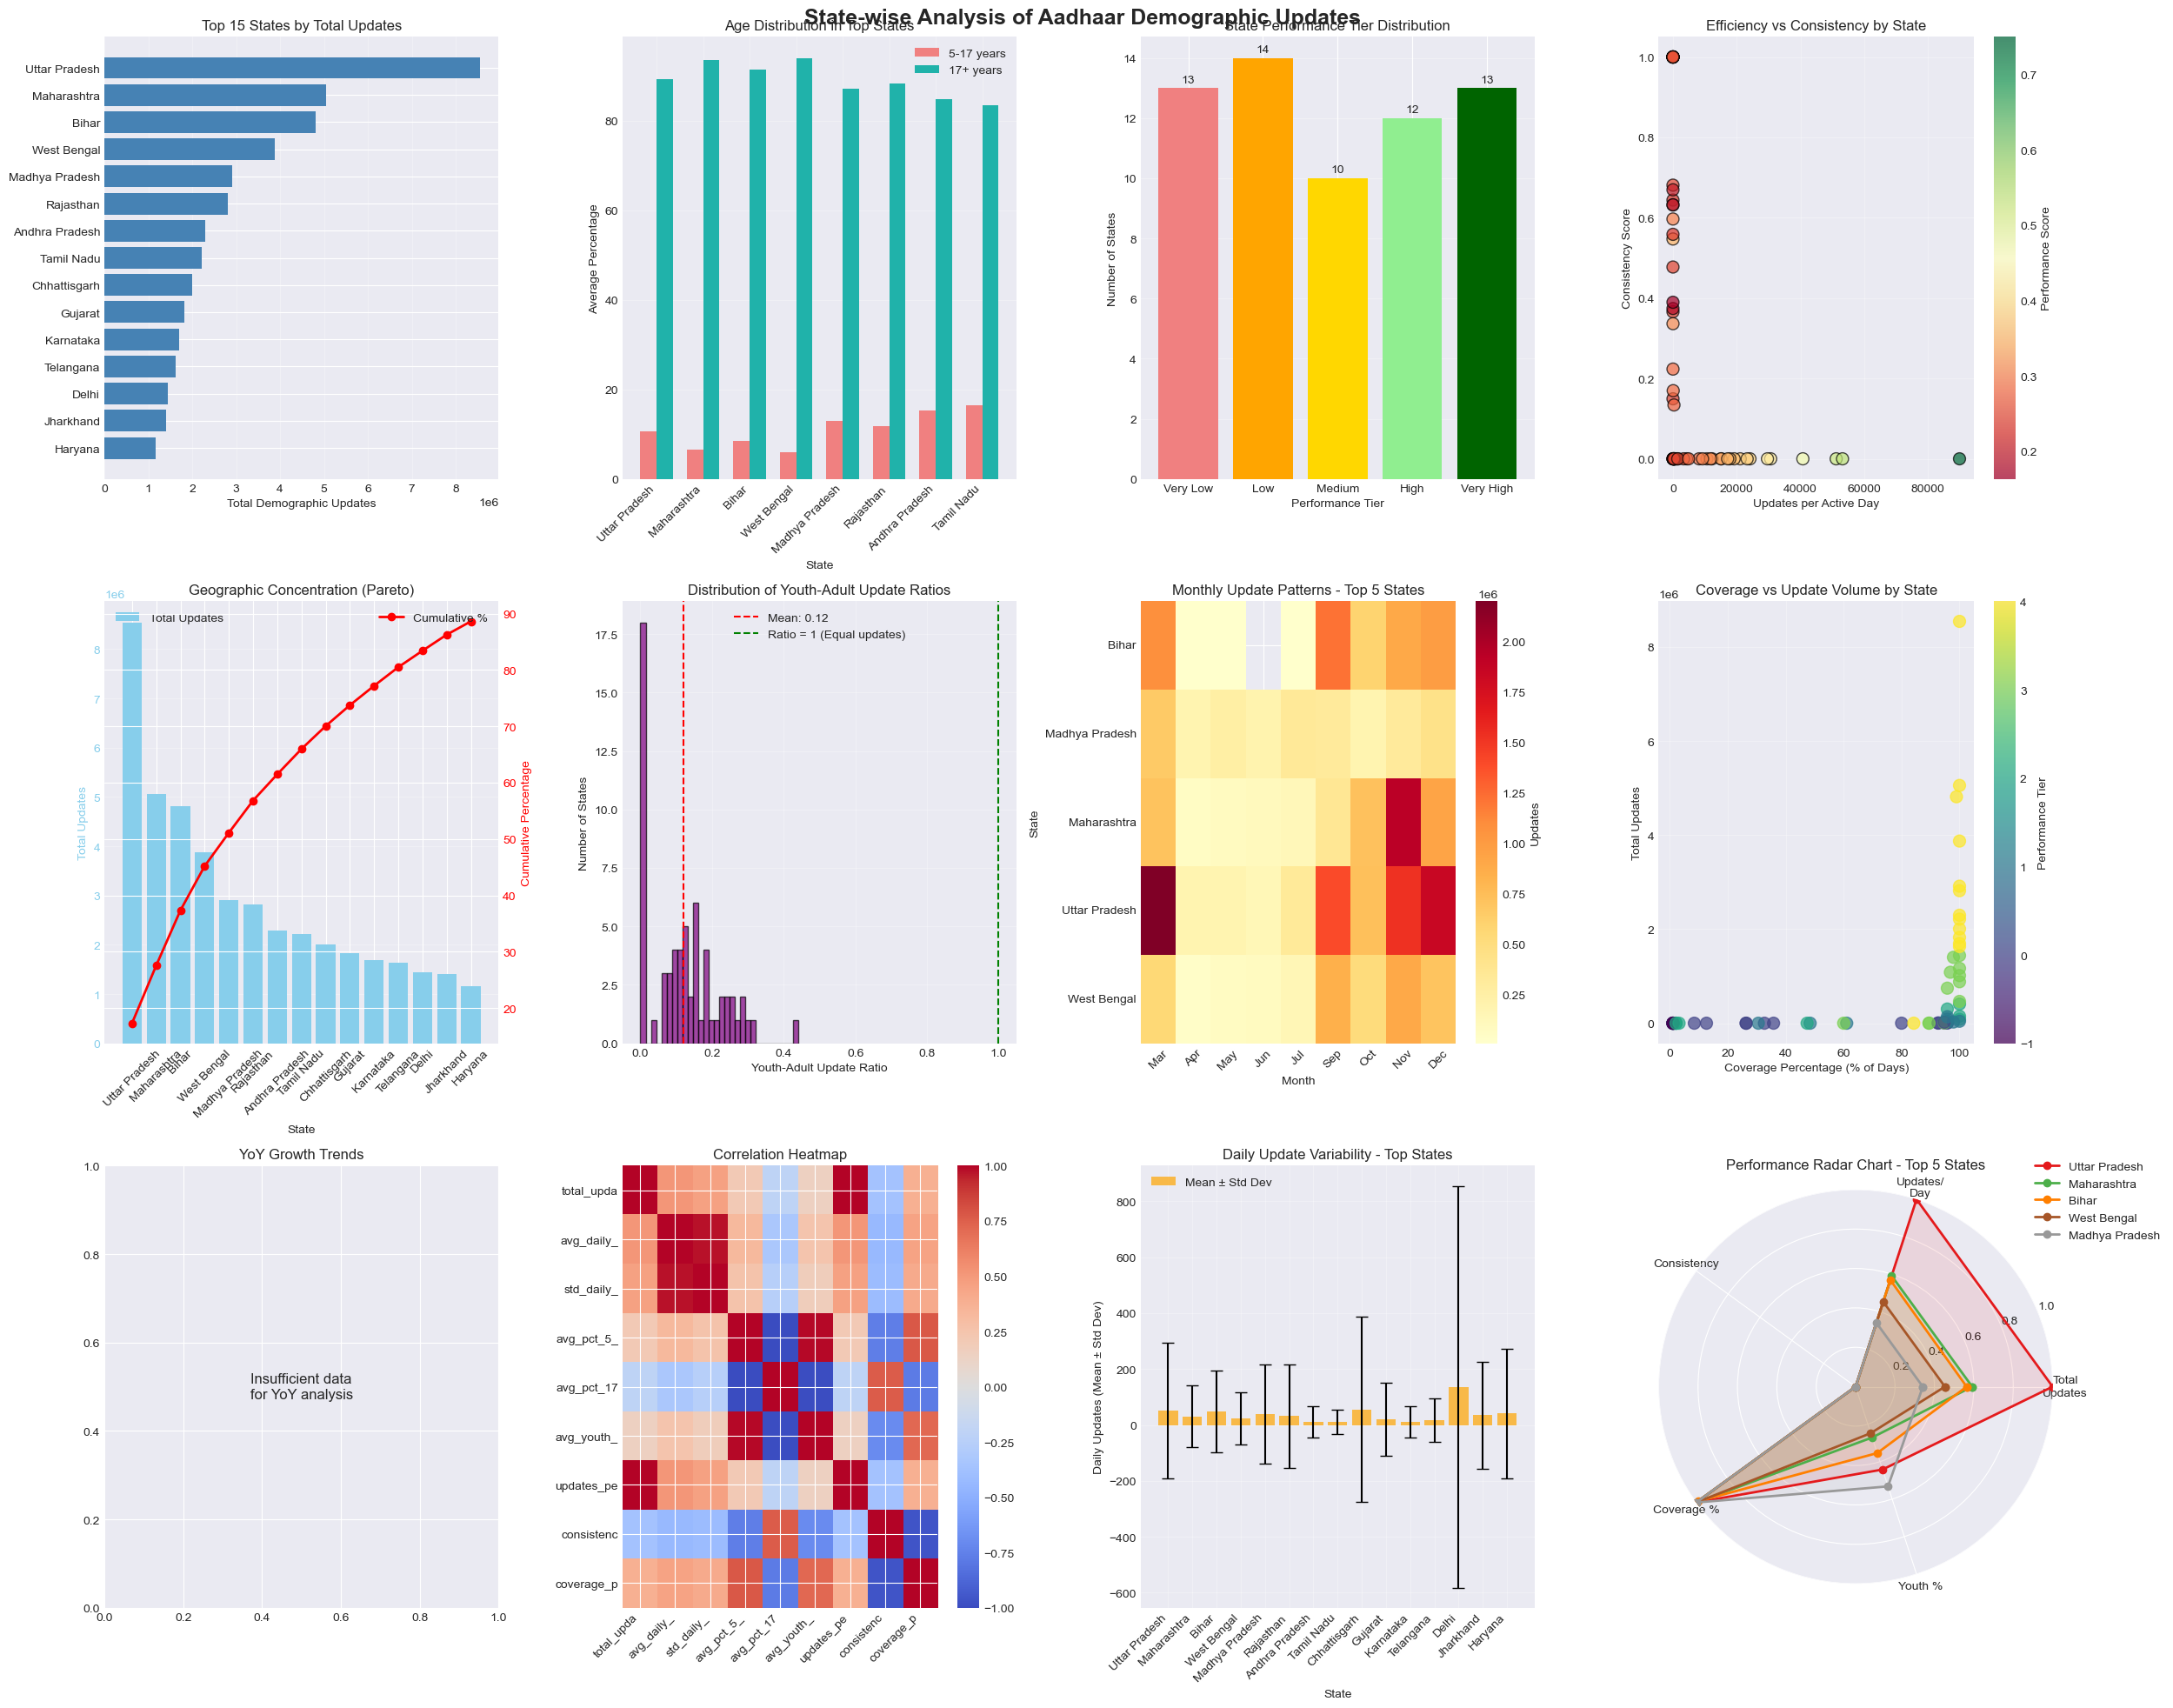

In [330]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(25, 20))
fig.suptitle('State-wise Analysis of Aadhaar Demographic Updates', fontsize=18, fontweight='bold')

# Plot 1: Top 15 states by total updates
ax1 = plt.subplot(3, 4, 1)
top_15 = state_analysis.nlargest(15, 'total_updates')
ax1.barh(range(len(top_15)), top_15['total_updates'], color='steelblue')
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['state'])
ax1.set_xlabel('Total Demographic Updates')
ax1.set_title('Top 15 States by Total Updates')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Age distribution comparison
ax2 = plt.subplot(3, 4, 2)
sample_states = state_analysis.nlargest(8, 'total_updates')
x = np.arange(len(sample_states))
width = 0.35
bars1 = ax2.bar(x - width/2, sample_states['avg_pct_5_17'], width, label='5-17 years', color='lightcoral')
bars2 = ax2.bar(x + width/2, sample_states['avg_pct_17_plus'], width, label='17+ years', color='lightseagreen')
ax2.set_xlabel('State')
ax2.set_ylabel('Average Percentage')
ax2.set_title('Age Distribution in Top States')
ax2.set_xticks(x)
ax2.set_xticklabels(sample_states['state'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Performance tiers distribution
ax3 = plt.subplot(3, 4, 3)
tier_counts = state_analysis['performance_tier'].value_counts().sort_index()
colors = ['lightcoral', 'orange', 'gold', 'lightgreen', 'darkgreen']
bars = ax3.bar(tier_counts.index, tier_counts.values, color=colors)
ax3.set_xlabel('Performance Tier')
ax3.set_ylabel('Number of States')
ax3.set_title('State Performance Tier Distribution')
for bar, count in zip(bars, tier_counts.values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            str(count), ha='center', va='bottom')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Updates per active day vs consistency
ax4 = plt.subplot(3, 4, 4)
scatter = ax4.scatter(state_analysis['updates_per_active_day'], 
                     state_analysis['consistency_score'],
                     c=state_analysis['performance_score'], 
                     cmap='RdYlGn', s=100, alpha=0.7, edgecolors='black')
ax4.set_xlabel('Updates per Active Day')
ax4.set_ylabel('Consistency Score')
ax4.set_title('Efficiency vs Consistency by State')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Performance Score')

# Plot 5: Geographic concentration (Pareto chart)
ax5 = plt.subplot(3, 4, 5)
states_plot = state_analysis_sorted.head(15)
x = np.arange(len(states_plot))
ax5.bar(x, states_plot['total_updates'], color='skyblue', label='Total Updates')
ax5.set_xlabel('State')
ax5.set_ylabel('Total Updates', color='skyblue')
ax5.set_title('Geographic Concentration (Pareto)')
ax5.set_xticks(x)
ax5.set_xticklabels(states_plot['state'], rotation=45)
ax5.tick_params(axis='y', labelcolor='skyblue')
ax5.grid(True, alpha=0.3, axis='y')

ax5_2 = ax5.twinx()
ax5_2.plot(x, states_plot['cumulative_share'], 
          color='red', marker='o', linewidth=2, label='Cumulative %')
ax5_2.set_ylabel('Cumulative Percentage', color='red')
ax5_2.tick_params(axis='y', labelcolor='red')
ax5.legend(loc='upper left')
ax5_2.legend(loc='upper right')

# Plot 6: Youth-Adult update ratio distribution
ax6 = plt.subplot(3, 4, 6)
valid_ratios = state_analysis['avg_youth_update_ratio'].dropna()
ax6.hist(valid_ratios, bins=30, color='purple', alpha=0.7, edgecolor='black')
ax6.axvline(valid_ratios.mean(), color='red', linestyle='--', 
           label=f'Mean: {valid_ratios.mean():.2f}')
ax6.axvline(1, color='green', linestyle='--', label='Ratio = 1 (Equal updates)')
ax6.set_xlabel('Youth-Adult Update Ratio')
ax6.set_ylabel('Number of States')
ax6.set_title('Distribution of Youth-Adult Update Ratios')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Plot 7: Monthly update patterns for top 5 states
ax7 = plt.subplot(3, 4, 7)
top_5_states = state_analysis.nlargest(5, 'total_updates')['state'].tolist()
monthly_top5 = monthly_state[monthly_state['state'].isin(top_5_states)]
heatmap_pivot = monthly_top5.pivot(index='state', columns='month', values='total_updates')

# Get the actual months present in the data
months_present = sorted(heatmap_pivot.columns.tolist())
month_labels = [month_names[m-1] for m in months_present]

sns.heatmap(heatmap_pivot, cmap='YlOrRd', ax=ax7, cbar_kws={'label': 'Updates'})
ax7.set_xlabel('Month')
ax7.set_ylabel('State')
ax7.set_title('Monthly Update Patterns - Top 5 States')

# Set x-tick labels only for months present in data
ax7.set_xticks(np.arange(len(months_present)) + 0.5)
ax7.set_xticklabels(month_labels, rotation=45)

# Plot 8: Coverage percentage vs total updates
ax8 = plt.subplot(3, 4, 8)
scatter2 = ax8.scatter(state_analysis['coverage_percentage'], 
                      state_analysis['total_updates'],
                      c=state_analysis['performance_tier'].cat.codes, 
                      cmap='viridis', s=100, alpha=0.7)
ax8.set_xlabel('Coverage Percentage (% of Days)')
ax8.set_ylabel('Total Updates')
ax8.set_title('Coverage vs Update Volume by State')
ax8.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax8, label='Performance Tier')

# Plot 9: YoY growth for top states
ax9 = plt.subplot(3, 4, 9)
if not valid_growth_data.empty:
    top_growth = valid_growth_data.nlargest(5, 'yoy_growth')['state'].tolist()
    growth_plot_data = yearly_state[yearly_state['state'].isin(top_growth)]
    for state in top_growth:
        state_data = growth_plot_data[growth_plot_data['state'] == state]
        ax9.plot(state_data['year'], state_data['total_updates'], marker='o', label=state)
    ax9.set_xlabel('Year')
    ax9.set_ylabel('Total Updates')
    ax9.set_title('YoY Growth Trends - Top Growing States')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
else:
    ax9.text(0.5, 0.5, 'Insufficient data\nfor YoY analysis', 
             ha='center', va='center', transform=ax9.transAxes, fontsize=12)
    ax9.set_title('YoY Growth Trends')

# Plot 10: Correlation heatmap
ax10 = plt.subplot(3, 4, 10)
corr_plot = ax10.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax10.set_xticks(range(len(corr_matrix.columns)))
ax10.set_yticks(range(len(corr_matrix.columns)))
ax10.set_xticklabels([col[:10] for col in corr_matrix.columns], rotation=45, ha='right')
ax10.set_yticklabels([col[:10] for col in corr_matrix.columns])
ax10.set_title('Correlation Heatmap')
plt.colorbar(corr_plot, ax=ax10)

# Plot 11: Daily update variability
ax11 = plt.subplot(3, 4, 11)
variability_data = state_analysis.nlargest(15, 'total_updates')
x = np.arange(len(variability_data))
ax11.bar(x, variability_data['avg_daily_updates'], 
        yerr=variability_data['std_daily_updates'], 
        capsize=5, color='orange', alpha=0.7, 
        label='Mean ± Std Dev')
ax11.set_xlabel('State')
ax11.set_ylabel('Daily Updates (Mean ± Std Dev)')
ax11.set_title('Daily Update Variability - Top States')
ax11.set_xticks(x)
ax11.set_xticklabels(variability_data['state'], rotation=45, ha='right')
ax11.legend()
ax11.grid(True, alpha=0.3)

# Plot 12: Performance metrics radar chart for top 5 states
ax12 = plt.subplot(3, 4, 12, polar=True)
top_5_performance = state_analysis.nlargest(5, 'performance_score')
metrics = ['total_updates', 'updates_per_active_day', 'consistency_score', 
           'coverage_percentage', 'avg_pct_5_17']
metric_labels = ['Total\nUpdates', 'Updates/\nDay', 'Consistency', 
                'Coverage %', 'Youth %']

# Check if we have enough states for radar chart
if len(top_5_performance) >= 3:
    # Normalize metrics for radar chart
    normalized_data = []
    for metric in metrics:
        min_val = state_analysis[metric].min()
        max_val = state_analysis[metric].max()
        if max_val > min_val:  # Avoid division by zero
            normalized = (top_5_performance[metric] - min_val) / (max_val - min_val)
            normalized_data.append(normalized.values)
        else:
            normalized_data.append(np.zeros(len(top_5_performance)))
    
    # Create angles for radar chart
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the polygon
    
    # Plot each state
    colors = plt.cm.Set1(np.linspace(0, 1, len(top_5_performance)))
    for i, (idx, row) in enumerate(top_5_performance.iterrows()):
        values = [normalized_data[j][i] for j in range(len(metrics))]
        values += values[:1]  # Close the polygon
        ax12.plot(angles, values, 'o-', linewidth=2, label=row['state'], color=colors[i])
        ax12.fill(angles, values, alpha=0.1, color=colors[i])
    
    ax12.set_xticks(angles[:-1])
    ax12.set_xticklabels(metric_labels)
    ax12.set_ylim(0, 1)
    ax12.set_title('Performance Radar Chart - Top 5 States')
    ax12.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
else:
    ax12.text(0.5, 0.5, 'Insufficient data\nfor radar chart', 
             ha='center', va='center', transform=ax12.transAxes, fontsize=12)
    ax12.set_title('Performance Radar Chart')

plt.tight_layout()
plt.show()

#### 4.2.10 [ KEY INSIGHTS SUMMARY ]

In [332]:
print("\n" + "="*100)
print("10. KEY INSIGHTS SUMMARY")
print("="*100)

# Insight 1: Overall statistics
print(f"\n1. OVERALL STATISTICS:")
print(f"   - Total demographic updates: {total_national_updates:,}")
print(f"   - States covered: {len(state_analysis)}")
print(f"   - Average updates per state: {state_analysis['total_updates'].mean():,.0f}")

# Insight 2: Top performers
top_state_info = state_analysis.nlargest(1, 'total_updates').iloc[0]
print(f"\n2. TOP PERFORMING STATE:")
print(f"   - {top_state_info['state']}: {top_state_info['total_updates']:,} updates")
print(f"   - Share of national total: {top_state_info['national_share']:.1f}%")
print(f"   - Performance tier: {top_state_info['performance_tier']}")

# Insight 3: Age group patterns
print(f"\n3. AGE GROUP PATTERNS:")
print(f"   - Average youth (5-17) update percentage: {state_analysis['avg_pct_5_17'].mean():.1f}%")
print(f"   - Average adult (17+) update percentage: {state_analysis['avg_pct_17_plus'].mean():.1f}%")
print(f"   - States with more youth than adult updates: {len(state_analysis[state_analysis['avg_youth_update_ratio'] > 1])}")

# Insight 4: Geographic concentration
print(f"\n4. GEOGRAPHIC CONCENTRATION:")
print(f"   - Top {len(states_50_percent)} states account for 50% of updates")
print(f"   - Top {len(states_80_percent)} states account for 80% of updates")
print(f"   - Concentration level: {'High' if hhi >= 2500 else 'Moderate' if hhi >= 1500 else 'Low'}")

# Insight 5: Performance distribution
print(f"\n5. PERFORMANCE DISTRIBUTION:")
very_high_count = len(state_analysis[state_analysis['performance_tier'] == 'Very High'])
high_count = len(state_analysis[state_analysis['performance_tier'] == 'High'])
print(f"   - High/Very High performing states: {very_high_count + high_count} ({((very_high_count + high_count)/len(state_analysis)*100):.1f}%)")
print(f"   - Low/Very Low performing states: {len(state_analysis[state_analysis['performance_tier'].isin(['Low', 'Very Low'])])}")

# Insight 6: Consistency and coverage
print(f"\n6. CONSISTENCY AND COVERAGE:")
print(f"   - Average coverage days: {state_analysis['coverage_percentage'].mean():.1f}% of total period")
if 'consistency_score' in state_analysis.columns and state_analysis['consistency_score'].notna().any():
    most_consistent = state_analysis.nlargest(1, 'consistency_score').iloc[0]
    print(f"   - Most consistent state: {most_consistent['state']}")
print(f"   - Best coverage state: {state_analysis.nlargest(1, 'coverage_percentage').iloc[0]['state']}")

# Insight 7: Growth patterns
if not valid_growth_data.empty and 'yoy_growth' in valid_growth_data.columns:
    positive_growth = valid_growth_data[valid_growth_data['yoy_growth'] > 0]
    if len(positive_growth) > 0:
        fastest_growth = positive_growth.nlargest(1, 'yoy_growth').iloc[0]
        print(f"\n7. GROWTH PATTERNS:")
        print(f"   - States with positive YoY growth: {len(positive_growth)}")
        print(f"   - Fastest growing state: {fastest_growth['state']} ({fastest_growth['yoy_growth']:.1f}% growth)")

# Insight 8: Recommendations
print(f"\n8. STRATEGIC RECOMMENDATIONS:")
print("   - Focus resources on top-performing states for maximum impact")
print("   - Study best practices from high-consistency states")
print("   - Address gaps in low-coverage states")
print("   - Tailor approaches based on age group patterns")
print("   - Monitor growth trends for emerging high-potential states")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)


10. KEY INSIGHTS SUMMARY

1. OVERALL STATISTICS:
   - Total demographic updates: 49,295,187
   - States covered: 65
   - Average updates per state: 758,387

2. TOP PERFORMING STATE:
   - Uttar Pradesh: 8,542,328 updates
   - Share of national total: 17.3%
   - Performance tier: Very High

3. AGE GROUP PATTERNS:
   - Average youth (5-17) update percentage: 8.0%
   - Average adult (17+) update percentage: 92.0%
   - States with more youth than adult updates: 0

4. GEOGRAPHIC CONCENTRATION:
   - Top 4 states account for 50% of updates
   - Top 11 states account for 80% of updates
   - Concentration level: Low

5. PERFORMANCE DISTRIBUTION:
   - High/Very High performing states: 25 (38.5%)
   - Low/Very Low performing states: 27

6. CONSISTENCY AND COVERAGE:
   - Average coverage days: 70.3% of total period
   - Most consistent state: 100000
   - Best coverage state: Andhra Pradesh

8. STRATEGIC RECOMMENDATIONS:
   - Focus resources on top-performing states for maximum impact
   - Study be

#### 4.2.11 [ STATE PERFORMANCE SUMMARY (Top 20) ] 

In [334]:
print("\n" + "="*100)
print("11. STATE PERFORMANCE SUMMARY (Top 20)")
print("="*100)

summary_columns = ['state', 'total_updates', 'national_share', 'performance_tier',
                  'avg_daily_updates', 'updates_per_active_day', 'coverage_percentage',
                  'avg_pct_5_17', 'avg_pct_17_plus', 'avg_youth_update_ratio']

summary_report = state_analysis[summary_columns].sort_values('total_updates', ascending=False)
print(summary_report.head(20).to_string(index=False))

# Export state categorization
print("\n" + "="*100)
print("STATE CATEGORIZATION FOR ACTION PLANNING")
print("="*100)

categorization = state_analysis[['state', 'performance_tier', 'total_updates', 
                                'national_share', 'coverage_percentage']].copy()
categorization['action_category'] = np.where(
    categorization['performance_tier'].isin(['Very High', 'High']),
    'Maintain & Optimize',
    np.where(
        categorization['performance_tier'] == 'Medium',
        'Improve & Scale',
        'Intervene & Support'
    )
)

print("\nAction Categories:")
action_counts = categorization['action_category'].value_counts()
for category, count in action_counts.items():
    print(f"  {category}: {count} states")

print("\nDetailed Categorization:")
print(categorization.sort_values(['action_category', 'total_updates'], ascending=[True, False]).to_string(index=False))


11. STATE PERFORMANCE SUMMARY (Top 20)
         state  total_updates  national_share performance_tier  avg_daily_updates  updates_per_active_day  coverage_percentage  avg_pct_5_17  avg_pct_17_plus  avg_youth_update_ratio
 Uttar Pradesh        8542328       17.328929        Very High              50.88            89919.242105           100.000000         10.69            89.31                    0.14
   Maharashtra        5054602       10.253743        Very High              31.15            53206.336842           100.000000          6.56            93.44                    0.09
         Bihar        4814350        9.766369        Very High              49.32            51216.489362            98.947368          8.57            91.43                    0.11
   West Bengal        3872172        7.855071        Very High              22.96            40759.705263           100.000000          6.00            94.00                    0.08
Madhya Pradesh        2912938        5.909173     

#### 4.2.12 [ ADDITIONAL ANALYSES ]

In [336]:
print("\n" + "="*100)
print("12. ADDITIONAL ANALYSES")
print("="*100)

# State comparison analysis
print("\nA. STATE COMPARISON ANALYSIS:")
print("Top 5 states by demographic updates:")
for i, row in state_analysis.nlargest(5, 'total_updates').iterrows():
    print(f"  {i+1}. {row['state']}: {row['total_updates']:,} updates "
          f"({row['national_share']:.1f}% of total)")

# Age group focus analysis
print("\nB. AGE GROUP FOCUS ANALYSIS:")
youth_focus = state_analysis[state_analysis['avg_pct_5_17'] > 50]
adult_focus = state_analysis[state_analysis['avg_pct_17_plus'] > 50]
balanced = state_analysis[(state_analysis['avg_pct_5_17'] <= 50) & (state_analysis['avg_pct_17_plus'] <= 50)]

print(f"  - Youth-focused states (>50% youth updates): {len(youth_focus)}")
print(f"  - Adult-focused states (>50% adult updates): {len(adult_focus)}")
print(f"  - Balanced states: {len(balanced)}")

# Update intensity analysis
print("\nC. UPDATE INTENSITY ANALYSIS:")
high_intensity = state_analysis[state_analysis['updates_per_active_day'] > state_analysis['updates_per_active_day'].quantile(0.75)]
print(f"  - High-intensity states (top 25%): {len(high_intensity)}")
if len(high_intensity) > 0:
    print("  Top 3 high-intensity states:")
    for i, row in high_intensity.nlargest(3, 'updates_per_active_day').iterrows():
        print(f"    - {row['state']}: {row['updates_per_active_day']:.1f} updates/day")

# Peak month analysis
print("\nD. PEAK MONTH ANALYSIS:")
if len(top_states_peak) > 0:
    month_counts = top_states_peak['month_name'].value_counts()
    print("  Most common peak months among top states:")
    for month, count in month_counts.head(3).items():
        print(f"    - {month}: {count} states")

print("\n" + "="*100)
print("ALL ANALYSES COMPLETED SUCCESSFULLY!")
print("="*100)


12. ADDITIONAL ANALYSES

A. STATE COMPARISON ANALYSIS:
Top 5 states by demographic updates:
  52. Uttar Pradesh: 8,542,328 updates (17.3% of total)
  33. Maharashtra: 5,054,602 updates (10.3% of total)
  8. Bihar: 4,814,350 updates (9.8% of total)
  59. West Bengal: 3,872,172 updates (7.9% of total)
  32. Madhya Pradesh: 2,912,938 updates (5.9% of total)

B. AGE GROUP FOCUS ANALYSIS:
  - Youth-focused states (>50% youth updates): 0
  - Adult-focused states (>50% adult updates): 65
  - Balanced states: 0

C. UPDATE INTENSITY ANALYSIS:
  - High-intensity states (top 25%): 16
  Top 3 high-intensity states:
    - Uttar Pradesh: 89919.2 updates/day
    - Maharashtra: 53206.3 updates/day
    - Bihar: 51216.5 updates/day

D. PEAK MONTH ANALYSIS:
  Most common peak months among top states:
    - Mar: 6 states
    - Nov: 2 states
    - Sep: 1 states

ALL ANALYSES COMPLETED SUCCESSFULLY!


#### 4.2.13 [ FINAL SUMMARY REPORT ]

In [338]:
print("\n" + "="*100)
print("FINAL SUMMARY REPORT")
print("="*100)

# Create a comprehensive summary
summary_metrics = {
    'Total Updates': f"{total_national_updates:,}",
    'Number of States': len(state_analysis),
    'Average Updates per State': f"{state_analysis['total_updates'].mean():,.0f}",
    'Top State': f"{top_state_info['state']} ({top_state_info['national_share']:.1f}%)",
    'Youth Update Percentage': f"{state_analysis['avg_pct_5_17'].mean():.1f}%",
    'Adult Update Percentage': f"{state_analysis['avg_pct_17_plus'].mean():.1f}%",
    'Geographic Concentration (HHI)': f"{hhi:.2f}",
    'Coverage Days Average': f"{state_analysis['coverage_percentage'].mean():.1f}%",
    'High Performing States': f"{len(state_analysis[state_analysis['performance_tier'].isin(['High', 'Very High'])])}",
    'Data Period': f"{df['date'].min().date()} to {df['date'].max().date()}"
}

print("\nKey Performance Indicators:")
for key, value in summary_metrics.items():
    print(f"  {key}: {value}")

print("\n" + "="*100)
print("END OF ANALYSIS")
print("="*100)


FINAL SUMMARY REPORT

Key Performance Indicators:
  Total Updates: 49,295,187
  Number of States: 65
  Average Updates per State: 758,387
  Top State: Uttar Pradesh (17.3%)
  Youth Update Percentage: 8.0%
  Adult Update Percentage: 92.0%
  Geographic Concentration (HHI): 763.86
  Coverage Days Average: 70.3%
  High Performing States: 25
  Data Period: 2025-03-01 to 2025-12-29

END OF ANALYSIS


### 4.3 District-wise Analysis of Aadhaar Demographic Updates

In [340]:
print("Starting district-wise analysis of demographic updates...")
print(f"Total districts in dataset: {df['district'].nunique()}")
print(f"Total states in dataset: {df['state'].nunique()}")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")

# Define month names for better readability
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Starting district-wise analysis of demographic updates...
Total districts in dataset: 983
Total states in dataset: 65
Date Range: 2025-03-01 00:00:00 to 2025-12-29 00:00:00


#### 4.3.1 [  DISTRICT-LEVEL SUMMARY STATISTICS ]

In [342]:
print("\n" + "="*100)
print("1. DISTRICT-LEVEL SUMMARY STATISTICS")
print("="*100)

# Group by state and district for aggregated analysis
district_analysis = df.groupby(['state', 'district']).agg({
    'total_updates': ['sum', 'mean', 'std', 'count'],
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'pct_5_17': 'mean',
    'pct_17_plus': 'mean',
    'youth_update_ratio': 'mean',
    'date': 'nunique',  # Number of days with updates
    'pincode': 'nunique'  # Number of unique pincodes
}).round(2)

# Flatten multi-index columns
district_analysis.columns = ['_'.join(col).strip() for col in district_analysis.columns.values]
district_analysis = district_analysis.reset_index()

# Rename for clarity
district_analysis.rename(columns={
    'total_updates_sum': 'total_updates',
    'total_updates_mean': 'avg_daily_updates',
    'total_updates_std': 'std_daily_updates',
    'total_updates_count': 'records_count',
    'demo_age_5_17_sum': 'total_5_17',
    'demo_age_17__sum': 'total_17_plus',
    'pct_5_17_mean': 'avg_pct_5_17',
    'pct_17_plus_mean': 'avg_pct_17_plus',
    'youth_update_ratio_mean': 'avg_youth_update_ratio',
    'date_nunique': 'active_days',
    'pincode_nunique': 'unique_pincodes'
}, inplace=True)

# Calculate additional metrics
district_analysis['updates_per_active_day'] = district_analysis['total_updates'] / district_analysis['active_days']
district_analysis['updates_per_pincode'] = district_analysis['total_updates'] / district_analysis['unique_pincodes']
district_analysis['records_per_day'] = district_analysis['records_count'] / district_analysis['active_days']
district_analysis['coverage_density'] = district_analysis['records_count'] / district_analysis['unique_pincodes']

# Calculate consistency score (handling division by zero)
district_analysis['consistency_score'] = 1 - (district_analysis['std_daily_updates'] / district_analysis['avg_daily_updates'].replace(0, np.nan))
district_analysis['consistency_score'] = district_analysis['consistency_score'].clip(lower=0, upper=1)

# Calculate coverage percentage
total_days_in_period = df['date'].nunique()
district_analysis['coverage_percentage'] = (district_analysis['active_days'] / total_days_in_period) * 100

print(f"\nTotal districts analyzed: {len(district_analysis)}")
print(f"Total demographic updates: {district_analysis['total_updates'].sum():,}")


1. DISTRICT-LEVEL SUMMARY STATISTICS

Total districts analyzed: 1078
Total demographic updates: 49,295,187


#### 4.3.2 [ TOP/BOTTOM PERFORMING DISTRICTS NATIONALLY ]

In [344]:
print("\n" + "="*100)
print("2. TOP/BOTTOM PERFORMING DISTRICTS NATIONALLY")
print("="*100)

print("\nTOP 20 DISTRICTS BY TOTAL DEMOGRAPHIC UPDATES:")
top_districts = district_analysis.nlargest(20, 'total_updates')[['state', 'district', 'total_updates', 'avg_daily_updates', 'active_days', 'unique_pincodes']]
print(top_districts.to_string(index=False))

print("\nBOTTOM 20 DISTRICTS BY TOTAL DEMOGRAPHIC UPDATES:")
bottom_districts = district_analysis.nsmallest(20, 'total_updates')[['state', 'district', 'total_updates', 'avg_daily_updates', 'active_days', 'unique_pincodes']]
print(bottom_districts.to_string(index=False))

print("\nTOP 10 DISTRICTS BY UPDATE INTENSITY (Updates per Active Day):")
intensity_districts = district_analysis.nlargest(10, 'updates_per_active_day')[['state', 'district', 'updates_per_active_day', 'total_updates', 'active_days']]
print(intensity_districts.to_string(index=False))


2. TOP/BOTTOM PERFORMING DISTRICTS NATIONALLY

TOP 20 DISTRICTS BY TOTAL DEMOGRAPHIC UPDATES:
        state          district  total_updates  avg_daily_updates  active_days  unique_pincodes
  Maharashtra             Thane         447253              57.75           95               96
  Maharashtra              Pune         438478              35.22           95              152
  West Bengal South 24 Parganas         401137              50.51           95               95
  West Bengal       Murshidabad         371953              46.18           95              100
      Gujarat             Surat         357582              57.43           95               88
        Delhi  North West Delhi         313989             192.51           95               18
    Karnataka         Bengaluru         303924              31.09           95              128
  West Bengal North 24 Parganas         290477              22.35           93              152
    Rajasthan            Jaipur         2

#### 4.3.3 [ TOP DISTRICTS WITHIN EACH STATE ]

In [346]:
print("\n" + "="*100)
print("3. TOP DISTRICTS WITHIN EACH STATE")
print("="*100)

# Get top 3 districts per state
district_analysis_sorted = district_analysis.sort_values(['state', 'total_updates'], ascending=[True, False])
top_3_per_state = district_analysis_sorted.groupby('state').head(3)

print("\nTOP 3 DISTRICTS IN EACH STATE BY TOTAL UPDATES:")
for state in sorted(top_3_per_state['state'].unique()):
    state_districts = top_3_per_state[top_3_per_state['state'] == state]
    print(f"\n{state}:")
    for idx, row in state_districts.iterrows():
        print(f"  {row['district']}: {row['total_updates']:,} updates "
              f"(Avg: {row['avg_daily_updates']:.1f}/day, "
              f"Active days: {row['active_days']})")


3. TOP DISTRICTS WITHIN EACH STATE

TOP 3 DISTRICTS IN EACH STATE BY TOTAL UPDATES:

100000:
  100000: 2 updates (Avg: 1.0/day, Active days: 2)

Andaman & Nicobar Islands:
  Andamans: 750 updates (Avg: 2.4/day, Active days: 80)
  South Andaman: 305 updates (Avg: 1.6/day, Active days: 73)
  Nicobars: 4 updates (Avg: 1.0/day, Active days: 3)

Andaman and Nicobar Islands:
  South Andaman: 3,391 updates (Avg: 4.5/day, Active days: 88)
  North And Middle Andaman: 2,009 updates (Avg: 5.9/day, Active days: 88)
  Nicobar: 787 updates (Avg: 6.2/day, Active days: 59)

Andhra Pradesh:
  Kurnool: 177,645 updates (Avg: 23.9/day, Active days: 95)
  Guntur: 177,221 updates (Avg: 19.5/day, Active days: 95)
  Chittoor: 169,579 updates (Avg: 20.0/day, Active days: 95)

Arunachal Pradesh:
  Changlang: 5,659 updates (Avg: 11.6/day, Active days: 91)
  Papum Pare: 4,922 updates (Avg: 7.9/day, Active days: 90)
  West Siang: 3,552 updates (Avg: 12.5/day, Active days: 83)

Assam:
  Nagaon: 97,377 updates (Avg

#### 4.3.4 [ AGE GROUP ANALYSIS BY DISTRICT ]

In [348]:
print("\n" + "="*100)
print("4. AGE GROUP ANALYSIS BY DISTRICT")
print("="*100)

print("\nTOP 10 DISTRICTS WITH HIGHEST YOUTH (5-17) UPDATE PERCENTAGE:")
top_youth_districts = district_analysis.nlargest(10, 'avg_pct_5_17')[['state', 'district', 'avg_pct_5_17', 'total_5_17', 'total_updates']]
print(top_youth_districts.to_string(index=False))

print("\nTOP 10 DISTRICTS WITH HIGHEST ADULT (17+) UPDATE PERCENTAGE:")
top_adult_districts = district_analysis.nlargest(10, 'avg_pct_17_plus')[['state', 'district', 'avg_pct_17_plus', 'total_17_plus', 'total_updates']]
print(top_adult_districts.to_string(index=False))

print("\nDISTRICTS WITH HIGHEST YOUTH-ADULT UPDATE RATIO (>2 indicates significantly more youth updates):")
high_ratio_districts = district_analysis[district_analysis['avg_youth_update_ratio'] > 2].nlargest(10, 'avg_youth_update_ratio')
print(high_ratio_districts[['state', 'district', 'avg_youth_update_ratio', 'avg_pct_5_17', 'avg_pct_17_plus']].to_string(index=False))


4. AGE GROUP ANALYSIS BY DISTRICT

TOP 10 DISTRICTS WITH HIGHEST YOUTH (5-17) UPDATE PERCENTAGE:
            state        district  avg_pct_5_17  total_5_17  total_updates
    Uttar Pradesh     Chandauli *        100.00           1              1
          Manipur       Kangpokpi         66.67           2              3
  Jammu & Kashmir    Leh (ladakh)         57.14           4              7
   Andhra Pradesh      Ananthapur         33.56        9092          30026
Arunachal Pradesh        Leparada         33.33           8             23
    Uttar Pradesh       Baghpat *         33.33           1              3
Arunachal Pradesh    Kurung Kumey         33.14         106            335
Jammu and Kashmir          Budgam         32.28        5738          18622
Arunachal Pradesh Upper Subansiri         32.13         347           1549
     Chhattisgarh       Dantewada         30.51         699           2398

TOP 10 DISTRICTS WITH HIGHEST ADULT (17+) UPDATE PERCENTAGE:
               

#### 4.3.5 [ DISTRICT COVERAGE AND DENSITY ANALYSIS ]

In [352]:
print("\n" + "="*100)
print("5. DISTRICT COVERAGE AND DENSITY ANALYSIS")
print("="*100)

print("\nDISTRICTS WITH WIDEST GEOGRAPHIC COVERAGE (Most Pincodes):")
wide_coverage = district_analysis.nlargest(10, 'unique_pincodes')[['state', 'district', 'unique_pincodes', 'updates_per_pincode', 'total_updates']]
print(wide_coverage.to_string(index=False))

print("\nDISTRICTS WITH HIGHEST UPDATE DENSITY (Updates per Pincode):")
high_density = district_analysis.nlargest(10, 'updates_per_pincode')[['state', 'district', 'updates_per_pincode', 'unique_pincodes', 'total_updates']]
print(high_density.to_string(index=False))

print("\nDISTRICTS WITH HIGHEST COVERAGE DENSITY (Records per Pincode):")
high_coverage_density = district_analysis.nlargest(10, 'coverage_density')[['state', 'district', 'coverage_density', 'unique_pincodes', 'records_count']]
print(high_coverage_density.to_string(index=False))

# Calculate district coverage efficiency
district_analysis['coverage_efficiency'] = district_analysis['unique_pincodes'] / district_analysis['active_days']

print("\nMOST EFFICIENT DISTRICTS (Highest Coverage per Active Day):")
efficient_districts = district_analysis.nlargest(10, 'coverage_efficiency')[['state', 'district', 'coverage_efficiency', 'unique_pincodes', 'active_days']]
print(efficient_districts.to_string(index=False))


5. DISTRICT COVERAGE AND DENSITY ANALYSIS

DISTRICTS WITH WIDEST GEOGRAPHIC COVERAGE (Most Pincodes):
         state           district  unique_pincodes  updates_per_pincode  total_updates
   West Bengal         Barddhaman              173           984.976879         170401
        Kerala           Thrissur              169           348.047337          58820
Andhra Pradesh      East Godavari              154          1013.149351         156025
   Maharashtra               Pune              152          2884.723684         438478
   West Bengal  North 24 Parganas              152          1911.032895         290477
        Kerala          Ernakulam              139           476.309353          66207
        Kerala           Palakkad              138           362.289855          49996
   Maharashtra             Mumbai              135          1003.577778         135483
    Tamil Nadu        Tirunelveli              131           609.847328          79890
        Kerala Thiruvananth

#### 4.3.6 [ DISTRICT PERFORMANCE CLUSTERING AND CATEGORIZATION ]

In [357]:
print("\n" + "="*100)
print("6. DISTRICT PERFORMANCE CLUSTERING AND CATEGORIZATION")
print("="*100)

# Create comprehensive performance score
district_analysis['performance_score'] = (
    (district_analysis['total_updates'] / district_analysis['total_updates'].max()) * 0.2 +
    (district_analysis['updates_per_active_day'] / district_analysis['updates_per_active_day'].max()) * 0.2 +
    district_analysis['consistency_score'] * 0.2 +
    (district_analysis['coverage_percentage'] / 100) * 0.2 +
    (district_analysis['updates_per_pincode'] / district_analysis['updates_per_pincode'].max()) * 0.2
)

# Fill NaN performance scores with 0
district_analysis['performance_score'] = district_analysis['performance_score'].fillna(0)

# Categorize districts into performance tiers
district_analysis['performance_tier'] = pd.qcut(district_analysis['performance_score'], 
                                               q=5, 
                                               labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

print("\nDISTRICT PERFORMANCE TIER DISTRIBUTION:")
tier_distribution = district_analysis['performance_tier'].value_counts().sort_index()
for tier, count in tier_distribution.items():
    percentage = (count / len(district_analysis)) * 100
    print(f"  {tier}: {count} districts ({percentage:.1f}%)")


6. DISTRICT PERFORMANCE CLUSTERING AND CATEGORIZATION

DISTRICT PERFORMANCE TIER DISTRIBUTION:
  Very Low: 216 districts (20.0%)
  Low: 215 districts (19.9%)
  Medium: 216 districts (20.0%)
  High: 215 districts (19.9%)
  Very High: 216 districts (20.0%)


#### 4.3.7 [ STATE-WISE DISTRICT PERFORMANCE ANALYSIS ] 

In [360]:
print("\n" + "="*100)
print("7. STATE-WISE DISTRICT PERFORMANCE ANALYSIS")
print("="*100)

# Analyze district distribution within each state
state_district_summary = district_analysis.groupby('state').agg({
    'district': 'count',
    'total_updates': ['sum', 'mean', 'std', 'max'],
    'performance_tier': lambda x: (x == 'Very High').sum(),
    'unique_pincodes': 'sum',
    'active_days': 'mean'
}).round(2)

state_district_summary.columns = ['num_districts', 'state_total_updates', 
                                  'avg_district_updates', 'std_district_updates',
                                  'max_district_updates', 'high_performing_districts',
                                  'total_pincodes', 'avg_active_days']

state_district_summary = state_district_summary.reset_index()

# Calculate additional metrics
state_district_summary['updates_per_district'] = state_district_summary['state_total_updates'] / state_district_summary['num_districts']
state_district_summary['pincodes_per_district'] = state_district_summary['total_pincodes'] / state_district_summary['num_districts']
state_district_summary['high_performing_ratio'] = (state_district_summary['high_performing_districts'] / 
                                                   state_district_summary['num_districts']) * 100

print("\nSTATES WITH MOST HIGH-PERFORMING DISTRICTS:")
top_hp_states = state_district_summary.nlargest(10, 'high_performing_districts')[['state', 'high_performing_districts', 'num_districts', 'high_performing_ratio']]
print(top_hp_states.to_string(index=False))

print("\nSTATES WITH HIGHEST AVERAGE DISTRICT UPDATES:")
top_avg_states = state_district_summary.nlargest(10, 'avg_district_updates')[['state', 'avg_district_updates', 'num_districts', 'state_total_updates']]
print(top_avg_states.to_string(index=False))

print("\nSTATES WITH MOST CONSISTENT DISTRICT PERFORMANCE (Lowest Std Dev):")
consistent_states = state_district_summary.nsmallest(10, 'std_district_updates')[['state', 'std_district_updates', 'avg_district_updates', 'num_districts']]
print(consistent_states.to_string(index=False))


7. STATE-WISE DISTRICT PERFORMANCE ANALYSIS

STATES WITH MOST HIGH-PERFORMING DISTRICTS:
         state  high_performing_districts  num_districts  high_performing_ratio
 Uttar Pradesh                         49             90              54.444444
         Bihar                         29             47              61.702128
   Maharashtra                         23             53              43.396226
   West Bengal                         18             59              30.508475
     Rajasthan                         17             46              36.956522
Madhya Pradesh                         16             60              26.666667
  Chhattisgarh                         15             39              38.461538
Andhra Pradesh                          9             45              20.000000
         Delhi                          7             13              53.846154
    Tamil Nadu                          6             45              13.333333

STATES WITH HIGHEST AVERAGE D

#### 4.3.8 [ DISTRICT SIZE CATEGORIZATION ]

In [363]:
print("\n" + "="*100)
print("8. DISTRICT SIZE CATEGORIZATION")
print("="*100)

# Categorize districts by size based on unique pincodes
district_analysis['size_category'] = pd.cut(district_analysis['unique_pincodes'],
                                           bins=[0, 10, 50, 100, float('inf')],
                                           labels=['Small', 'Medium', 'Large', 'Very Large'])

print("\nDISTRICT SIZE DISTRIBUTION:")
size_distribution = district_analysis['size_category'].value_counts().sort_index()
for size, count in size_distribution.items():
    percentage = (count / len(district_analysis)) * 100
    avg_updates = district_analysis[district_analysis['size_category'] == size]['total_updates'].mean()
    print(f"  {size}: {count} districts ({percentage:.1f}%), Avg updates: {avg_updates:,.0f}")

# Analyze performance by size category
print("\nPERFORMANCE BY DISTRICT SIZE:")
size_performance = district_analysis.groupby('size_category').agg({
    'total_updates': 'mean',
    'updates_per_pincode': 'mean',
    'updates_per_active_day': 'mean',
    'performance_score': 'mean',
    'district': 'count'
}).round(2)

size_performance = size_performance.rename(columns={'district': 'count'})
print(size_performance.to_string())


8. DISTRICT SIZE CATEGORIZATION

DISTRICT SIZE DISTRIBUTION:
  Small: 310 districts (28.8%), Avg updates: 8,086
  Medium: 576 districts (53.4%), Avg updates: 51,942
  Large: 158 districts (14.7%), Avg updates: 83,581
  Very Large: 34 districts (3.2%), Avg updates: 107,772

PERFORMANCE BY DISTRICT SIZE:
               total_updates  updates_per_pincode  updates_per_active_day  performance_score  count
size_category                                                                                      
Small                8086.21              1236.90                   89.58               0.19    310
Medium              51941.58              2127.65                  560.09               0.26    576
Large               83581.35              1178.09                  899.57               0.28    158
Very Large         107772.32               860.55                 1154.40               0.30     34


#### 4.3.9 [ CORRELATION ANALYSIS BETWEEN DISTRICT METRICS ]

In [368]:
print("\n" + "="*100)
print("9. CORRELATION ANALYSIS BETWEEN DISTRICT METRICS")
print("="*100)

# Calculate correlations between key metrics
correlation_metrics = ['total_updates', 'avg_daily_updates', 'std_daily_updates',
                      'avg_pct_5_17', 'avg_pct_17_plus', 'avg_youth_update_ratio',
                      'updates_per_active_day', 'updates_per_pincode', 
                      'coverage_density', 'consistency_score', 'unique_pincodes',
                      'active_days', 'coverage_percentage']

corr_matrix = district_analysis[correlation_metrics].corr()

print("\nTOP 10 STRONGEST CORRELATIONS (Absolute Value > 0.5):")
correlation_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.5 and not pd.isna(corr_value):
            correlation_pairs.append({
                'var1': corr_matrix.columns[i][:20],
                'var2': corr_matrix.columns[j][:20],
                'correlation': corr_value
            })

if correlation_pairs:
    correlation_df = pd.DataFrame(correlation_pairs).sort_values('correlation', key=abs, ascending=False).head(10)
    print(correlation_df.to_string(index=False))
else:
    print("No strong correlations found (Absolute value > 0.5)")


9. CORRELATION ANALYSIS BETWEEN DISTRICT METRICS

TOP 10 STRONGEST CORRELATIONS (Absolute Value > 0.5):
             var1                 var2  correlation
     avg_pct_5_17      avg_pct_17_plus    -1.000000
      active_days  coverage_percentage     1.000000
    total_updates updates_per_active_d     0.999724
avg_daily_updates  updates_per_pincode     0.974661
  avg_pct_17_plus avg_youth_update_rat    -0.948699
     avg_pct_5_17 avg_youth_update_rat     0.948699
avg_daily_updates    std_daily_updates     0.933093
std_daily_updates  updates_per_pincode     0.916934
consistency_score  coverage_percentage    -0.902016
consistency_score          active_days    -0.902016


### 4.3.10 [ TEMPORAL ANALYSIS BY DISTRICT ]

In [371]:
print("\n" + "="*100)
print("10. TEMPORAL ANALYSIS BY DISTRICT")
print("="*100)

# Analyze monthly patterns for top districts
monthly_district = df.groupby(['state', 'district', 'month']).agg({
    'total_updates': 'sum'
}).reset_index()

# Find peak month for each district
peak_month_by_district = monthly_district.loc[monthly_district.groupby(['state', 'district'])['total_updates'].idxmax()]
peak_month_by_district['month_name'] = peak_month_by_district['month'].apply(lambda x: month_names[x-1])

print("\nPEAK UPDATE MONTHS FOR TOP 10 DISTRICTS:")
top_10_districts = district_analysis.nlargest(10, 'total_updates')[['state', 'district']]
peak_top_districts = peak_month_by_district.merge(top_10_districts, on=['state', 'district'])
print(peak_top_districts[['state', 'district', 'month_name', 'total_updates']].to_string(index=False))

# Yearly growth analysis for districts with multi-year data
if df['year'].nunique() > 1:
    yearly_district = df.groupby(['state', 'district', 'year']).agg({
        'total_updates': 'sum'
    }).reset_index()
    
    # Calculate YoY growth for districts with data in consecutive years
    yearly_district = yearly_district.sort_values(['state', 'district', 'year'])
    yearly_district['prev_year_updates'] = yearly_district.groupby(['state', 'district'])['total_updates'].shift(1)
    yearly_district['yoy_growth'] = np.where(
        yearly_district['prev_year_updates'] > 0,
        ((yearly_district['total_updates'] - yearly_district['prev_year_updates']) / 
         yearly_district['prev_year_updates']) * 100,
        np.nan
    )
    
    # Get districts with highest growth in latest year
    latest_year = yearly_district['year'].max()
    latest_year_data = yearly_district[yearly_district['year'] == latest_year]
    valid_growth_data = latest_year_data[latest_year_data['yoy_growth'].notna()]
    
    if not valid_growth_data.empty:
        print("\nDISTRICTS WITH HIGHEST YEAR-OVER-YEAR GROWTH (Latest Year):")
        top_growth_districts = valid_growth_data.nlargest(10, 'yoy_growth')[['state', 'district', 'total_updates', 'yoy_growth']]
        print(top_growth_districts.to_string(index=False))


10. TEMPORAL ANALYSIS BY DISTRICT

PEAK UPDATE MONTHS FOR TOP 10 DISTRICTS:
      state          district month_name  total_updates
      Delhi  North West Delhi        Mar          69198
    Gujarat             Surat        Mar          63469
  Karnataka         Bengaluru        Mar          57737
Maharashtra              Pune        Nov         114072
Maharashtra             Thane        Nov          99983
  Rajasthan            Jaipur        Mar          58630
West Bengal       Murshidabad        Sep          75748
West Bengal North 24 Parganas        Dec          67128
West Bengal South 24 Parganas        Nov          86108
West Bengal    Uttar Dinajpur        Sep          50943


#### 4.3.11 [ VISUALIZATIONS ]

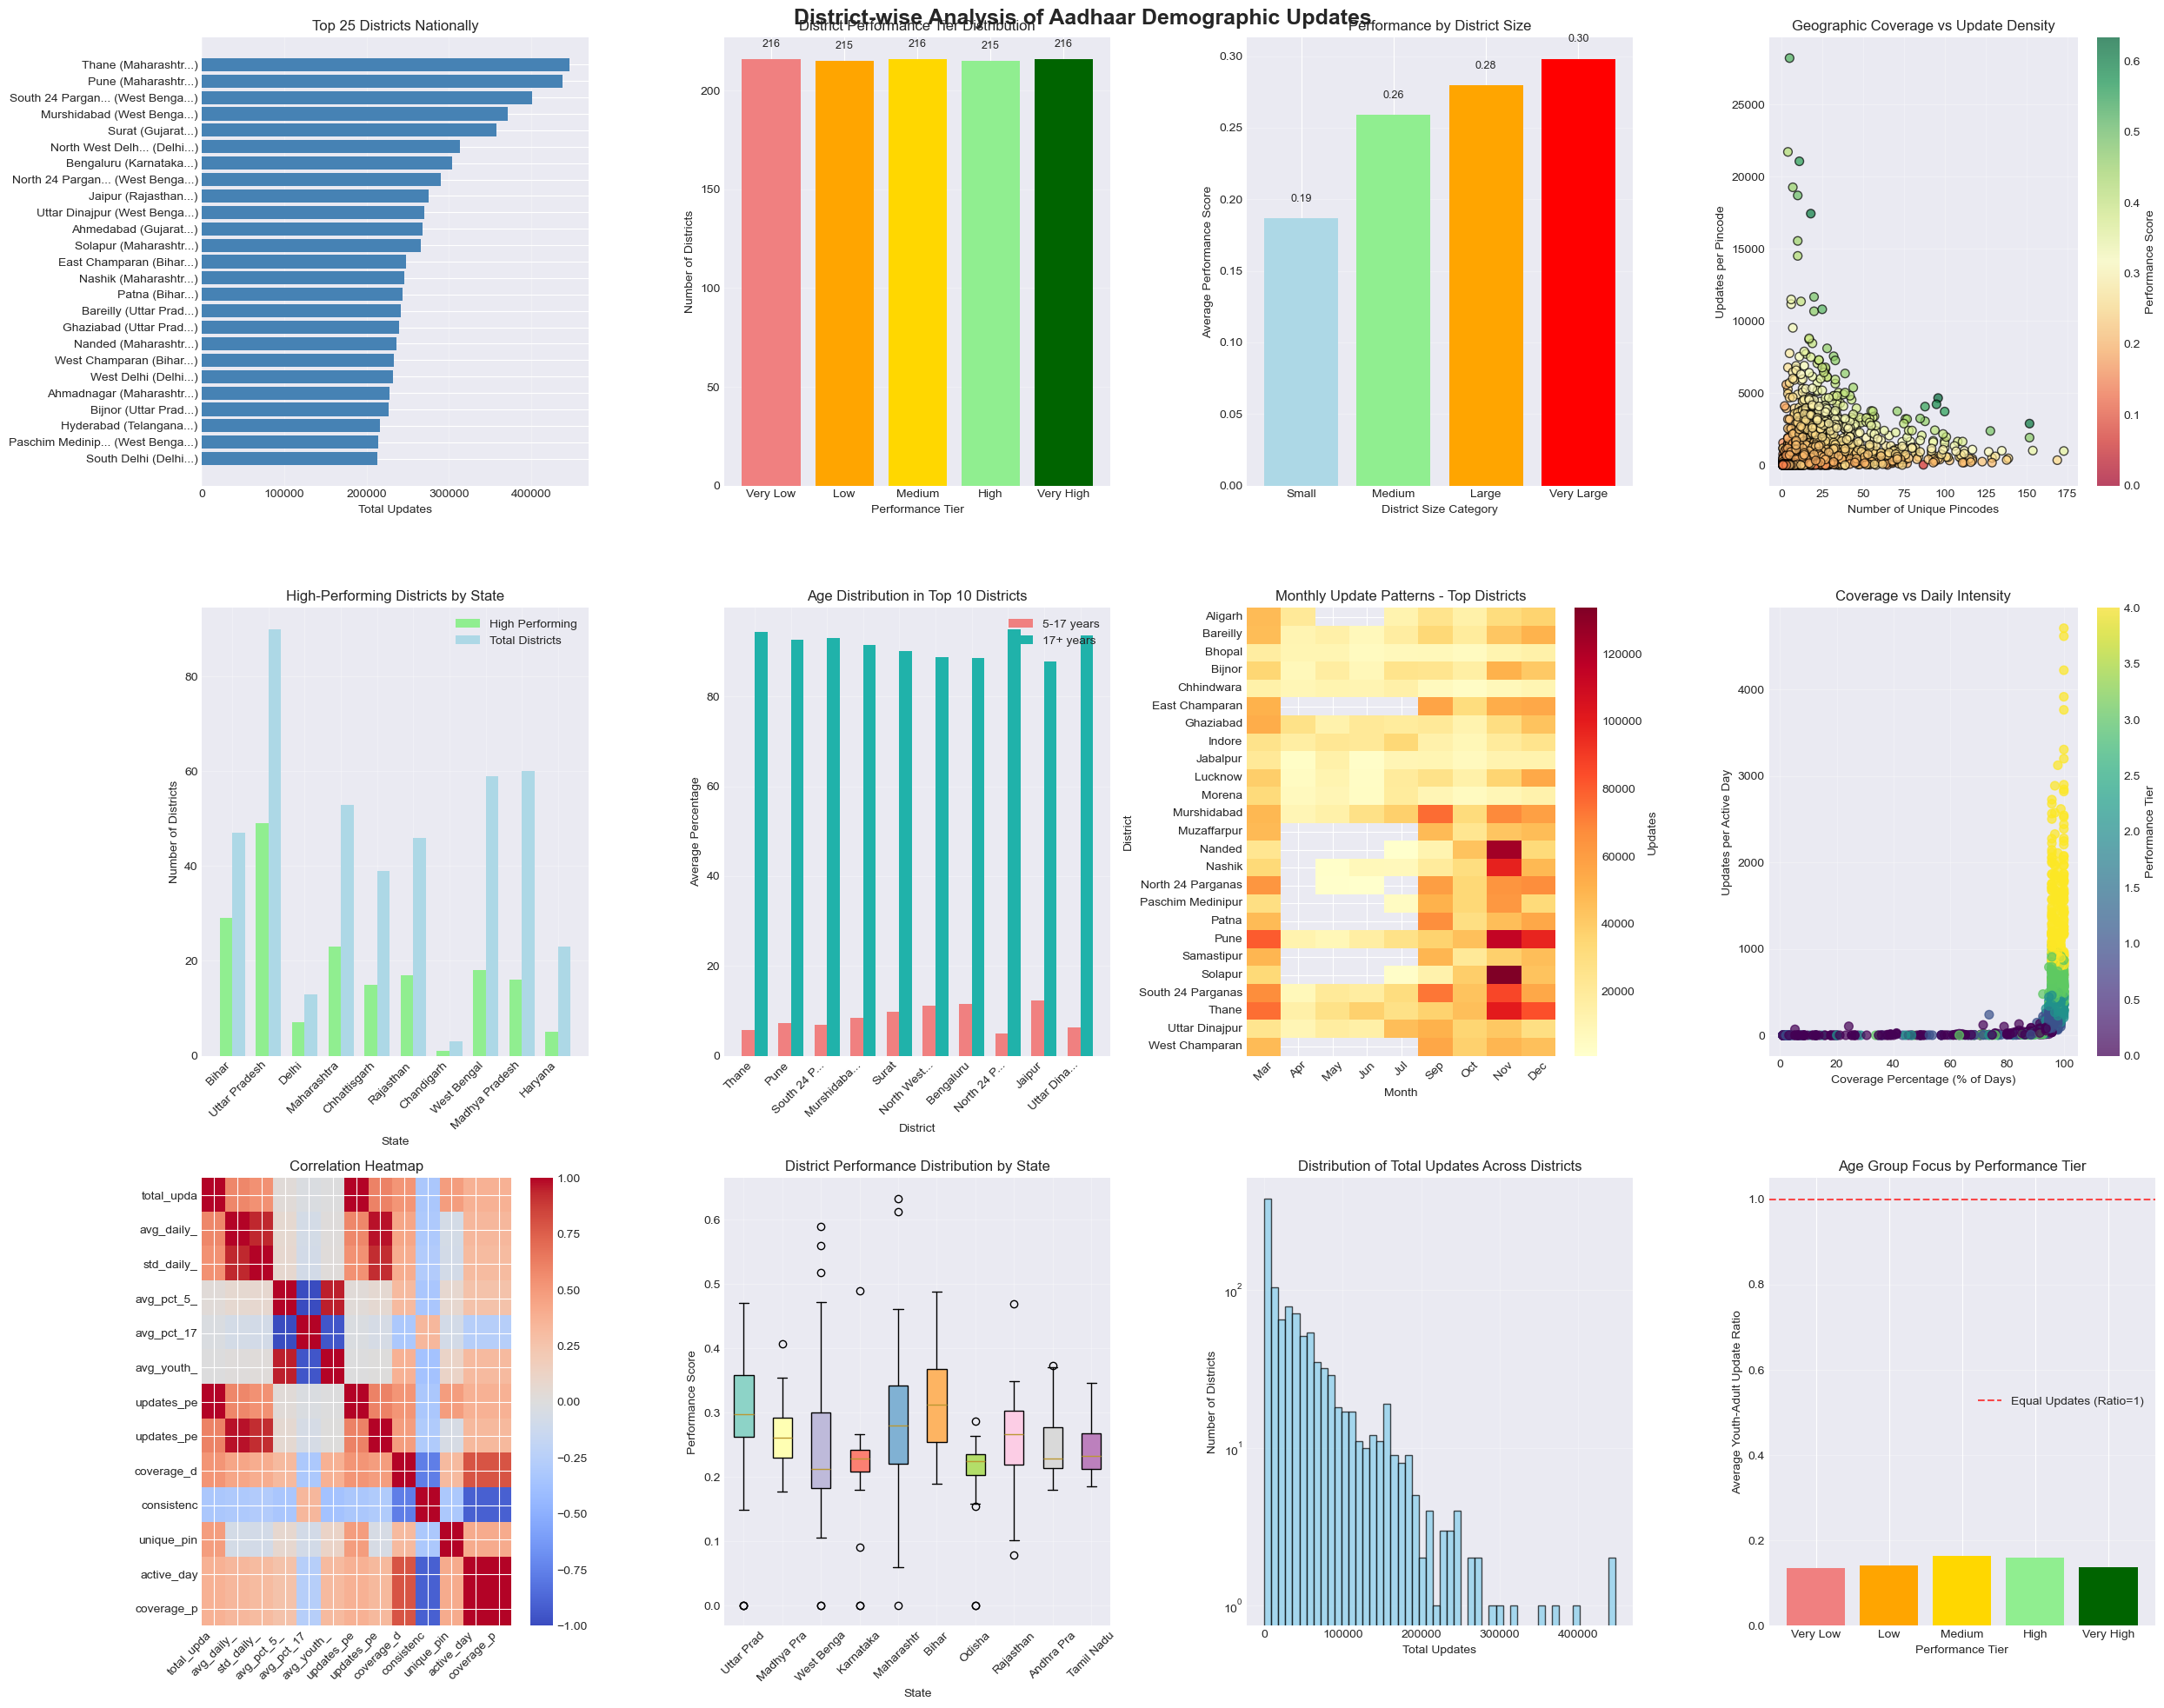

In [375]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(25, 20))
fig.suptitle('District-wise Analysis of Aadhaar Demographic Updates', fontsize=18, fontweight='bold')

# Plot 1: Top 25 districts nationally
ax1 = plt.subplot(3, 4, 1)
top_25 = district_analysis.nlargest(25, 'total_updates')
ax1.barh(range(len(top_25)), top_25['total_updates'], color='steelblue')
ax1.set_yticks(range(len(top_25)))
ax1.set_yticklabels(top_25.apply(lambda x: f"{x['district'][:15]}... ({x['state'][:10]}...)" 
                                 if len(x['district']) > 15 else f"{x['district']} ({x['state'][:10]}...)", axis=1))
ax1.set_xlabel('Total Updates')
ax1.set_title('Top 25 Districts Nationally')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Performance tier distribution
ax2 = plt.subplot(3, 4, 2)
tier_counts = district_analysis['performance_tier'].value_counts().sort_index()
colors = ['lightcoral', 'orange', 'gold', 'lightgreen', 'darkgreen']
bars = ax2.bar(tier_counts.index, tier_counts.values, color=colors)
ax2.set_xlabel('Performance Tier')
ax2.set_ylabel('Number of Districts')
ax2.set_title('District Performance Tier Distribution')
for bar, count in zip(bars, tier_counts.values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
            str(count), ha='center', va='bottom', fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: District size vs performance
ax3 = plt.subplot(3, 4, 3)
size_perf_plot = district_analysis.groupby('size_category')['performance_score'].mean()
colors_size = ['lightblue', 'lightgreen', 'orange', 'red']
bars_size = ax3.bar(size_perf_plot.index, size_perf_plot.values, color=colors_size)
ax3.set_xlabel('District Size Category')
ax3.set_ylabel('Average Performance Score')
ax3.set_title('Performance by District Size')
for bar, value in zip(bars_size, size_perf_plot.values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.2f}', ha='center', va='bottom', fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Updates per pincode vs unique pincodes
ax4 = plt.subplot(3, 4, 4)
scatter = ax4.scatter(district_analysis['unique_pincodes'], 
                     district_analysis['updates_per_pincode'],
                     c=district_analysis['performance_score'], 
                     cmap='RdYlGn', s=50, alpha=0.7, edgecolors='black')
ax4.set_xlabel('Number of Unique Pincodes')
ax4.set_ylabel('Updates per Pincode')
ax4.set_title('Geographic Coverage vs Update Density')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Performance Score')

# Plot 5: State-wise high-performing districts
ax5 = plt.subplot(3, 4, 5)
top_10_hp_states = state_district_summary.nlargest(10, 'high_performing_ratio')
x = np.arange(len(top_10_hp_states))
width = 0.35
bars5a = ax5.bar(x - width/2, top_10_hp_states['high_performing_districts'], width, label='High Performing', color='lightgreen')
bars5b = ax5.bar(x + width/2, top_10_hp_states['num_districts'], width, label='Total Districts', color='lightblue')
ax5.set_xlabel('State')
ax5.set_ylabel('Number of Districts')
ax5.set_title('High-Performing Districts by State')
ax5.set_xticks(x)
ax5.set_xticklabels(top_10_hp_states['state'], rotation=45, ha='right')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Age distribution in top districts
ax6 = plt.subplot(3, 4, 6)
top_10_age = district_analysis.nlargest(10, 'total_updates')
x = np.arange(len(top_10_age))
width = 0.35
bars6a = ax6.bar(x - width/2, top_10_age['avg_pct_5_17'], width, label='5-17 years', color='lightcoral')
bars6b = ax6.bar(x + width/2, top_10_age['avg_pct_17_plus'], width, label='17+ years', color='lightseagreen')
ax6.set_xlabel('District')
ax6.set_ylabel('Average Percentage')
ax6.set_title('Age Distribution in Top 10 Districts')
ax6.set_xticks(x)
district_labels = [f"{d[:10]}..." if len(d) > 10 else d for d in top_10_age['district']]
ax6.set_xticklabels(district_labels, rotation=45, ha='right')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Plot 7: Monthly patterns heatmap for top 5 states
ax7 = plt.subplot(3, 4, 7)
top_5_states = state_district_summary.nlargest(5, 'state_total_updates')['state'].tolist()
districts_top_states = district_analysis[district_analysis['state'].isin(top_5_states)]
top_districts_per_state = districts_top_states.groupby('state').apply(lambda x: x.nlargest(5, 'total_updates')).reset_index(drop=True)

# Create a sample heatmap for top districts
if len(top_districts_per_state) > 0:
    monthly_sample = monthly_district.merge(top_districts_per_state[['state', 'district']], on=['state', 'district'])
    heatmap_pivot = monthly_sample.pivot_table(index='district', columns='month', values='total_updates', aggfunc='sum')
    
    # Get months present in data
    months_present = sorted(heatmap_pivot.columns.tolist())
    month_labels = [month_names[m-1] for m in months_present]
    
    sns.heatmap(heatmap_pivot, cmap='YlOrRd', ax=ax7, cbar_kws={'label': 'Updates'})
    ax7.set_xlabel('Month')
    ax7.set_ylabel('District')
    ax7.set_title('Monthly Update Patterns - Top Districts')
    
    # Set x-tick labels for months present
    ax7.set_xticks(np.arange(len(months_present)) + 0.5)
    ax7.set_xticklabels(month_labels, rotation=45)
else:
    ax7.text(0.5, 0.5, 'Insufficient data\nfor heatmap', 
             ha='center', va='center', transform=ax7.transAxes, fontsize=12)
    ax7.set_title('Monthly Update Patterns')

# Plot 8: Coverage percentage vs updates per active day
ax8 = plt.subplot(3, 4, 8)
scatter2 = ax8.scatter(district_analysis['coverage_percentage'], 
                      district_analysis['updates_per_active_day'],
                      c=district_analysis['performance_tier'].cat.codes, 
                      cmap='viridis', s=50, alpha=0.7)
ax8.set_xlabel('Coverage Percentage (% of Days)')
ax8.set_ylabel('Updates per Active Day')
ax8.set_title('Coverage vs Daily Intensity')
ax8.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax8, label='Performance Tier')

# Plot 9: Correlation heatmap
ax9 = plt.subplot(3, 4, 9)
corr_plot = ax9.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax9.set_xticks(range(len(corr_matrix.columns)))
ax9.set_yticks(range(len(corr_matrix.columns)))
ax9.set_xticklabels([col[:10] for col in corr_matrix.columns], rotation=45, ha='right')
ax9.set_yticklabels([col[:10] for col in corr_matrix.columns])
ax9.set_title('Correlation Heatmap')
plt.colorbar(corr_plot, ax=ax9)

# Plot 10: District performance by state (box plot)
ax10 = plt.subplot(3, 4, 10)
# Select top 10 states by number of districts
top_10_states_districts = state_district_summary.nlargest(10, 'num_districts')['state'].tolist()
boxplot_data = [district_analysis[district_analysis['state'] == state]['performance_score'].dropna() 
                for state in top_10_states_districts]
bp = ax10.boxplot(boxplot_data, patch_artist=True)
for patch, color in zip(bp['boxes'], plt.cm.Set3(np.arange(len(boxplot_data)))):
    patch.set_facecolor(color)
ax10.set_xlabel('State')
ax10.set_ylabel('Performance Score')
ax10.set_title('District Performance Distribution by State')
ax10.set_xticklabels([s[:10] for s in top_10_states_districts], rotation=45)
ax10.grid(True, alpha=0.3)

# Plot 11: Updates distribution histogram
ax11 = plt.subplot(3, 4, 11)
ax11.hist(district_analysis['total_updates'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax11.set_xlabel('Total Updates')
ax11.set_ylabel('Number of Districts')
ax11.set_title('Distribution of Total Updates Across Districts')
ax11.set_yscale('log')  # Use log scale for better visualization
ax11.grid(True, alpha=0.3)

# Plot 12: Youth-adult ratio by performance tier
ax12 = plt.subplot(3, 4, 12)
tier_ratio_data = district_analysis.groupby('performance_tier')['avg_youth_update_ratio'].mean()
colors_tier = ['lightcoral', 'orange', 'gold', 'lightgreen', 'darkgreen']
bars_tier = ax12.bar(tier_ratio_data.index, tier_ratio_data.values, color=colors_tier)
ax12.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Equal Updates (Ratio=1)')
ax12.set_xlabel('Performance Tier')
ax12.set_ylabel('Average Youth-Adult Update Ratio')
ax12.set_title('Age Group Focus by Performance Tier')
ax12.legend()
ax12.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

#### 4.3.12 [ KEY INSIGHTS SUMMARY ]

In [378]:
print("\n" + "="*100)
print("12. KEY INSIGHTS SUMMARY")
print("="*100)

# Insight 1: Overall statistics
total_updates = district_analysis['total_updates'].sum()
print(f"\n1. OVERALL STATISTICS:")
print(f"   - Total districts analyzed: {len(district_analysis)}")
print(f"   - Total demographic updates: {total_updates:,}")
print(f"   - Average updates per district: {district_analysis['total_updates'].mean():,.0f}")

# Insight 2: Top performing districts
top_district_info = district_analysis.nlargest(1, 'total_updates').iloc[0]
print(f"\n2. TOP PERFORMING DISTRICT:")
print(f"   - {top_district_info['district']}, {top_district_info['state']}")
print(f"   - Total updates: {top_district_info['total_updates']:,}")
print(f"   - Performance tier: {top_district_info['performance_tier']}")

# Insight 3: Performance distribution
print(f"\n3. PERFORMANCE DISTRIBUTION:")
very_high_count = len(district_analysis[district_analysis['performance_tier'] == 'Very High'])
low_count = len(district_analysis[district_analysis['performance_tier'].isin(['Low', 'Very Low'])])
print(f"   - High/Very High performing districts: {very_high_count} ({very_high_count/len(district_analysis)*100:.1f}%)")
print(f"   - Low/Very Low performing districts: {low_count} ({low_count/len(district_analysis)*100:.1f}%)")

# Insight 4: Geographic patterns
print(f"\n4. GEOGRAPHIC PATTERNS:")
print(f"   - Districts with wide coverage (>100 pincodes): {len(district_analysis[district_analysis['unique_pincodes'] > 100])}")
print(f"   - Average pincodes per district: {district_analysis['unique_pincodes'].mean():.1f}")
print(f"   - Average coverage days: {district_analysis['coverage_percentage'].mean():.1f}%")

# Insight 5: Age group patterns
print(f"\n5. AGE GROUP PATTERNS:")
print(f"   - Average youth (5-17) update percentage: {district_analysis['avg_pct_5_17'].mean():.1f}%")
print(f"   - Districts with youth-focused updates (>50%): {len(district_analysis[district_analysis['avg_pct_5_17'] > 50])}")
print(f"   - Districts with adult-focused updates (>50%): {len(district_analysis[district_analysis['avg_pct_17_plus'] > 50])}")

# Insight 6: State performance
print(f"\n6. STATE PERFORMANCE ANALYSIS:")
top_state_perf = state_district_summary.nlargest(1, 'high_performing_ratio').iloc[0]
print(f"   - State with highest % of high-performing districts: {top_state_perf['state']} ({top_state_perf['high_performing_ratio']:.1f}%)")
print(f"   - Average districts per state: {state_district_summary['num_districts'].mean():.1f}")

# Insight 7: Size-performance relationship
print(f"\n7. SIZE-PERFORMANCE RELATIONSHIP:")
best_size = size_performance['performance_score'].idxmax()
worst_size = size_performance['performance_score'].idxmin()
print(f"   - Best performing size category: {best_size}")
print(f"   - Worst performing size category: {worst_size}")

# Insight 8: Recommendations
print(f"\n8. STRATEGIC RECOMMENDATIONS:")
print("   - Focus on improving low-performing districts")
print("   - Study and replicate best practices from high-performing districts")
print("   - Tailor approaches based on district size and geographic coverage")
print("   - Monitor districts with high growth potential")
print("   - Address coverage gaps in districts with low activity days")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)


12. KEY INSIGHTS SUMMARY

1. OVERALL STATISTICS:
   - Total districts analyzed: 1078
   - Total demographic updates: 49,295,187
   - Average updates per district: 45,728

2. TOP PERFORMING DISTRICT:
   - Thane, Maharashtra
   - Total updates: 447,253
   - Performance tier: Very High

3. PERFORMANCE DISTRIBUTION:
   - High/Very High performing districts: 216 (20.0%)
   - Low/Very Low performing districts: 431 (40.0%)

4. GEOGRAPHIC PATTERNS:
   - Districts with wide coverage (>100 pincodes): 34
   - Average pincodes per district: 29.2
   - Average coverage days: 84.1%

5. AGE GROUP PATTERNS:
   - Average youth (5-17) update percentage: 10.4%
   - Districts with youth-focused updates (>50%): 3
   - Districts with adult-focused updates (>50%): 1075

6. STATE PERFORMANCE ANALYSIS:
   - State with highest % of high-performing districts: Bihar (61.7%)
   - Average districts per state: 16.6

7. SIZE-PERFORMANCE RELATIONSHIP:
   - Best performing size category: Very Large
   - Worst performin

#### 4.3.13 [ DISTRICT PERFORMANCE SUMMARY (Top 30) ]

In [381]:
print("\n" + "="*100)
print("13. DISTRICT PERFORMANCE SUMMARY (Top 30)")
print("="*100)

summary_columns = ['state', 'district', 'total_updates', 'performance_tier',
                  'size_category', 'avg_daily_updates', 'updates_per_pincode',
                  'coverage_percentage', 'avg_pct_5_17', 'avg_pct_17_plus',
                  'unique_pincodes', 'active_days']

summary_report = district_analysis[summary_columns].sort_values('total_updates', ascending=False)
print(summary_report.head(30).to_string(index=False))

# Export state-wise district performance
print("\n" + "="*100)
print("STATE-WISE DISTRICT PERFORMANCE SUMMARY")
print("="*100)

for state in sorted(district_analysis['state'].unique()):
    state_data = district_analysis[district_analysis['state'] == state]
    if len(state_data) > 0:
        top_state_district = state_data.nlargest(1, 'total_updates').iloc[0]
        avg_updates = state_data['total_updates'].mean()
        high_perf_count = len(state_data[state_data['performance_tier'] == 'Very High'])
        
        print(f"\n{state}:")
        print(f"  Districts: {len(state_data)}")
        print(f"  Total Updates: {state_data['total_updates'].sum():,}")
        print(f"  Average per District: {avg_updates:,.0f}")
        print(f"  Top District: {top_state_district['district']} "
              f"({top_state_district['total_updates']:,} updates)")
        print(f"  High-Performing Districts: {high_perf_count}")

print("\n" + "="*100)
print("ALL ANALYSES COMPLETED SUCCESSFULLY!")
print("="*100)


13. DISTRICT PERFORMANCE SUMMARY (Top 30)
        state          district  total_updates performance_tier size_category  avg_daily_updates  updates_per_pincode  coverage_percentage  avg_pct_5_17  avg_pct_17_plus  unique_pincodes  active_days
  Maharashtra             Thane         447253        Very High         Large              57.75          4658.885417           100.000000          5.69            94.31               96           95
  Maharashtra              Pune         438478        Very High    Very Large              35.22          2884.723684           100.000000          7.29            92.71              152           95
  West Bengal South 24 Parganas         401137        Very High         Large              50.51          4222.494737           100.000000          6.88            93.12               95           95
  West Bengal       Murshidabad         371953        Very High         Large              46.18          3719.530000           100.000000          8.45     

### 4.4 Age-wise Analysis of Aadhaar Demographic Updates

In [384]:
print("Starting age-wise analysis of demographic updates...")
print(f"Total records in dataset: {len(df)}")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")

# Define month names for better readability
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Starting age-wise analysis of demographic updates...
Total records in dataset: 2071700
Date Range: 2025-03-01 00:00:00 to 2025-12-29 00:00:00


#### 4.4.1 [ NATIONAL-LEVEL AGE DISTRIBUTION ANALYSIS ]

In [386]:
print("\n" + "="*100)
print("1. NATIONAL-LEVEL AGE DISTRIBUTION ANALYSIS")
print("="*100)

# Calculate national totals for each age group
national_age_totals = {
    '5_17': df['demo_age_5_17'].sum(),
    '17_plus': df['demo_age_17_'].sum()
}

national_total = national_age_totals['5_17'] + national_age_totals['17_plus']
national_percentages = {k: (v/national_total)*100 for k, v in national_age_totals.items()}

print(f"\nNATIONAL AGE DISTRIBUTION OF DEMOGRAPHIC UPDATES:")
print(f"Total Updates: {national_total:,}")
print(f"\nAge Group Distribution:")
print(f"- 5-17 years: {national_age_totals['5_17']:,} ({national_percentages['5_17']:.2f}%)")
print(f"- 17+ years: {national_age_totals['17_plus']:,} ({national_percentages['17_plus']:.2f}%)")

# Calculate youth vs adult ratio
youth_adult_ratio = national_age_totals['5_17'] / national_age_totals['17_plus'] if national_age_totals['17_plus'] > 0 else np.nan
print(f"- Youth-Adult Ratio: {youth_adult_ratio:.3f}")
if youth_adult_ratio > 1:
    print(f"  (More youth updates than adult updates)")
else:
    print(f"  (More adult updates than youth updates)")


1. NATIONAL-LEVEL AGE DISTRIBUTION ANALYSIS

NATIONAL AGE DISTRIBUTION OF DEMOGRAPHIC UPDATES:
Total Updates: 49,295,187

Age Group Distribution:
- 5-17 years: 4,863,424 (9.87%)
- 17+ years: 44,431,763 (90.13%)
- Youth-Adult Ratio: 0.109
  (More adult updates than youth updates)


#### 4.4.2 [ TEMPORAL TRENDS IN AGE DISTRIBUTION ]

In [388]:
print("\n" + "="*100)
print("2. TEMPORAL TRENDS IN AGE DISTRIBUTION")
print("="*100)

# Yearly age distribution
yearly_age_dist = df.groupby('year').agg({
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'total_updates': 'sum'
}).reset_index()

# Calculate percentages for each year
yearly_age_dist['pct_5_17'] = (yearly_age_dist['demo_age_5_17'] / yearly_age_dist['total_updates']) * 100
yearly_age_dist['pct_17_plus'] = (yearly_age_dist['demo_age_17_'] / yearly_age_dist['total_updates']) * 100
yearly_age_dist['youth_adult_ratio'] = yearly_age_dist['demo_age_5_17'] / yearly_age_dist['demo_age_17_']

print("\nYEARLY AGE DISTRIBUTION TRENDS:")
print(yearly_age_dist[['year', 'total_updates', 'pct_5_17', 'pct_17_plus', 'youth_adult_ratio']].to_string(index=False))

# Calculate YoY changes
if len(yearly_age_dist) > 1:
    yearly_age_dist['yoy_change_5_17'] = yearly_age_dist['pct_5_17'].pct_change() * 100
    yearly_age_dist['yoy_change_17_plus'] = yearly_age_dist['pct_17_plus'].pct_change() * 100
    yearly_age_dist['yoy_change_ratio'] = yearly_age_dist['youth_adult_ratio'].pct_change() * 100
    
    print("\nYEAR-OVER-YEAR CHANGES:")
    print(yearly_age_dist[['year', 'yoy_change_5_17', 'yoy_change_17_plus', 'yoy_change_ratio']].to_string(index=False))


2. TEMPORAL TRENDS IN AGE DISTRIBUTION

YEARLY AGE DISTRIBUTION TRENDS:
 year  total_updates  pct_5_17  pct_17_plus  youth_adult_ratio
 2025       49295187  9.865921    90.134079           0.109458


#### 4.4.3 [ MONTHLY/SEASONAL AGE DISTRIBUTION PATTERNS ]

In [390]:
print("\n" + "="*100)
print("3. MONTHLY/SEASONAL AGE DISTRIBUTION PATTERNS")
print("="*100)

monthly_age_dist = df.groupby('month').agg({
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'total_updates': 'sum'
}).reset_index()

# Calculate monthly percentages
monthly_age_dist['pct_5_17'] = (monthly_age_dist['demo_age_5_17'] / monthly_age_dist['total_updates']) * 100
monthly_age_dist['pct_17_plus'] = (monthly_age_dist['demo_age_17_'] / monthly_age_dist['total_updates']) * 100
monthly_age_dist['youth_adult_ratio'] = monthly_age_dist['demo_age_5_17'] / monthly_age_dist['demo_age_17_']
monthly_age_dist['month_name'] = monthly_age_dist['month'].apply(lambda x: month_names[x-1])

print("\nMONTHLY AGE DISTRIBUTION PATTERNS:")
print(monthly_age_dist[['month_name', 'total_updates', 'pct_5_17', 'pct_17_plus', 'youth_adult_ratio']].to_string(index=False))

# Identify peak months for each age group
peak_youth_month = monthly_age_dist.loc[monthly_age_dist['pct_5_17'].idxmax()]
peak_adult_month = monthly_age_dist.loc[monthly_age_dist['pct_17_plus'].idxmax()]

print(f"\nPEAK MONTHS:")
print(f"- Highest youth (5-17) updates: {peak_youth_month['month_name']} ({peak_youth_month['pct_5_17']:.1f}%)")
print(f"- Highest adult (17+) updates: {peak_adult_month['month_name']} ({peak_adult_month['pct_17_plus']:.1f}%)")


3. MONTHLY/SEASONAL AGE DISTRIBUTION PATTERNS

MONTHLY AGE DISTRIBUTION PATTERNS:
month_name  total_updates  pct_5_17  pct_17_plus  youth_adult_ratio
       Mar       11147558  8.756133    91.243867           0.095964
       Apr        1515672 13.112600    86.887400           0.150915
       May        1566287 13.081447    86.918553           0.150502
       Jun        1685562 11.733001    88.266999           0.132926
       Jul        2220715 12.989015    87.010985           0.149280
       Sep        7324060 10.524054    89.475946           0.117619
       Oct        5010966  9.563665    90.436335           0.105750
       Nov        9387601  8.748486    91.251514           0.095872
       Dec        9436766  9.814623    90.185377           0.108827

PEAK MONTHS:
- Highest youth (5-17) updates: Apr (13.1%)
- Highest adult (17+) updates: Nov (91.3%)


#### 4.4.4 [ STATE-WISE AGE DISTRIBUTION ANALYSIS ]

In [392]:
print("\n" + "="*100)
print("4. STATE-WISE AGE DISTRIBUTION ANALYSIS")
print("="*100)

state_age_dist = df.groupby('state').agg({
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'total_updates': 'sum',
    'youth_update_ratio': 'mean'
}).reset_index()

# Calculate state-wise percentages
state_age_dist['pct_5_17'] = (state_age_dist['demo_age_5_17'] / state_age_dist['total_updates']) * 100
state_age_dist['pct_17_plus'] = (state_age_dist['demo_age_17_'] / state_age_dist['total_updates']) * 100
state_age_dist['youth_adult_ratio'] = state_age_dist['demo_age_5_17'] / state_age_dist['demo_age_17_']

print("\nTOP 10 STATES WITH HIGHEST YOUTH (5-17) UPDATE PERCENTAGE:")
top_youth_states = state_age_dist.nlargest(10, 'pct_5_17')[['state', 'total_updates', 'pct_5_17', 'pct_17_plus', 'youth_adult_ratio']]
print(top_youth_states.to_string(index=False))

print("\nTOP 10 STATES WITH HIGHEST ADULT (17+) UPDATE PERCENTAGE:")
top_adult_states = state_age_dist.nlargest(10, 'pct_17_plus')[['state', 'total_updates', 'pct_17_plus', 'pct_5_17', 'youth_adult_ratio']]
print(top_adult_states.to_string(index=False))

print("\nSTATES WITH HIGHEST YOUTH-ADULT UPDATE RATIO:")
high_ratio_states = state_age_dist.nlargest(10, 'youth_adult_ratio')[['state', 'youth_adult_ratio', 'pct_5_17', 'pct_17_plus', 'total_updates']]
print(high_ratio_states.to_string(index=False))

# Categorize states by age focus
state_age_dist['age_focus'] = np.where(
    state_age_dist['pct_5_17'] > 60, 'Youth Dominant',
    np.where(
        state_age_dist['pct_17_plus'] > 60, 'Adult Dominant',
        np.where(
            state_age_dist['pct_5_17'] > state_age_dist['pct_17_plus'], 'Youth Focused',
            'Adult Focused'
        )
    )
)

print("\nSTATE AGE FOCUS CATEGORIZATION:")
age_focus_dist = state_age_dist['age_focus'].value_counts()
for focus, count in age_focus_dist.items():
    percentage = (count / len(state_age_dist)) * 100
    print(f"  {focus}: {count} states ({percentage:.1f}%)")


4. STATE-WISE AGE DISTRIBUTION ANALYSIS

TOP 10 STATES WITH HIGHEST YOUTH (5-17) UPDATE PERCENTAGE:
                 state  total_updates  pct_5_17  pct_17_plus  youth_adult_ratio
                Ladakh           5735 23.975588    76.024412           0.315367
Dadra and Nagar Haveli           6033 21.713907    78.286093           0.277366
            Puducherry          25304 16.159500    83.840500           0.192741
     Arunachal Pradesh          36443 15.868617    84.131383           0.188617
            Chandigarh          83361 15.754370    84.245630           0.187005
             Karnataka        1695285 15.630469    84.369531           0.185262
         Daman and Diu           1552 15.077320    84.922680           0.177542
             Telangana        1629908 14.863354    85.136646           0.174582
           Lakshadweep           1176 14.455782    85.544218           0.168986
            Tamil Nadu        2212228 14.267878    85.732122           0.166424

TOP 10 STATES WITH

#### 4.4.5 [ DISTRICT-WISE AGE DISTRIBUTION ANALYSIS ]

In [394]:
print("\n" + "="*100)
print("5. DISTRICT-WISE AGE DISTRIBUTION ANALYSIS")
print("="*100)

# For top 20 districts by total updates
top_districts = df.groupby(['state', 'district']).agg({
    'total_updates': 'sum'
}).nlargest(20, 'total_updates').reset_index()

district_age_analysis = []
for _, row in top_districts.iterrows():
    district_data = df[(df['state'] == row['state']) & (df['district'] == row['district'])]
    total = district_data['total_updates'].sum()
    age_5_17 = district_data['demo_age_5_17'].sum()
    age_17_plus = district_data['demo_age_17_'].sum()
    
    district_age_analysis.append({
        'state': row['state'],
        'district': row['district'],
        'total_updates': total,
        'pct_5_17': (age_5_17/total)*100,
        'pct_17_plus': (age_17_plus/total)*100,
        'youth_adult_ratio': age_5_17 / age_17_plus if age_17_plus > 0 else np.nan
    })

district_age_df = pd.DataFrame(district_age_analysis)

print("\nAGE DISTRIBUTION IN TOP 20 DISTRICTS BY UPDATES:")
print(district_age_df[['state', 'district', 'total_updates', 'pct_5_17', 'pct_17_plus', 'youth_adult_ratio']].to_string(index=False))


5. DISTRICT-WISE AGE DISTRIBUTION ANALYSIS

AGE DISTRIBUTION IN TOP 20 DISTRICTS BY UPDATES:
        state          district  total_updates  pct_5_17  pct_17_plus  youth_adult_ratio
  Maharashtra             Thane         447253  8.069258    91.930742           0.087775
  Maharashtra              Pune         438478  7.444843    92.555157           0.080437
  West Bengal South 24 Parganas         401137  6.912352    93.087648           0.074256
  West Bengal       Murshidabad         371953  8.363960    91.636040           0.091274
      Gujarat             Surat         357582  9.843337    90.156663           0.109180
        Delhi  North West Delhi         313989 12.657768    87.342232           0.144922
    Karnataka         Bengaluru         303924 12.681131    87.318869           0.145228
  West Bengal North 24 Parganas         290477  5.170805    94.829195           0.054528
    Rajasthan            Jaipur         275340 10.730007    89.269993           0.120197
  West Bengal   

#### 4.4.6 [ QUARTERLY AGE DISTRIBUTION ANALYSIS ]

In [396]:
print("\n" + "="*100)
print("6. QUARTERLY AGE DISTRIBUTION ANALYSIS")
print("="*100)

quarterly_age_dist = df.groupby('quarter').agg({
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'total_updates': 'sum'
}).reset_index()

quarterly_age_dist['pct_5_17'] = (quarterly_age_dist['demo_age_5_17'] / quarterly_age_dist['total_updates']) * 100
quarterly_age_dist['pct_17_plus'] = (quarterly_age_dist['demo_age_17_'] / quarterly_age_dist['total_updates']) * 100
quarterly_age_dist['youth_adult_ratio'] = quarterly_age_dist['demo_age_5_17'] / quarterly_age_dist['demo_age_17_']

print("\nQUARTERLY AGE DISTRIBUTION:")
print(quarterly_age_dist[['quarter', 'total_updates', 'pct_5_17', 'pct_17_plus', 'youth_adult_ratio']].to_string(index=False))


6. QUARTERLY AGE DISTRIBUTION ANALYSIS

QUARTERLY AGE DISTRIBUTION:
 quarter  total_updates  pct_5_17  pct_17_plus  youth_adult_ratio
       1       11147558  8.756133    91.243867           0.095964
       2        4767521 12.614606    87.385394           0.144356
       3        9544775 11.097559    88.902441           0.124829
       4       23835333  9.341963    90.658037           0.103046


#### 4.4.7 [ STATISTICAL ANALYSIS OF AGE DISTRIBUTION ]

In [398]:
print("\n" + "="*100)
print("7. STATISTICAL ANALYSIS OF AGE DISTRIBUTION")
print("="*100)

# Calculate statistics for each age group percentage
age_stats = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Std Dev', 'Min', 'Max', '25th Percentile', '75th Percentile'],
    '5-17 years %': [
        df['pct_5_17'].mean(),
        df['pct_5_17'].median(),
        df['pct_5_17'].std(),
        df['pct_5_17'].min(),
        df['pct_5_17'].max(),
        df['pct_5_17'].quantile(0.25),
        df['pct_5_17'].quantile(0.75)
    ],
    '17+ years %': [
        df['pct_17_plus'].mean(),
        df['pct_17_plus'].median(),
        df['pct_17_plus'].std(),
        df['pct_17_plus'].min(),
        df['pct_17_plus'].max(),
        df['pct_17_plus'].quantile(0.25),
        df['pct_17_plus'].quantile(0.75)
    ],
    'Youth-Adult Ratio': [
        df['youth_update_ratio'].mean(),
        df['youth_update_ratio'].median(),
        df['youth_update_ratio'].std(),
        df['youth_update_ratio'].min(),
        df['youth_update_ratio'].max(),
        df['youth_update_ratio'].quantile(0.25),
        df['youth_update_ratio'].quantile(0.75)
    ]
})

print("\nSTATISTICAL SUMMARY OF AGE DISTRIBUTION:")
print(age_stats.to_string(index=False))


7. STATISTICAL ANALYSIS OF AGE DISTRIBUTION

STATISTICAL SUMMARY OF AGE DISTRIBUTION:
         Metric  5-17 years %  17+ years %  Youth-Adult Ratio
           Mean     11.242646    88.757354           0.166002
         Median      3.448276    96.551724           0.034483
        Std Dev     18.318941    18.318941           0.342172
            Min      0.000000     0.000000           0.000000
            Max    100.000000   100.000000          25.000000
25th Percentile      0.000000    84.210526           0.000000
75th Percentile     15.789474   100.000000           0.187500


#### 4.4.8 [ AGE DISTRIBUTION CATEGORIZATION ]

In [400]:
print("\n" + "="*100)
print("8. AGE DISTRIBUTION CATEGORIZATION")
print("="*100)

# Categorize records based on age distribution
def categorize_age_distribution(row):
    youth_pct = row['pct_5_17'] if pd.notna(row['pct_5_17']) else 0
    adult_pct = row['pct_17_plus'] if pd.notna(row['pct_17_plus']) else 0
    
    if youth_pct > 70:
        return 'Youth Dominant'
    elif youth_pct > 60:
        return 'Youth Heavy'
    elif youth_pct > 50:
        return 'Youth Focused'
    elif adult_pct > 70:
        return 'Adult Dominant'
    elif adult_pct > 60:
        return 'Adult Heavy'
    elif adult_pct > 50:
        return 'Adult Focused'
    else:
        return 'Balanced'

df['age_category'] = df.apply(categorize_age_distribution, axis=1)

age_category_dist = df['age_category'].value_counts()
print("\nAGE DISTRIBUTION CATEGORIES:")
for category, count in age_category_dist.items():
    percentage = (count / len(df)) * 100
    avg_total = df[df['age_category'] == category]['total_updates'].mean()
    print(f"  {category}: {count:,} records ({percentage:.1f}%), Avg updates: {avg_total:.1f}")


8. AGE DISTRIBUTION CATEGORIZATION

AGE DISTRIBUTION CATEGORIES:
  Adult Dominant: 1,841,901 records (88.9%), Avg updates: 26.0
  Adult Heavy: 86,529 records (4.2%), Avg updates: 9.6
  Balanced: 58,542 records (2.8%), Avg updates: 2.9
  Youth Dominant: 43,359 records (2.1%), Avg updates: 1.7
  Adult Focused: 24,626 records (1.2%), Avg updates: 9.9
  Youth Heavy: 10,558 records (0.5%), Avg updates: 4.6
  Youth Focused: 6,185 records (0.3%), Avg updates: 11.0


#### 4.4.9 [ CORRELATION ANALYSIS ]

In [402]:
print("\n" + "="*100)
print("9. CORRELATION ANALYSIS")
print("="*100)

# Calculate correlations between age groups and other metrics
correlation_vars = ['total_updates', 'pct_5_17', 'pct_17_plus', 'youth_update_ratio',
                   'year', 'month', 'quarter', 'day_of_week']

corr_matrix = df[correlation_vars].corr()

print("\nCORRELATION MATRIX:")
print(corr_matrix.round(3))

# Find strong correlations
print("\nSTRONG CORRELATIONS (>0.5 or <-0.5):")
strong_correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.5 and not pd.isna(corr_value):
            strong_correlations.append({
                'Variable 1': corr_matrix.columns[i],
                'Variable 2': corr_matrix.columns[j],
                'Correlation': corr_value
            })

if strong_correlations:
    strong_corr_df = pd.DataFrame(strong_correlations).sort_values('Correlation', key=abs, ascending=False)
    print(strong_corr_df.to_string(index=False))
else:
    print("No strong correlations found (>0.5 or <-0.5)")


9. CORRELATION ANALYSIS

CORRELATION MATRIX:
                    total_updates  pct_5_17  pct_17_plus  youth_update_ratio  \
total_updates               1.000    -0.013        0.013              -0.022   
pct_5_17                   -0.013     1.000       -1.000               0.865   
pct_17_plus                 0.013    -1.000        1.000              -0.865   
youth_update_ratio         -0.022     0.865       -0.865               1.000   
year                          NaN       NaN          NaN                 NaN   
month                      -0.302    -0.005        0.005               0.000   
quarter                    -0.285     0.012       -0.012               0.018   
day_of_week                 0.032     0.045       -0.045               0.046   

                    year  month  quarter  day_of_week  
total_updates        NaN -0.302   -0.285        0.032  
pct_5_17             NaN -0.005    0.012        0.045  
pct_17_plus          NaN  0.005   -0.012       -0.045  
youth_upd

#### 4.4.10 [ DAY OF WEEK ANALYSIS BY AGE GROUP ]

In [404]:
print("\n" + "="*100)
print("10. DAY OF WEEK ANALYSIS BY AGE GROUP")
print("="*100)

dow_age_dist = df.groupby('day_of_week').agg({
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'total_updates': 'sum'
}).reset_index()

dow_age_dist['pct_5_17'] = (dow_age_dist['demo_age_5_17'] / dow_age_dist['total_updates']) * 100
dow_age_dist['pct_17_plus'] = (dow_age_dist['demo_age_17_'] / dow_age_dist['total_updates']) * 100
dow_age_dist['day_name'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

print("\nDAY OF WEEK AGE DISTRIBUTION:")
print(dow_age_dist[['day_name', 'total_updates', 'pct_5_17', 'pct_17_plus']].to_string(index=False))


10. DAY OF WEEK ANALYSIS BY AGE GROUP

DAY OF WEEK AGE DISTRIBUTION:
 day_name  total_updates  pct_5_17  pct_17_plus
   Monday        4982642  9.175173    90.824827
  Tuesday        8506008 10.989503    89.010497
Wednesday        4499616  9.169760    90.830240
 Thursday        6424767 10.436332    89.563668
   Friday        5471031  9.370775    90.629225
 Saturday       15618092  9.062285    90.937715
   Sunday        3793031 12.136521    87.863479


#### 4.4.11 [ VISUALIZATIONS ]

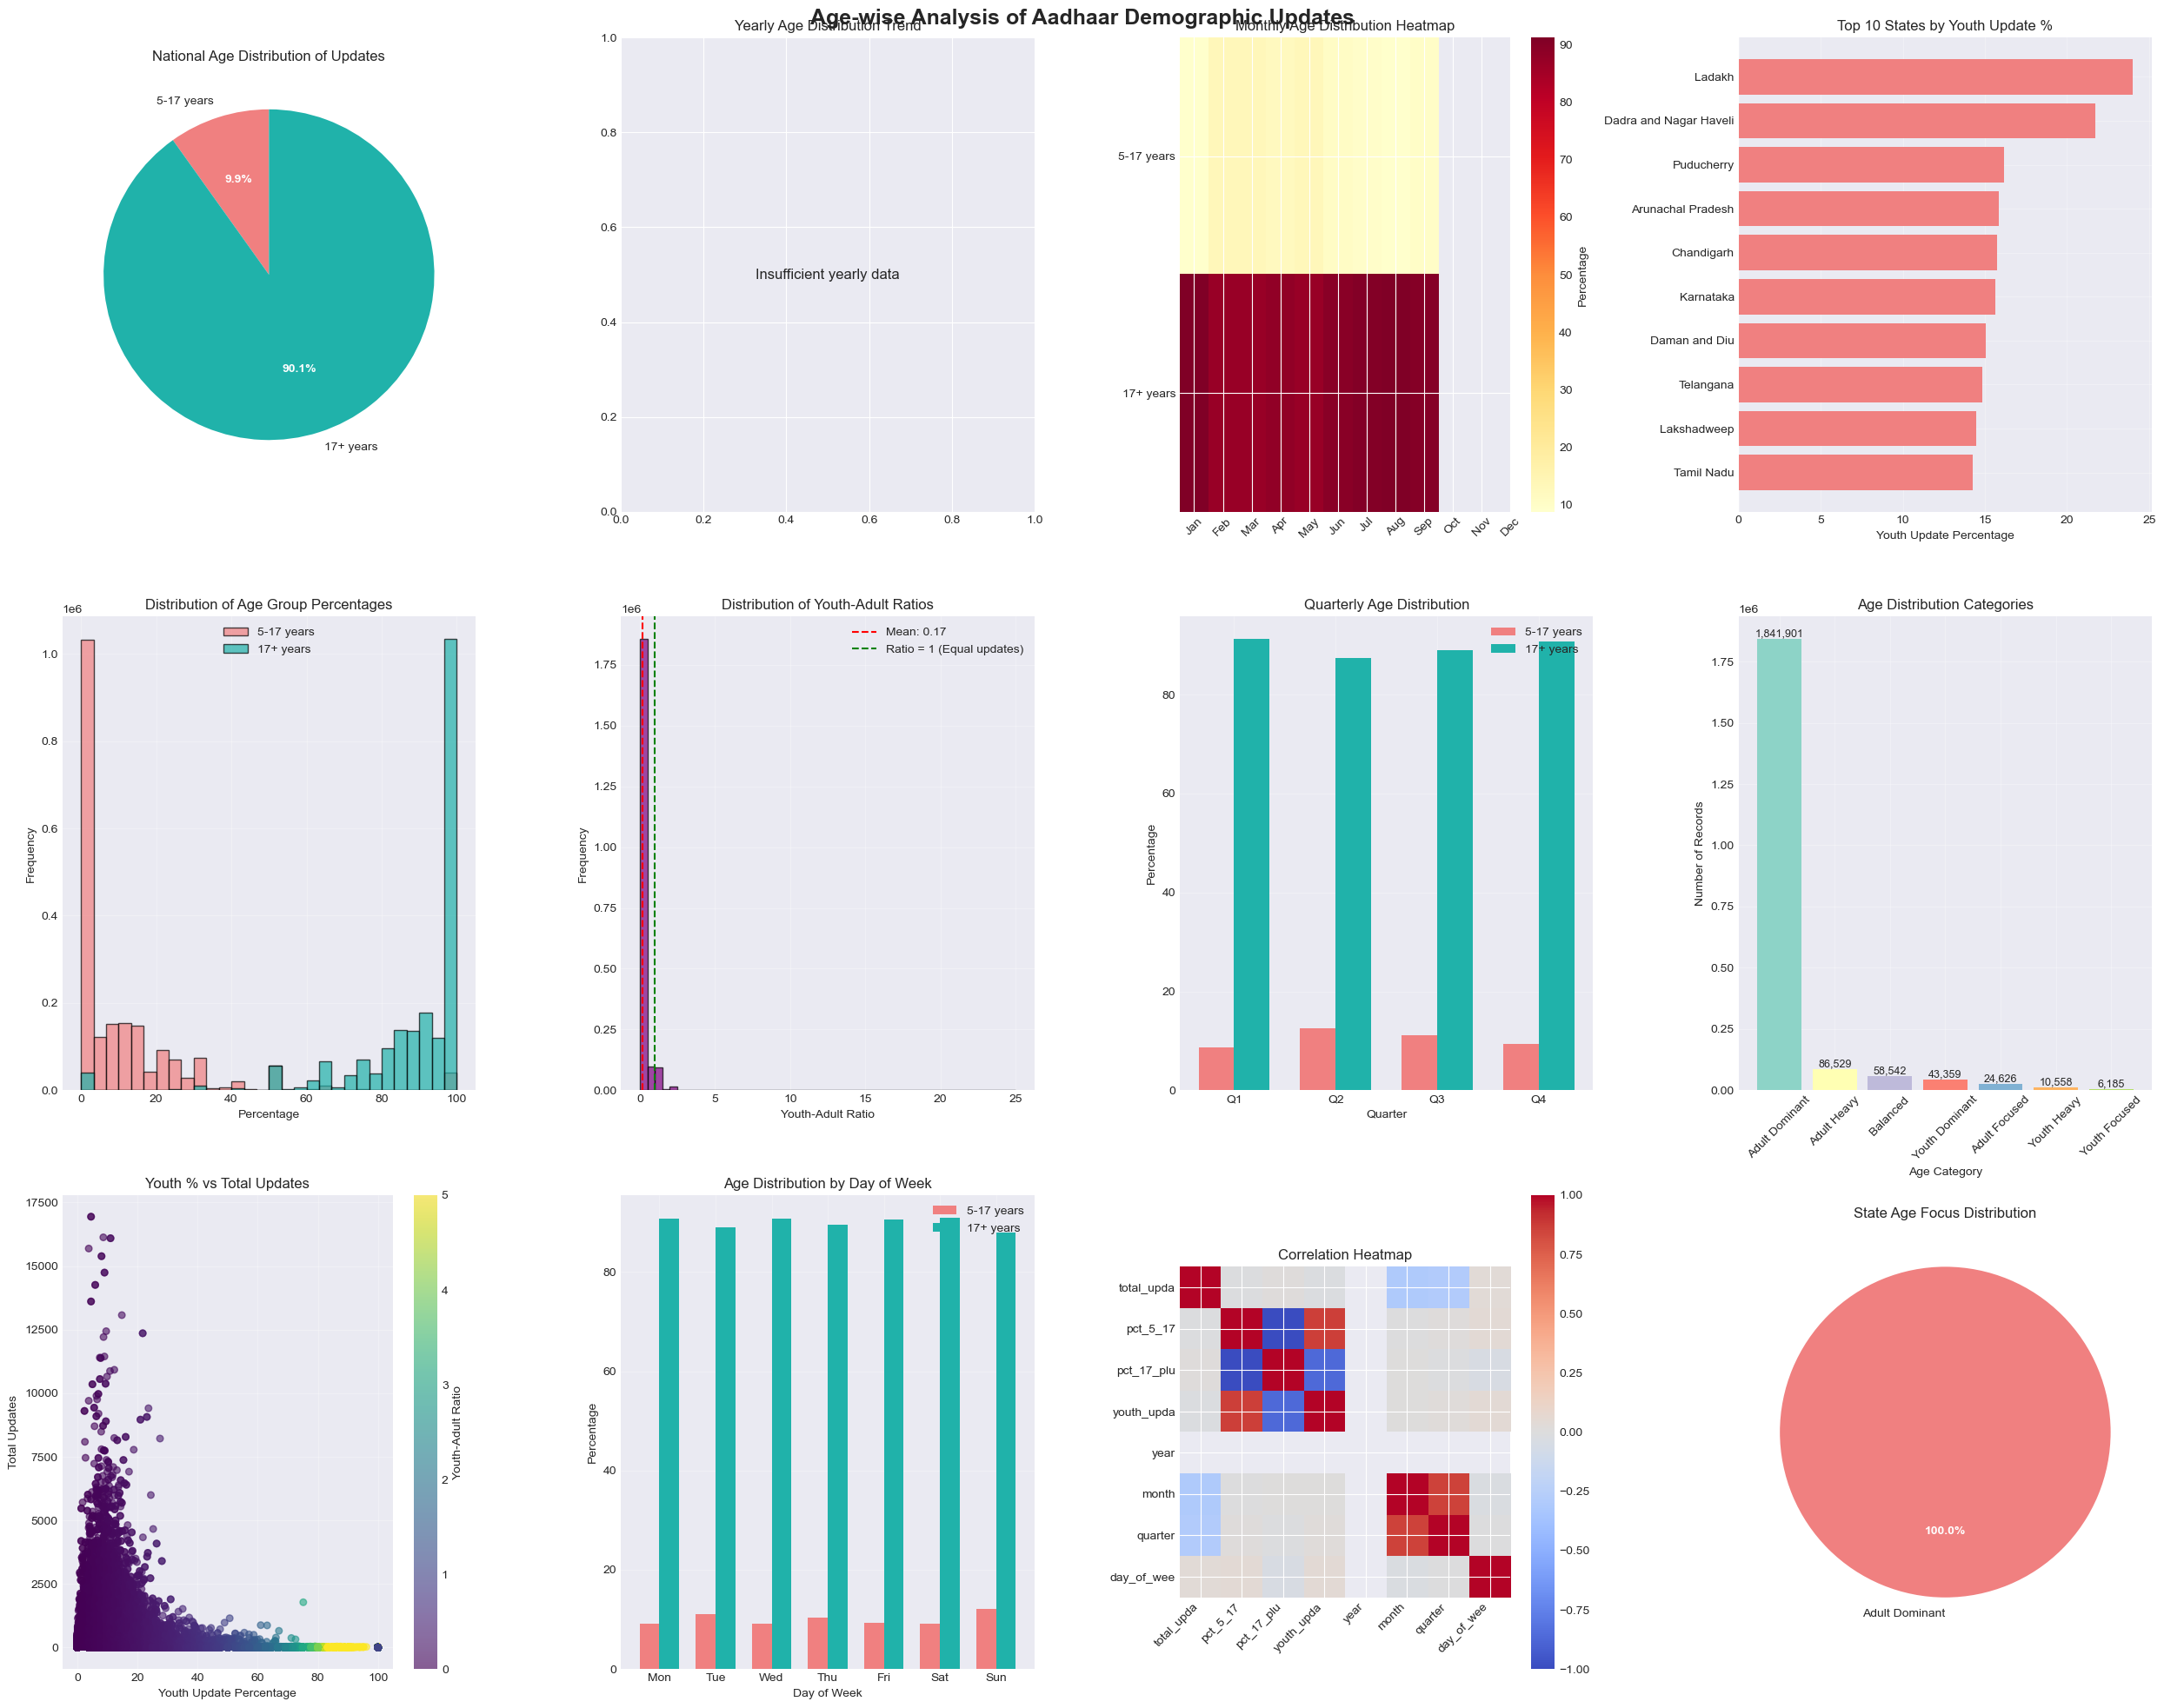

In [406]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(25, 20))
fig.suptitle('Age-wise Analysis of Aadhaar Demographic Updates', fontsize=18, fontweight='bold')

# Plot 1: National Age Distribution Pie Chart
ax1 = plt.subplot(3, 4, 1)
age_groups = ['5-17 years', '17+ years']
age_values = [national_age_totals['5_17'], national_age_totals['17_plus']]
colors = ['lightcoral', 'lightseagreen']
wedges, texts, autotexts = ax1.pie(age_values, labels=age_groups, autopct='%1.1f%%', 
                                   colors=colors, startangle=90)
ax1.set_title('National Age Distribution of Updates')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Plot 2: Yearly Trend of Age Distribution
ax2 = plt.subplot(3, 4, 2)
if len(yearly_age_dist) > 1:
    years = yearly_age_dist['year']
    x = np.arange(len(years))
    width = 0.35
    ax2.bar(x - width/2, yearly_age_dist['pct_5_17'], width, label='5-17 years', color='lightcoral')
    ax2.bar(x + width/2, yearly_age_dist['pct_17_plus'], width, label='17+ years', color='lightseagreen')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Percentage')
    ax2.set_title('Yearly Age Distribution Trend')
    ax2.set_xticks(x)
    ax2.set_xticklabels(years)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'Insufficient yearly data', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Yearly Age Distribution Trend')

# Plot 3: Monthly Age Distribution Heatmap
ax3 = plt.subplot(3, 4, 3)
heatmap_data = monthly_age_dist[['pct_5_17', 'pct_17_plus']].T
im = ax3.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
ax3.set_yticks(range(2))
ax3.set_yticklabels(['5-17 years', '17+ years'])
ax3.set_xticks(range(12))
ax3.set_xticklabels(month_names, rotation=45)
ax3.set_title('Monthly Age Distribution Heatmap')
plt.colorbar(im, ax=ax3, label='Percentage')

# Plot 4: Top States by Youth Percentage
ax4 = plt.subplot(3, 4, 4)
top_10_youth_states = state_age_dist.nlargest(10, 'pct_5_17')
ax4.barh(range(len(top_10_youth_states)), top_10_youth_states['pct_5_17'], color='lightcoral')
ax4.set_yticks(range(len(top_10_youth_states)))
ax4.set_yticklabels(top_10_youth_states['state'])
ax4.set_xlabel('Youth Update Percentage')
ax4.set_title('Top 10 States by Youth Update %')
ax4.invert_yaxis()
ax4.grid(True, alpha=0.3)

# Plot 5: Age Distribution Histograms
ax5 = plt.subplot(3, 4, 5)
ax5.hist(df['pct_5_17'], bins=30, alpha=0.7, label='5-17 years', color='lightcoral', edgecolor='black')
ax5.hist(df['pct_17_plus'], bins=30, alpha=0.7, label='17+ years', color='lightseagreen', edgecolor='black')
ax5.set_xlabel('Percentage')
ax5.set_ylabel('Frequency')
ax5.set_title('Distribution of Age Group Percentages')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Youth-Adult Ratio Distribution
ax6 = plt.subplot(3, 4, 6)
valid_ratios = df['youth_update_ratio'].dropna()
ax6.hist(valid_ratios, bins=50, color='purple', alpha=0.7, edgecolor='black')
ax6.axvline(valid_ratios.mean(), color='red', linestyle='--', 
           label=f'Mean: {valid_ratios.mean():.2f}')
ax6.axvline(1, color='green', linestyle='--', label='Ratio = 1 (Equal updates)')
ax6.set_xlabel('Youth-Adult Ratio')
ax6.set_ylabel('Frequency')
ax6.set_title('Distribution of Youth-Adult Ratios')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Plot 7: Quarterly Age Distribution
ax7 = plt.subplot(3, 4, 7)
quarters = quarterly_age_dist['quarter']
x = np.arange(len(quarters))
width = 0.35
ax7.bar(x - width/2, quarterly_age_dist['pct_5_17'], width, label='5-17 years', color='lightcoral')
ax7.bar(x + width/2, quarterly_age_dist['pct_17_plus'], width, label='17+ years', color='lightseagreen')
ax7.set_xlabel('Quarter')
ax7.set_ylabel('Percentage')
ax7.set_title('Quarterly Age Distribution')
ax7.set_xticks(x)
ax7.set_xticklabels([f'Q{q}' for q in quarters])
ax7.legend()
ax7.grid(True, alpha=0.3)

# Plot 8: Age Category Distribution
ax8 = plt.subplot(3, 4, 8)
categories = age_category_dist.index
counts = age_category_dist.values
colors_cat = plt.cm.Set3(np.arange(len(categories)))
bars = ax8.bar(categories, counts, color=colors_cat)
ax8.set_xlabel('Age Category')
ax8.set_ylabel('Number of Records')
ax8.set_title('Age Distribution Categories')
ax8.tick_params(axis='x', rotation=45)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{count:,}', ha='center', va='bottom', fontsize=9)
ax8.grid(True, alpha=0.3)

# Plot 9: Youth % vs Total Updates Scatter
ax9 = plt.subplot(3, 4, 9)
scatter_data = df[(df['pct_5_17'] <= 100) & (df['pct_5_17'] >= 0)]
scatter = ax9.scatter(scatter_data['pct_5_17'], scatter_data['total_updates'], 
                     c=scatter_data['youth_update_ratio'], cmap='viridis', 
                     alpha=0.6, s=30, vmin=0, vmax=5)
ax9.set_xlabel('Youth Update Percentage')
ax9.set_ylabel('Total Updates')
ax9.set_title('Youth % vs Total Updates')
ax9.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax9, label='Youth-Adult Ratio')

# Plot 10: Day of Week Analysis
ax10 = plt.subplot(3, 4, 10)
x = np.arange(len(dow_age_dist))
width = 0.35
bars10a = ax10.bar(x - width/2, dow_age_dist['pct_5_17'], width, label='5-17 years', color='lightcoral')
bars10b = ax10.bar(x + width/2, dow_age_dist['pct_17_plus'], width, label='17+ years', color='lightseagreen')
ax10.set_xlabel('Day of Week')
ax10.set_ylabel('Percentage')
ax10.set_title('Age Distribution by Day of Week')
ax10.set_xticks(x)
ax10.set_xticklabels([d[:3] for d in dow_age_dist['day_name']])
ax10.legend()
ax10.grid(True, alpha=0.3)

# Plot 11: Correlation Heatmap
ax11 = plt.subplot(3, 4, 11)
corr_heatmap = ax11.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
ax11.set_xticks(range(len(corr_matrix.columns)))
ax11.set_yticks(range(len(corr_matrix.columns)))
ax11.set_xticklabels([col[:10] for col in corr_matrix.columns], rotation=45, ha='right')
ax11.set_yticklabels([col[:10] for col in corr_matrix.columns])
ax11.set_title('Correlation Heatmap')
plt.colorbar(corr_heatmap, ax=ax11)

# Plot 12: State Age Focus Map
ax12 = plt.subplot(3, 4, 12)
state_focus_counts = state_age_dist['age_focus'].value_counts()
colors_focus = ['lightcoral', 'orange', 'lightseagreen', 'lightblue']
wedges_focus, texts_focus, autotexts_focus = ax12.pie(state_focus_counts.values, 
                                                      labels=state_focus_counts.index, 
                                                      autopct='%1.1f%%', 
                                                      colors=colors_focus, 
                                                      startangle=90)
ax12.set_title('State Age Focus Distribution')
for autotext in autotexts_focus:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

#### 4.4.12 [ KEY INSIGHTS SUMMARY ]

In [452]:
print("\n" + "="*100)
print("12. KEY INSIGHTS SUMMARY")
print("="*100)

# Insight 1: Overall age distribution
print(f"\n1. OVERALL AGE DISTRIBUTION:")
print(f"   - Youth (5-17): {national_percentages['5_17']:.1f}% of total updates")
print(f"   - Adults (17+): {national_percentages['17_plus']:.1f}% of total updates")
print(f"   - Youth-Adult Ratio: {youth_adult_ratio:.3f}")

# Insight 2: Temporal trends
if len(yearly_age_dist) > 1:
    first_year = yearly_age_dist.iloc[0]
    last_year = yearly_age_dist.iloc[-1]
    youth_change = last_year['pct_5_17'] - first_year['pct_5_17']
    trend = "increasing" if youth_change > 0 else "decreasing"
    print(f"\n2. TEMPORAL TRENDS:")
    print(f"   - Youth update percentage has been {trend} by {abs(youth_change):.1f} percentage points")
    print(f"   - Current youth percentage: {last_year['pct_5_17']:.1f}%")

# Insight 3: Seasonal patterns
print(f"\n3. SEASONAL PATTERNS:")
print(f"   - Peak youth updates: {peak_youth_month['month_name']} ({peak_youth_month['pct_5_17']:.1f}%)")
print(f"   - Peak adult updates: {peak_adult_month['month_name']} ({peak_adult_month['pct_17_plus']:.1f}%)")

# Insight 4: State variations
max_youth_state = state_age_dist.loc[state_age_dist['pct_5_17'].idxmax()]
min_youth_state = state_age_dist.loc[state_age_dist['pct_5_17'].idxmin()]
print(f"\n4. STATE-WISE VARIATIONS:")
print(f"   - Highest youth update state: {max_youth_state['state']} ({max_youth_state['pct_5_17']:.1f}%)")
print(f"   - Lowest youth update state: {min_youth_state['state']} ({min_youth_state['pct_5_17']:.1f}%)")

# Insight 5: Statistical patterns
print(f"\n5. STATISTICAL PATTERNS:")
print(f"   - Most common age category: {age_category_dist.idxmax()} ({age_category_dist.max()/len(df)*100:.1f}% of records)")
print(f"   - Standard deviation of youth percentage: {df['pct_5_17'].std():.1f}%")

# Insight 6: Correlations
if 'pct_5_17' in corr_matrix.columns and 'pct_17_plus' in corr_matrix.columns:
    youth_adult_corr = corr_matrix.loc['pct_5_17', 'pct_17_plus']
    print(f"\n6. CORRELATION INSIGHTS:")
    print(f"   - Youth % vs Adult % correlation: {youth_adult_corr:.3f}")
    if abs(youth_adult_corr) > 0.7:
        print("     (Strong negative correlation expected as they are complementary)")

# Insight 7: Distribution characteristics
print(f"\n7. DISTRIBUTION CHARACTERISTICS:")
print(f"   - 75% of records have youth percentage below: {df['pct_5_17'].quantile(0.75):.1f}%")
print(f"   - 25% of records have youth percentage above: {df['pct_5_17'].quantile(0.25):.1f}%")

# Insight 8: Day of week patterns
max_youth_day = dow_age_dist.loc[dow_age_dist['pct_5_17'].idxmax()]
max_adult_day = dow_age_dist.loc[dow_age_dist['pct_17_plus'].idxmax()]
print(f"\n8. DAY OF WEEK PATTERNS:")
print(f"   - Best day for youth updates: {max_youth_day['day_name']} ({max_youth_day['pct_5_17']:.1f}%)")
print(f"   - Best day for adult updates: {max_adult_day['day_name']} ({max_adult_day['pct_17_plus']:.1f}%)")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)


12. KEY INSIGHTS SUMMARY

1. OVERALL AGE DISTRIBUTION:
   - Youth (5-17): 9.9% of total updates
   - Adults (17+): 90.1% of total updates
   - Youth-Adult Ratio: 0.109

3. SEASONAL PATTERNS:
   - Peak youth updates: Apr (13.1%)
   - Peak adult updates: Nov (91.3%)

4. STATE-WISE VARIATIONS:
   - Highest youth update state: Ladakh (24.0%)
   - Lowest youth update state: 100000 (0.0%)

5. STATISTICAL PATTERNS:
   - Most common age category: Adult Dominant (88.9% of records)
   - Standard deviation of youth percentage: 18.3%

6. CORRELATION INSIGHTS:
   - Youth % vs Adult % correlation: -1.000
     (Strong negative correlation expected as they are complementary)

7. DISTRIBUTION CHARACTERISTICS:
   - 75% of records have youth percentage below: 15.8%
   - 25% of records have youth percentage above: 0.0%

8. DAY OF WEEK PATTERNS:
   - Best day for youth updates: Sunday (12.1%)
   - Best day for adult updates: Saturday (90.9%)

ANALYSIS COMPLETE


#### 4.4.13 [ ADDITIONAL ANALYSES ]

In [455]:
print("\n" + "="*100)
print("13. ADDITIONAL ANALYSES")
print("="*100)

# Age focus by quarter
print("\nA. AGE FOCUS BY QUARTER:")
for quarter in sorted(df['quarter'].unique()):
    quarter_data = df[df['quarter'] == quarter]
    youth_pct = (quarter_data['demo_age_5_17'].sum() / quarter_data['total_updates'].sum()) * 100
    adult_pct = (quarter_data['demo_age_17_'].sum() / quarter_data['total_updates'].sum()) * 100
    print(f"  Q{quarter}: Youth {youth_pct:.1f}%, Adult {adult_pct:.1f}%")

# High youth vs high adult districts
print("\nB. DISTRICT-LEVEL AGE FOCUS:")
if len(district_age_df) > 0:
    youth_focused_districts = district_age_df[district_age_df['pct_5_17'] > 60]
    adult_focused_districts = district_age_df[district_age_df['pct_17_plus'] > 60]
    print(f"  - Youth-focused districts (>60% youth): {len(youth_focused_districts)}")
    print(f"  - Adult-focused districts (>60% adult): {len(adult_focused_districts)}")

# Age category performance comparison
print("\nC. PERFORMANCE BY AGE CATEGORY:")
category_performance = df.groupby('age_category').agg({
    'total_updates': 'mean',
    'demo_age_5_17': 'mean',
    'demo_age_17_': 'mean',
    'state': 'nunique'
}).round(2)

category_performance = category_performance.rename(columns={'state': 'states_count'})
print(category_performance.to_string())


13. ADDITIONAL ANALYSES

A. AGE FOCUS BY QUARTER:
  Q1: Youth 8.8%, Adult 91.2%
  Q2: Youth 12.6%, Adult 87.4%
  Q3: Youth 11.1%, Adult 88.9%
  Q4: Youth 9.3%, Adult 90.7%

B. DISTRICT-LEVEL AGE FOCUS:
  - Youth-focused districts (>60% youth): 0
  - Adult-focused districts (>60% adult): 20

C. PERFORMANCE BY AGE CATEGORY:
                total_updates  demo_age_5_17  demo_age_17_  states_count
age_category                                                            
Adult Dominant          25.99           2.31         23.67            65
Adult Focused            9.86           4.18          5.68            41
Adult Heavy              9.56           3.21          6.35            45
Balanced                 2.91           1.45          1.45            47
Youth Dominant           1.67           1.54          0.13            48
Youth Focused           10.98           6.18          4.80            38
Youth Heavy              4.62           3.04          1.58            41


#### 4.4.14 [ KEY FINDINGS SUMMARY ]

In [458]:
# ===================================================
# 14. KEY FINDINGS SUMMARY
# ===================================================

print("\n" + "="*100)
print("14. KEY FINDINGS SUMMARY")
print("="*100)

# Create summary DataFrame
summary_data = {
    'Metric': [
        'Total Demographic Updates',
        'Youth (5-17) Updates',
        'Adult (17+) Updates',
        'Youth Percentage',
        'Adult Percentage',
        'Youth-Adult Ratio',
        'States Analyzed',
        'Districts Analyzed',
        'Records Analyzed',
        'Average Youth Percentage',
        'Average Adult Percentage',
        'Most Common Age Category'
    ],
    'Value': [
        f"{national_total:,}",
        f"{national_age_totals['5_17']:,}",
        f"{national_age_totals['17_plus']:,}",
        f"{national_percentages['5_17']:.1f}%",
        f"{national_percentages['17_plus']:.1f}%",
        f"{youth_adult_ratio:.3f}",
        f"{df['state'].nunique()}",
        f"{df['district'].nunique()}",
        f"{len(df):,}",
        f"{df['pct_5_17'].mean():.1f}%",
        f"{df['pct_17_plus'].mean():.1f}%",
        age_category_dist.idxmax()
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\nSUMMARY OF KEY FINDINGS:")
print(summary_df.to_string(index=False))

# State-level summary
print("\n" + "="*100)
print("TOP 10 STATES BY AGE FOCUS")
print("="*100)

print("\nYouth-Focused States:")
youth_states_summary = state_age_dist.nlargest(10, 'pct_5_17')[['state', 'pct_5_17', 'total_updates', 'youth_adult_ratio']]
print(youth_states_summary.to_string(index=False))

print("\nAdult-Focused States:")
adult_states_summary = state_age_dist.nlargest(10, 'pct_17_plus')[['state', 'pct_17_plus', 'total_updates', 'youth_adult_ratio']]
print(adult_states_summary.to_string(index=False))

print("\n" + "="*100)
print("ALL ANALYSES COMPLETED SUCCESSFULLY!")
print("="*100)


14. KEY FINDINGS SUMMARY

SUMMARY OF KEY FINDINGS:
                   Metric          Value
Total Demographic Updates     49,295,187
     Youth (5-17) Updates      4,863,424
      Adult (17+) Updates     44,431,763
         Youth Percentage           9.9%
         Adult Percentage          90.1%
        Youth-Adult Ratio          0.109
          States Analyzed             65
       Districts Analyzed            983
         Records Analyzed      2,071,700
 Average Youth Percentage          11.2%
 Average Adult Percentage          88.8%
 Most Common Age Category Adult Dominant

TOP 10 STATES BY AGE FOCUS

Youth-Focused States:
                 state  pct_5_17  total_updates  youth_adult_ratio
                Ladakh 23.975588           5735           0.315367
Dadra and Nagar Haveli 21.713907           6033           0.277366
            Puducherry 16.159500          25304           0.192741
     Arunachal Pradesh 15.868617          36443           0.188617
            Chandigarh 15.754

### 4.5 Other Comprehensive Analyses for Aadhaar Demographic Updates

In [461]:
print("Starting comprehensive analyses for demographic updates...")
print(f"Total records: {len(df)}")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")

# Define month names for better readability
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Starting comprehensive analyses for demographic updates...
Total records: 2071700
Date Range: 2025-03-01 00:00:00 to 2025-12-29 00:00:00


#### 4.5.1 [ TEMPORAL ANALYSIS - TIME SERIES DECOMPOSITION ]

In [464]:
print("\n" + "="*100)
print("1. TEMPORAL ANALYSIS - TIME SERIES DECOMPOSITION")
print("="*100)

# Create daily time series
daily_series = df.groupby('date').agg({
    'total_updates': 'sum',
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum'
}).sort_index()

# Calculate moving averages
daily_series['7_day_MA'] = daily_series['total_updates'].rolling(window=7, min_periods=1).mean()
daily_series['30_day_MA'] = daily_series['total_updates'].rolling(window=30, min_periods=1).mean()

# Monthly aggregation for trend analysis
monthly_series = df.groupby(['year', 'month']).agg({
    'total_updates': 'sum',
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'pct_5_17': 'mean',
    'pct_17_plus': 'mean'
}).reset_index()
monthly_series['period'] = pd.to_datetime(monthly_series[['year', 'month']].assign(day=1))
monthly_series['month_name'] = monthly_series['month'].apply(lambda x: month_names[x-1])

print("\nMonthly Update Trends:")
print(monthly_series[['year', 'month_name', 'total_updates', 'pct_5_17', 'pct_17_plus']].to_string(index=False))

# Calculate growth rates
if len(monthly_series) > 1:
    monthly_series['prev_month'] = monthly_series['total_updates'].shift(1)
    monthly_series['mom_growth'] = ((monthly_series['total_updates'] - monthly_series['prev_month']) / 
                                     monthly_series['prev_month']) * 100
    
    print("\nMonth-over-Month Growth Rates:")
    print(monthly_series[['year', 'month_name', 'total_updates', 'mom_growth']].to_string(index=False))


1. TEMPORAL ANALYSIS - TIME SERIES DECOMPOSITION

Monthly Update Trends:
 year month_name  total_updates  pct_5_17  pct_17_plus
 2025        Mar       11147558 11.193595    88.806405
 2025        Apr        1515672 13.665224    86.334776
 2025        May        1566287 14.782723    85.217277
 2025        Jun        1685562 14.525694    85.474306
 2025        Jul        2220715 13.974069    86.025931
 2025        Sep        7324060 10.691575    89.308425
 2025        Oct        5010966 12.045723    87.954277
 2025        Nov        9387601 11.823070    88.176930
 2025        Dec        9436766 10.641166    89.358834

Month-over-Month Growth Rates:
 year month_name  total_updates  mom_growth
 2025        Mar       11147558         NaN
 2025        Apr        1515672  -86.403551
 2025        May        1566287    3.339443
 2025        Jun        1685562    7.615143
 2025        Jul        2220715   31.749233
 2025        Sep        7324060  229.806391
 2025        Oct        5010966  -31

#### 4.5.2 [ SEASONALITY AND CYCLICAL PATTERNS ANALYSIS ]

In [467]:
print("\n" + "="*100)
print("2. SEASONALITY AND CYCLICAL PATTERNS ANALYSIS")
print("="*100)

# Day of week analysis
dow_analysis = df.groupby('day_of_week').agg({
    'total_updates': 'sum',
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'pct_5_17': 'mean',
    'pct_17_plus': 'mean'
}).reset_index()

dow_analysis['day_name'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                           'Friday', 'Saturday', 'Sunday']
dow_analysis['avg_daily'] = dow_analysis['total_updates'] / df['date'].nunique()

print("\nDay of Week Analysis:")
print(dow_analysis[['day_name', 'total_updates', 'avg_daily', 'pct_5_17', 'pct_17_plus']].to_string(index=False))

# Month-over-month seasonality
month_seasonality = df.groupby('month').agg({
    'total_updates': ['sum', 'mean', 'std'],
    'demo_age_5_17': 'mean',
    'demo_age_17_': 'mean',
    'pct_5_17': 'mean',
    'pct_17_plus': 'mean'
}).round(2)

month_seasonality.columns = ['_'.join(col).strip() for col in month_seasonality.columns.values]
month_seasonality = month_seasonality.reset_index()
month_seasonality['month_name'] = month_seasonality['month'].apply(lambda x: month_names[x-1])

print("\nMonthly Seasonality Patterns:")
print(month_seasonality[['month_name', 'total_updates_sum', 'total_updates_mean', 
                        'total_updates_std', 'pct_5_17_mean', 'pct_17_plus_mean']].to_string(index=False))


2. SEASONALITY AND CYCLICAL PATTERNS ANALYSIS

Day of Week Analysis:
 day_name  total_updates     avg_daily  pct_5_17  pct_17_plus
   Monday        4982642  52448.863158 10.506738    89.493262
  Tuesday        8506008  89536.926316 10.882777    89.117223
Wednesday        4499616  47364.378947 10.494121    89.505879
 Thursday        6424767  67629.126316 11.022835    88.977165
   Friday        5471031  57589.800000 10.638674    89.361326
 Saturday       15618092 164400.968421 11.419784    88.580216
   Sunday        3793031  39926.642105 14.875935    85.124065

Monthly Seasonality Patterns:
month_name  total_updates_sum  total_updates_mean  total_updates_std  pct_5_17_mean  pct_17_plus_mean
       Mar           11147558              605.25             737.42          11.19             88.81
       Apr            1515672             1374.14            1634.15          13.67             86.33
       May            1566287             1139.95            1163.36          14.78             8

#### 4.5.3 [ PERFORMANCE BENCHMARKING & RANKING ANALYSIS ] 

In [470]:
print("\n" + "="*100)
print("3. PERFORMANCE BENCHMARKING & RANKING ANALYSIS")
print("="*100)

# State performance benchmarking
state_performance = df.groupby('state').agg({
    'total_updates': 'sum',
    'demo_age_5_17': 'mean',
    'demo_age_17_': 'mean',
    'pct_5_17': 'mean',
    'pct_17_plus': 'mean',
    'date': 'nunique'  # Number of active days
}).reset_index()

state_performance.rename(columns={'date': 'active_days'}, inplace=True)
state_performance['updates_per_day'] = state_performance['total_updates'] / state_performance['active_days']

# Calculate z-scores for benchmarking
state_performance['updates_zscore'] = stats.zscore(state_performance['total_updates'].fillna(0))
state_performance['efficiency_zscore'] = stats.zscore(state_performance['updates_per_day'].fillna(0))

# Performance quartiles
state_performance['updates_quartile'] = pd.qcut(state_performance['total_updates'], 
                                               q=4, labels=['Q4', 'Q3', 'Q2', 'Q1'])
state_performance['efficiency_quartile'] = pd.qcut(state_performance['updates_per_day'], 
                                                  q=4, labels=['Q4', 'Q3', 'Q2', 'Q1'])

print("\nTop 10 States by Total Updates:")
top_total = state_performance.nlargest(10, 'total_updates')[['state', 'total_updates', 'updates_zscore', 'updates_quartile']]
print(top_total.to_string(index=False))

print("\nTop 10 States by Efficiency (Updates per Day):")
top_efficient = state_performance.nlargest(10, 'updates_per_day')[['state', 'updates_per_day', 'efficiency_zscore', 'efficiency_quartile']]
print(top_efficient.to_string(index=False))


3. PERFORMANCE BENCHMARKING & RANKING ANALYSIS

Top 10 States by Total Updates:
         state  total_updates  updates_zscore updates_quartile
 Uttar Pradesh        8542328        5.154426               Q1
   Maharashtra        5054602        2.844899               Q1
         Bihar        4814350        2.685807               Q1
   West Bengal        3872172        2.061908               Q1
Madhya Pradesh        2912938        1.426716               Q1
     Rajasthan        2817615        1.363594               Q1
Andhra Pradesh        2295505        1.017860               Q1
    Tamil Nadu        2212228        0.962715               Q1
  Chhattisgarh        2005434        0.825778               Q1
       Gujarat        1824327        0.705852               Q1

Top 10 States by Efficiency (Updates per Day):
         state  updates_per_day  efficiency_zscore efficiency_quartile
 Uttar Pradesh     89919.242105           5.144949                  Q1
   Maharashtra     53206.336842     

#### 4.5.4 [ GEOGRAPHIC CONCENTRATION ANALYSIS ]

In [473]:
print("\n" + "="*100)
print("4. GEOGRAPHIC CONCENTRATION ANALYSIS")
print("="*100)

# State concentration metrics
state_totals = state_performance[['state', 'total_updates']].sort_values('total_updates', ascending=False)
state_totals['cumulative_sum'] = state_totals['total_updates'].cumsum()
state_totals['cumulative_percentage'] = (state_totals['cumulative_sum'] / state_totals['total_updates'].sum()) * 100

# Find how many states make up 80% of updates
states_80_percent = state_totals[state_totals['cumulative_percentage'] <= 80]
states_50_percent = state_totals[state_totals['cumulative_percentage'] <= 50]

print(f"\nGeographic Concentration:")
print(f"- Top {len(states_50_percent)} states account for 50% of all updates")
print(f"- Top {len(states_80_percent)} states account for 80% of all updates")
print(f"- Top state: {state_totals.iloc[0]['state']} ({state_totals.iloc[0]['total_updates']/state_totals['total_updates'].sum()*100:.1f}% of total)")

# Calculate Herfindahl-Hirschman Index (HHI) for concentration
state_shares = (state_totals['total_updates'] / state_totals['total_updates'].sum()) * 100
hhi = (state_shares ** 2).sum()

print(f"- HHI Index: {hhi:.2f}")
if hhi < 1500:
    print("  (Market: Unconcentrated)")
elif hhi < 2500:
    print("  (Market: Moderately concentrated)")
else:
    print("  (Market: Highly concentrated)")


4. GEOGRAPHIC CONCENTRATION ANALYSIS

Geographic Concentration:
- Top 4 states account for 50% of all updates
- Top 11 states account for 80% of all updates
- Top state: Uttar Pradesh (17.3% of total)
- HHI Index: 763.86
  (Market: Unconcentrated)


#### 4.5.5 [ UPDATE INTENSITY AND VOLATILITY ANALYSIS ]

In [476]:
print("\n" + "="*100)
print("5. UPDATE INTENSITY AND VOLATILITY ANALYSIS")
print("="*100)

# Calculate update intensity metrics
intensity_metrics = df.groupby(['state', 'district']).agg({
    'total_updates': 'sum',
    'date': 'nunique',
    'pincode': 'nunique'
}).reset_index()

intensity_metrics.rename(columns={
    'date': 'active_days',
    'pincode': 'unique_pincodes'
}, inplace=True)

intensity_metrics['updates_per_day'] = intensity_metrics['total_updates'] / intensity_metrics['active_days']
intensity_metrics['updates_per_pincode'] = intensity_metrics['total_updates'] / intensity_metrics['unique_pincodes']
intensity_metrics['pincodes_per_day'] = intensity_metrics['unique_pincodes'] / intensity_metrics['active_days']

# Calculate volatility (coefficient of variation)
state_volatility = df.groupby('state').agg({
    'total_updates': ['mean', 'std']
}).reset_index()
state_volatility.columns = ['state', 'mean_updates', 'std_updates']
state_volatility['cv'] = state_volatility['std_updates'] / state_volatility['mean_updates']

print("\nStates with Lowest Volatility (Most Consistent):")
low_volatility = state_volatility.nsmallest(10, 'cv')[['state', 'cv', 'mean_updates', 'std_updates']]
print(low_volatility.to_string(index=False))

print("\nStates with Highest Volatility (Least Consistent):")
high_volatility = state_volatility.nlargest(10, 'cv')[['state', 'cv', 'mean_updates', 'std_updates']]
print(high_volatility.to_string(index=False))


5. UPDATE INTENSITY AND VOLATILITY ANALYSIS

States with Lowest Volatility (Most Consistent):
      state       cv  mean_updates  std_updates
     100000 0.000000      1.000000     0.000000
  BALANAGAR 0.000000      1.000000     0.000000
Chhatisgarh 0.000000      1.000000     0.000000
  Darbhanga 0.000000      1.000000     0.000000
     Jaipur 0.000000      1.000000     0.000000
Madanapalle 0.000000      1.000000     0.000000
Uttaranchal 0.000000      1.000000     0.000000
West Bengli 0.000000      1.000000     0.000000
 WESTBENGAL 0.321025      1.163265     0.373438
     odisha 0.334010      1.176471     0.392953

States with Highest Volatility (Least Consistent):
       state       cv  mean_updates  std_updates
      Punjab 7.201197     17.776199   128.009909
 Uttarakhand 7.036424     20.101322   141.441424
     Gujarat 6.903932     18.924750   130.655181
Chhattisgarh 5.897744     56.133740   331.062402
   Rajasthan 5.840897     31.478918   183.865119
     Haryana 5.667635     40.83

#### 4.5.6 [ CORRELATION AND PATTERN ANALYSIS ]

In [478]:
print("\n" + "="*100)
print("6. CORRELATION AND PATTERN ANALYSIS")
print("="*100)

# Comprehensive correlation analysis
correlation_vars = ['total_updates', 'demo_age_5_17', 'demo_age_17_', 
                   'pct_5_17', 'pct_17_plus', 'youth_update_ratio',
                   'year', 'month', 'quarter', 'day_of_week']

corr_data = df[correlation_vars].corr()

print("\nTop Correlations (Absolute Value > 0.3):")
strong_correlations = []
for i in range(len(corr_data.columns)):
    for j in range(i+1, len(corr_data.columns)):
        corr_value = corr_data.iloc[i, j]
        if abs(corr_value) > 0.3 and not pd.isna(corr_value):
            strong_correlations.append({
                'var1': corr_data.columns[i],
                'var2': corr_data.columns[j],
                'correlation': corr_value
            })

strong_correlations_df = pd.DataFrame(strong_correlations).sort_values('correlation', key=abs, ascending=False)
print(strong_correlations_df.head(15).to_string(index=False))


6. CORRELATION AND PATTERN ANALYSIS

Top Correlations (Absolute Value > 0.3):
         var1               var2  correlation
     pct_5_17        pct_17_plus    -1.000000
total_updates       demo_age_17_     0.998428
total_updates      demo_age_5_17     0.882140
  pct_17_plus youth_update_ratio    -0.864875
     pct_5_17 youth_update_ratio     0.864875
        month            quarter     0.856074
demo_age_5_17       demo_age_17_     0.854358
total_updates              month    -0.301660


#### 4.5.7 [ ABNORMALITY AND OUTLIER DETECTION ]

In [481]:
print("\n" + "="*100)
print("7. ABNORMALITY AND OUTLIER DETECTION")
print("="*100)

# Detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Check for outliers in key metrics
outlier_metrics = {
    'total_updates': 'High/Low Update Days',
    'youth_update_ratio': 'Abnormal Youth-Adult Ratios',
    'pct_5_17': 'Extreme Youth Percentage'
}

print("\nOutlier Detection Summary:")
for metric, description in outlier_metrics.items():
    if metric in df.columns:
        outliers = detect_outliers_iqr(df, metric)
        if len(outliers) > 0:
            print(f"- {description}: {len(outliers)} records ({len(outliers)/len(df)*100:.1f}%)")
            print(f"  Range: {outliers[metric].min():.2f} to {outliers[metric].max():.2f}")


7. ABNORMALITY AND OUTLIER DETECTION

Outlier Detection Summary:
- High/Low Update Days: 215075 records (10.4%)
  Range: 39.00 to 16942.00
- Abnormal Youth-Adult Ratios: 216570 records (10.5%)
  Range: 0.47 to 25.00
- Extreme Youth Percentage: 141153 records (6.8%)
  Range: 39.53 to 100.00


#### 4.5.8 [ GROWTH TRAJECTORY ANALYSIS ]

In [483]:
print("\n" + "="*100)
print("8. GROWTH TRAJECTORY ANALYSIS")
print("="*100)

# Calculate cumulative growth
monthly_series['cumulative_updates'] = monthly_series['total_updates'].cumsum()

print("\nCumulative Growth Summary:")
for idx, row in monthly_series.iterrows():
    if idx % 3 == 0 or idx == len(monthly_series) - 1:  # Show every 3 months and last month
        print(f"  {row['year']}-{row['month_name']}: {row['cumulative_updates']:,} cumulative updates")

# Calculate compound monthly growth rate (CMGR)
if len(monthly_series) > 1:
    first_month = monthly_series.iloc[0]['total_updates']
    last_month = monthly_series.iloc[-1]['total_updates']
    n_periods = len(monthly_series)
    
    if first_month > 0:
        cmgr = ((last_month / first_month) ** (1/n_periods)) - 1
        print(f"\nCompound Monthly Growth Rate (CMGR): {cmgr*100:.2f}%")
        
        # Project future growth
        future_periods = 6  # Next 6 months
        projected = last_month * ((1 + cmgr) ** future_periods)
        print(f"Projected updates in {future_periods} months: {projected:,.0f}")


8. GROWTH TRAJECTORY ANALYSIS

Cumulative Growth Summary:
  2025-Mar: 11,147,558 cumulative updates
  2025-Jun: 15,915,079 cumulative updates
  2025-Oct: 30,470,820 cumulative updates
  2025-Dec: 49,295,187 cumulative updates

Compound Monthly Growth Rate (CMGR): -1.83%
Projected updates in 6 months: 8,444,724


#### 4.5.9 [ PERFORMANCE CLUSTERING ANALYSIS ]

In [486]:
print("\n" + "="*100)
print("9. PERFORMANCE CLUSTERING ANALYSIS")
print("="*100)

# Prepare data for clustering
cluster_data = state_performance[['total_updates', 'updates_per_day', 'pct_5_17', 'active_days']].copy()
cluster_data = cluster_data.fillna(cluster_data.mean())

# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Apply K-means clustering
try:
    from sklearn.cluster import KMeans
    
    # Determine optimal number of clusters using elbow method
    inertia = []
    k_range = range(1, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(scaled_data)
        inertia.append(kmeans.inertia_)
    
    # Use elbow method to find optimal k (simplified)
    optimal_k = 4  # Default to 4 clusters
    
    # Apply clustering with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    state_performance['cluster'] = kmeans.fit_predict(scaled_data)
    
    # Analyze clusters
    cluster_analysis = state_performance.groupby('cluster').agg({
        'state': 'count',
        'total_updates': 'mean',
        'updates_per_day': 'mean',
        'pct_5_17': 'mean',
        'active_days': 'mean'
    }).round(2)
    
    cluster_analysis = cluster_analysis.rename(columns={'state': 'state_count'})
    
    print("\nPerformance Clusters:")
    print(cluster_analysis)
    
    # Label clusters
    cluster_labels = {}
    for cluster in cluster_analysis.index:
        row = cluster_analysis.loc[cluster]
        if row['total_updates'] > cluster_analysis['total_updates'].mean() and row['updates_per_day'] > cluster_analysis['updates_per_day'].mean():
            label = 'High Performers'
        elif row['total_updates'] < cluster_analysis['total_updates'].mean() and row['updates_per_day'] < cluster_analysis['updates_per_day'].mean():
            label = 'Low Performers'
        elif row['total_updates'] > cluster_analysis['total_updates'].mean():
            label = 'High Volume'
        else:
            label = 'Efficient'
        cluster_labels[cluster] = label
    
    print("\nCluster Characteristics:")
    for cluster, label in cluster_labels.items():
        states_in_cluster = state_performance[state_performance['cluster'] == cluster]['state'].tolist()
        print(f"\nCluster {cluster} ({label}):")
        print(f"  States: {', '.join(states_in_cluster[:5])}{'...' if len(states_in_cluster) > 5 else ''}")
        
except Exception as e:
    print(f"Clustering analysis skipped: {e}")


9. PERFORMANCE CLUSTERING ANALYSIS

Performance Clusters:
         state_count  total_updates  updates_per_day  pct_5_17  active_days
cluster                                                                    
0                 28      161723.61          1727.30     11.24        89.18
1                 21          34.95             1.85      0.94        15.62
2                  4     5570863.00         58775.44      7.96        94.75
3                 12     1873561.67         19779.12     12.55        94.58

Cluster Characteristics:

Cluster 0 (Low Performers):
  States: Andaman & Nicobar Islands, Andaman and Nicobar Islands, Arunachal Pradesh, Assam, Chandigarh...

Cluster 1 (Low Performers):
  States: 100000, BALANAGAR, Chhatisgarh, Darbhanga, Jaipur...

Cluster 2 (High Performers):
  States: Bihar, Maharashtra, Uttar Pradesh, West Bengal

Cluster 3 (Low Performers):
  States: Andhra Pradesh, Chhattisgarh, Delhi, Gujarat, Haryana...


#### 4.5.10 [ PREDICTIVE INSIGHTS AND FORECASTING ]

In [491]:
print("\n" + "="*100)
print("10. PREDICTIVE INSIGHTS AND FORECASTING")
print("="*100)

# Simple forecasting using moving averages
if len(daily_series) > 30:
    # Calculate forecast using 30-day moving average
    forecast_period = 7  # Next 7 days
    last_30_day_avg = daily_series['total_updates'].tail(30).mean()
    
    print(f"\nSimple Forecasting:")
    print(f"- Last 30-day average: {last_30_day_avg:.0f} updates/day")
    print(f"- Projected next 7 days: {last_30_day_avg * forecast_period:,.0f} total updates")
    
    # Calculate seasonality factor
    day_of_week_factor = dow_analysis.set_index('day_name')['total_updates'] / dow_analysis['total_updates'].mean()
    print(f"\nDay of Week Seasonality Factors:")
    for day, factor in day_of_week_factor.items():
        print(f"  {day}: {factor:.2f}x average")


10. PREDICTIVE INSIGHTS AND FORECASTING

Simple Forecasting:
- Last 30-day average: 337591 updates/day
- Projected next 7 days: 2,363,135 total updates

Day of Week Seasonality Factors:
  Monday: 0.71x average
  Tuesday: 1.21x average
  Wednesday: 0.64x average
  Thursday: 0.91x average
  Friday: 0.78x average
  Saturday: 2.22x average
  Sunday: 0.54x average


#### 4.5.11 [ VISUALIZATION SUITE ]

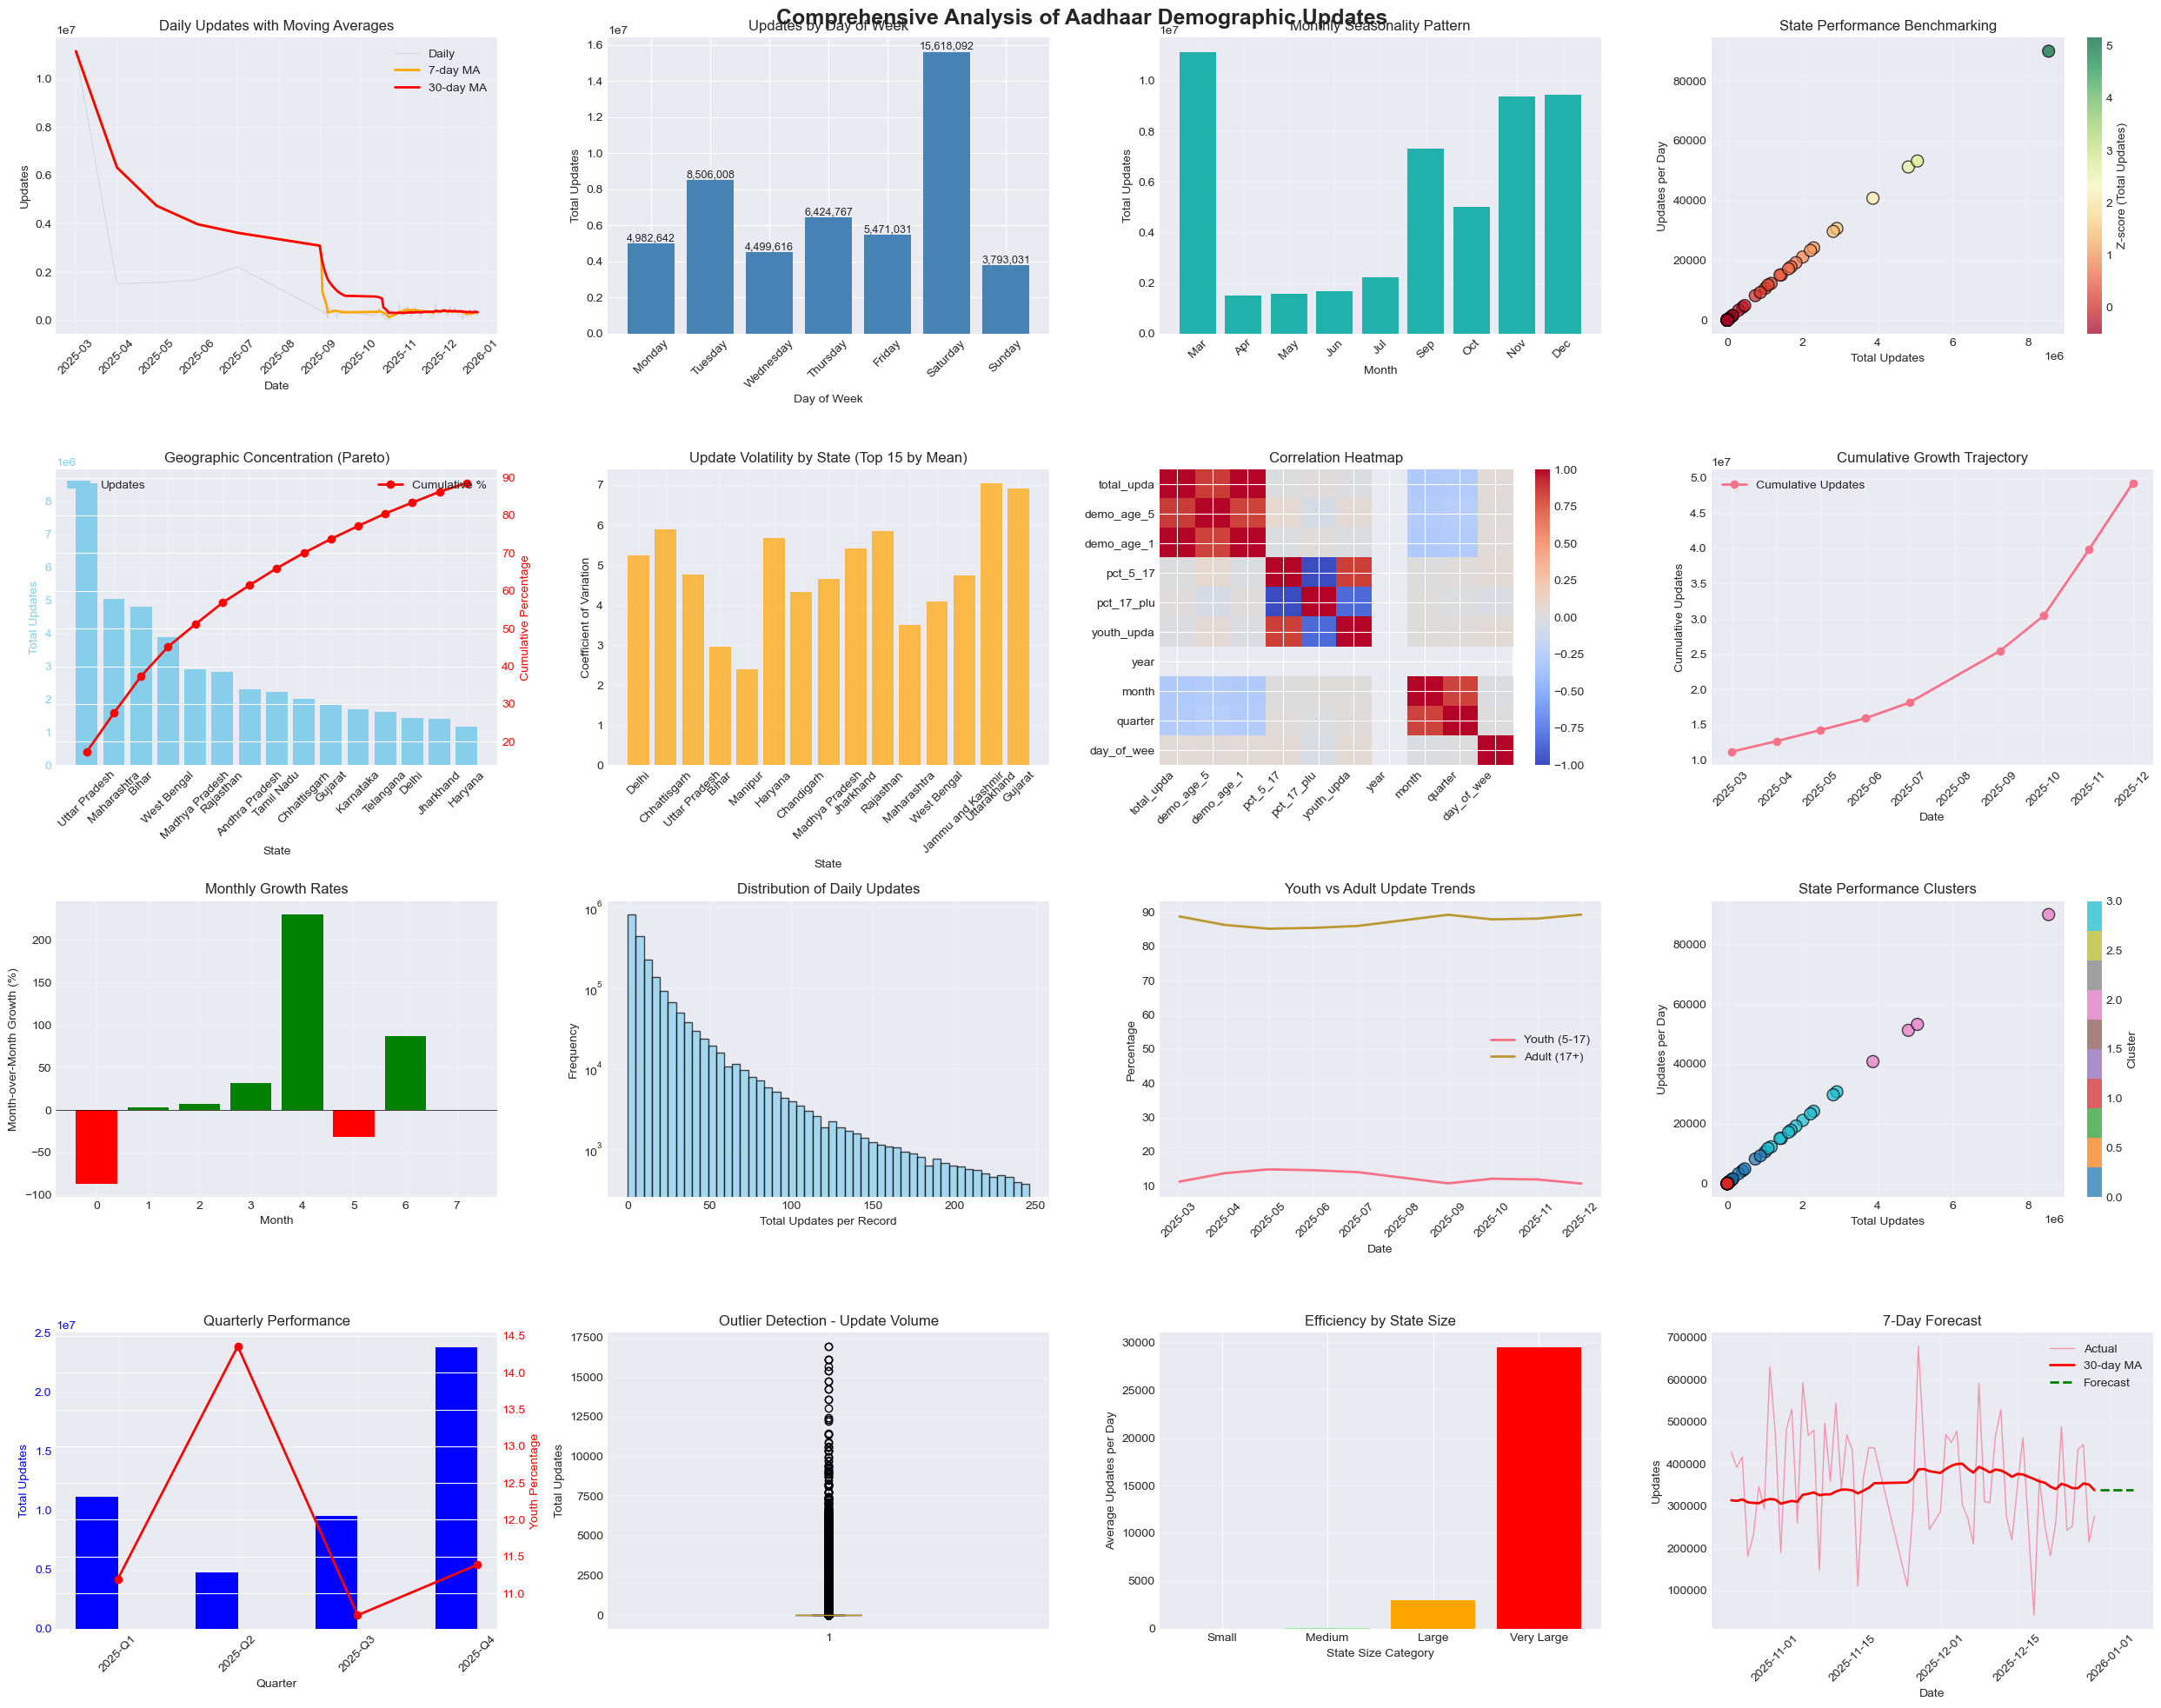

In [494]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(25, 20))
fig.suptitle('Comprehensive Analysis of Aadhaar Demographic Updates', fontsize=18, fontweight='bold')

# Plot 1: Time Series with Moving Averages
ax1 = plt.subplot(4, 4, 1)
ax1.plot(daily_series.index, daily_series['total_updates'], 
         alpha=0.3, label='Daily', linewidth=0.5, color='gray')
ax1.plot(daily_series.index, daily_series['7_day_MA'], 
         label='7-day MA', linewidth=2, color='orange')
ax1.plot(daily_series.index, daily_series['30_day_MA'], 
         label='30-day MA', linewidth=2, color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Updates')
ax1.set_title('Daily Updates with Moving Averages')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Day of Week Analysis
ax2 = plt.subplot(4, 4, 2)
bars = ax2.bar(dow_analysis['day_name'], dow_analysis['total_updates'], 
              color='steelblue')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Total Updates')
ax2.set_title('Updates by Day of Week')
ax2.tick_params(axis='x', rotation=45)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Monthly Seasonality
ax3 = plt.subplot(4, 4, 3)
months = month_seasonality['month_name']
x = np.arange(len(months))
ax3.bar(x, month_seasonality['total_updates_sum'], color='lightseagreen')
ax3.set_xlabel('Month')
ax3.set_ylabel('Total Updates')
ax3.set_title('Monthly Seasonality Pattern')
ax3.set_xticks(x)
ax3.set_xticklabels(months, rotation=45)
ax3.grid(True, alpha=0.3)

# Plot 4: Performance Benchmarking Scatter
ax4 = plt.subplot(4, 4, 4)
scatter = ax4.scatter(state_performance['total_updates'], 
                     state_performance['updates_per_day'],
                     c=state_performance['updates_zscore'], 
                     cmap='RdYlGn', s=100, alpha=0.7, edgecolors='black')
ax4.set_xlabel('Total Updates')
ax4.set_ylabel('Updates per Day')
ax4.set_title('State Performance Benchmarking')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Z-score (Total Updates)')

# Plot 5: Geographic Concentration (Pareto)
ax5 = plt.subplot(4, 4, 5)
states_plot = state_totals.head(15)
x = np.arange(len(states_plot))
ax5.bar(x, states_plot['total_updates'], color='skyblue', label='Updates')
ax5.set_xlabel('State')
ax5.set_ylabel('Total Updates', color='skyblue')
ax5.set_title('Geographic Concentration (Pareto)')
ax5.set_xticks(x)
ax5.set_xticklabels(states_plot['state'], rotation=45)
ax5.tick_params(axis='y', labelcolor='skyblue')
ax5.grid(True, alpha=0.3)

ax5_2 = ax5.twinx()
ax5_2.plot(x, states_plot['cumulative_percentage'], 
          color='red', marker='o', linewidth=2, label='Cumulative %')
ax5_2.set_ylabel('Cumulative Percentage', color='red')
ax5_2.tick_params(axis='y', labelcolor='red')
ax5.legend(loc='upper left')
ax5_2.legend(loc='upper right')

# Plot 6: Volatility Analysis
ax6 = plt.subplot(4, 4, 6)
volatility_plot = state_volatility.nlargest(15, 'mean_updates')
x = np.arange(len(volatility_plot))
bars6 = ax6.bar(x, volatility_plot['cv'], color='orange', alpha=0.7)
ax6.set_xlabel('State')
ax6.set_ylabel('Coefficient of Variation')
ax6.set_title('Update Volatility by State (Top 15 by Mean)')
ax6.set_xticks(x)
ax6.set_xticklabels(volatility_plot['state'], rotation=45)
ax6.grid(True, alpha=0.3)

# Plot 7: Correlation Heatmap
ax7 = plt.subplot(4, 4, 7)
corr_plot = ax7.imshow(corr_data, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax7.set_xticks(range(len(corr_data.columns)))
ax7.set_yticks(range(len(corr_data.columns)))
ax7.set_xticklabels([col[:10] for col in corr_data.columns], rotation=45, ha='right')
ax7.set_yticklabels([col[:10] for col in corr_data.columns])
ax7.set_title('Correlation Heatmap')
plt.colorbar(corr_plot, ax=ax7)

# Plot 8: Growth Trajectory
ax8 = plt.subplot(4, 4, 8)
ax8.plot(monthly_series['period'], monthly_series['cumulative_updates'], 
         marker='o', linewidth=2, label='Cumulative Updates')
ax8.set_xlabel('Date')
ax8.set_ylabel('Cumulative Updates')
ax8.set_title('Cumulative Growth Trajectory')
ax8.legend()
ax8.grid(True, alpha=0.3)
ax8.tick_params(axis='x', rotation=45)

# Plot 9: Monthly Growth Rates
ax9 = plt.subplot(4, 4, 9)
if 'mom_growth' in monthly_series.columns:
    growth_data = monthly_series.dropna(subset=['mom_growth'])
    if len(growth_data) > 0:
        x_growth = np.arange(len(growth_data))
        bars9 = ax9.bar(x_growth, growth_data['mom_growth'], 
                       color=np.where(growth_data['mom_growth'] > 0, 'green', 'red'))
        ax9.set_xlabel('Month')
        ax9.set_ylabel('Month-over-Month Growth (%)')
        ax9.set_title('Monthly Growth Rates')
        ax9.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax9.grid(True, alpha=0.3)
    else:
        ax9.text(0.5, 0.5, 'No growth data available', 
                 ha='center', va='center', transform=ax9.transAxes)
        ax9.set_title('Monthly Growth Rates')
else:
    ax9.text(0.5, 0.5, 'No growth data available', 
             ha='center', va='center', transform=ax9.transAxes)
    ax9.set_title('Monthly Growth Rates')

# Plot 10: Update Distribution Analysis
ax10 = plt.subplot(4, 4, 10)
# Filter extreme values for better visualization
filtered_updates = df['total_updates'][df['total_updates'] <= df['total_updates'].quantile(0.99)]
ax10.hist(filtered_updates, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax10.set_xlabel('Total Updates per Record')
ax10.set_ylabel('Frequency')
ax10.set_title('Distribution of Daily Updates')
ax10.set_yscale('log')  # Log scale for better visualization
ax10.grid(True, alpha=0.3)

# Plot 11: Youth vs Adult Update Patterns
ax11 = plt.subplot(4, 4, 11)
monthly_youth = monthly_series.set_index('period')[['pct_5_17', 'pct_17_plus']]
ax11.plot(monthly_youth.index, monthly_youth['pct_5_17'], label='Youth (5-17)', linewidth=2)
ax11.plot(monthly_youth.index, monthly_youth['pct_17_plus'], label='Adult (17+)', linewidth=2)
ax11.set_xlabel('Date')
ax11.set_ylabel('Percentage')
ax11.set_title('Youth vs Adult Update Trends')
ax11.legend()
ax11.grid(True, alpha=0.3)
ax11.tick_params(axis='x', rotation=45)

# Plot 12: Performance Clusters Visualization
ax12 = plt.subplot(4, 4, 12)
if 'cluster' in state_performance.columns:
    scatter_cluster = ax12.scatter(state_performance['total_updates'], 
                                 state_performance['updates_per_day'],
                                 c=state_performance['cluster'], 
                                 cmap='tab10', s=100, alpha=0.7, edgecolors='black')
    ax12.set_xlabel('Total Updates')
    ax12.set_ylabel('Updates per Day')
    ax12.set_title('State Performance Clusters')
    ax12.grid(True, alpha=0.3)
    plt.colorbar(scatter_cluster, ax=ax12, label='Cluster')
else:
    ax12.text(0.5, 0.5, 'Clustering not available', 
             ha='center', va='center', transform=ax12.transAxes)
    ax12.set_title('Performance Clusters')

# Plot 13: Quarterly Performance Comparison
ax13 = plt.subplot(4, 4, 13)
quarterly_perf = df.groupby(['year', 'quarter']).agg({
    'total_updates': 'sum',
    'pct_5_17': 'mean'
}).reset_index()
quarterly_perf['period'] = quarterly_perf['year'].astype(str) + '-Q' + quarterly_perf['quarter'].astype(str)
x_q = np.arange(len(quarterly_perf))
width = 0.35
bars13a = ax13.bar(x_q - width/2, quarterly_perf['total_updates'], width, label='Updates', color='blue')
ax13.set_xlabel('Quarter')
ax13.set_ylabel('Total Updates', color='blue')
ax13.set_title('Quarterly Performance')
ax13.set_xticks(x_q)
ax13.set_xticklabels(quarterly_perf['period'], rotation=45)
ax13.tick_params(axis='y', labelcolor='blue')
ax13.grid(True, alpha=0.3)

ax13_2 = ax13.twinx()
ax13_2.plot(x_q, quarterly_perf['pct_5_17'], color='red', marker='o', linewidth=2, label='Youth %')
ax13_2.set_ylabel('Youth Percentage', color='red')
ax13_2.tick_params(axis='y', labelcolor='red')

# Plot 14: Outlier Detection Visualization
ax14 = plt.subplot(4, 4, 14)
if 'total_updates' in df.columns:
    # Box plot for outlier visualization
    bp = ax14.boxplot(df['total_updates'].dropna(), vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    ax14.set_ylabel('Total Updates')
    ax14.set_title('Outlier Detection - Update Volume')
    ax14.grid(True, alpha=0.3)
else:
    ax14.text(0.5, 0.5, 'Data not available', 
             ha='center', va='center', transform=ax14.transAxes)
    ax14.set_title('Outlier Detection')

# Plot 15: Update Efficiency by State Size
ax15 = plt.subplot(4, 4, 15)
# Calculate state size based on total updates
state_performance['size_category'] = pd.qcut(state_performance['total_updates'], 
                                            q=4, 
                                            labels=['Small', 'Medium', 'Large', 'Very Large'])

size_efficiency = state_performance.groupby('size_category')['updates_per_day'].mean()
colors_size = ['lightblue', 'lightgreen', 'orange', 'red']
bars15 = ax15.bar(size_efficiency.index, size_efficiency.values, color=colors_size)
ax15.set_xlabel('State Size Category')
ax15.set_ylabel('Average Updates per Day')
ax15.set_title('Efficiency by State Size')
ax15.grid(True, alpha=0.3, axis='y')

# Plot 16: Forecasting Visualization
ax16 = plt.subplot(4, 4, 16)
if len(daily_series) > 30:
    # Plot last 60 days and forecast
    last_60_days = daily_series.tail(60)
    ax16.plot(last_60_days.index, last_60_days['total_updates'], 
             label='Actual', alpha=0.7, linewidth=1)
    ax16.plot(last_60_days.index, last_60_days['30_day_MA'], 
             label='30-day MA', linewidth=2, color='red')
    
    # Add forecast line (simple projection)
    forecast_dates = pd.date_range(start=last_60_days.index[-1] + pd.Timedelta(days=1), periods=7)
    forecast_values = [last_30_day_avg] * 7
    ax16.plot(forecast_dates, forecast_values, '--', label='Forecast', linewidth=2, color='green')
    
    ax16.set_xlabel('Date')
    ax16.set_ylabel('Updates')
    ax16.set_title('7-Day Forecast')
    ax16.legend()
    ax16.grid(True, alpha=0.3)
    ax16.tick_params(axis='x', rotation=45)
else:
    ax16.text(0.5, 0.5, 'Insufficient data for forecasting', 
             ha='center', va='center', transform=ax16.transAxes)
    ax16.set_title('Forecasting')

plt.tight_layout()
plt.show()

#### 4.5.12 [ KEY INSIGHTS AND RECOMMENDATIONS ]

In [497]:
print("\n" + "="*100)
print("12. KEY INSIGHTS AND RECOMMENDATIONS")
print("="*100)

print("\nA. TEMPORAL INSIGHTS:")
print("1. Peak update days: ", end="")
top_days = dow_analysis.nlargest(2, 'total_updates')['day_name'].tolist()
print(f"{', '.join(top_days)}")

print("2. High season months: ", end="")
top_months = month_seasonality.nlargest(3, 'total_updates_sum')['month_name'].tolist()
print(f"{', '.join(top_months)}")

print("\nB. PERFORMANCE INSIGHTS:")
print("1. Top performing state: ", end="")
top_state = state_performance.nlargest(1, 'total_updates').iloc[0]
print(f"{top_state['state']} ({top_state['total_updates']:,} updates)")

print("2. Most efficient state: ", end="")
eff_state = state_performance.nlargest(1, 'updates_per_day').iloc[0]
print(f"{eff_state['state']} ({eff_state['updates_per_day']:.1f} updates/day)")

print("\nC. GEOGRAPHIC INSIGHTS:")
print(f"1. Market concentration: {'High' if hhi >= 2500 else 'Moderate' if hhi >= 1500 else 'Low'}")
print(f"2. States driving 80% of updates: {len(states_80_percent)}")

print("\nD. VOLATILITY INSIGHTS:")
if len(low_volatility) > 0:
    print(f"1. Most consistent state: {low_volatility.iloc[0]['state']} (CV: {low_volatility.iloc[0]['cv']:.2f})")

print("\nE. GROWTH INSIGHTS:")
if 'mom_growth' in monthly_series.columns:
    avg_growth = monthly_series['mom_growth'].mean()
    print(f"1. Average monthly growth rate: {avg_growth:.1f}%")

print("\nF. STRATEGIC RECOMMENDATIONS:")
print("1. Timing optimization: Schedule campaigns during peak update periods")
print("2. Resource allocation: Focus on high-performing states/districts")
print("3. Consistency improvement: Study low-volatility states' practices")
print("4. Geographic expansion: Address gaps in low-performing regions")
print("5. Forecasting: Use moving averages for capacity planning")
print("6. Monitoring: Track key metrics and set up alerts for anomalies")


12. KEY INSIGHTS AND RECOMMENDATIONS

A. TEMPORAL INSIGHTS:
1. Peak update days: Saturday, Tuesday
2. High season months: Mar, Dec, Nov

B. PERFORMANCE INSIGHTS:
1. Top performing state: Uttar Pradesh (8,542,328 updates)
2. Most efficient state: Uttar Pradesh (89919.2 updates/day)

C. GEOGRAPHIC INSIGHTS:
1. Market concentration: Low
2. States driving 80% of updates: 11

D. VOLATILITY INSIGHTS:
1. Most consistent state: 100000 (CV: 0.00)

E. GROWTH INSIGHTS:
1. Average monthly growth rate: 30.3%

F. STRATEGIC RECOMMENDATIONS:
1. Timing optimization: Schedule campaigns during peak update periods
2. Resource allocation: Focus on high-performing states/districts
3. Consistency improvement: Study low-volatility states' practices
4. Geographic expansion: Address gaps in low-performing regions
5. Forecasting: Use moving averages for capacity planning
6. Monitoring: Track key metrics and set up alerts for anomalies


#### 4.5.13 [ EXPORT KEY METRICS ]

In [500]:
# Create summary metrics for export
summary_metrics = {
    'Total Records': len(df),
    'Total Updates': df['total_updates'].sum(),
    'Youth (5-17) Updates': df['demo_age_5_17'].sum(),
    'Adult (17+) Updates': df['demo_age_17_'].sum(),
    'Youth Percentage': f"{(df['demo_age_5_17'].sum()/df['total_updates'].sum()*100):.1f}%",
    'Total States': df['state'].nunique(),
    'Total Districts': df['district'].nunique(),
    'Average Daily Updates': df['total_updates'].mean(),
    'Youth-Adult Ratio': df['youth_update_ratio'].mean(),
    'Geographic Concentration (HHI)': f"{hhi:.2f}",
    'Days of Data': df['date'].nunique(),
    'Time Period': f"{df['date'].min().date()} to {df['date'].max().date()}",
    'Top State': top_state['state'],
    'Top State Share': f"{(top_state['total_updates']/df['total_updates'].sum()*100):.1f}%"
}

print("\n" + "="*100)
print("KEY SUMMARY METRICS")
print("="*100)
for key, value in summary_metrics.items():
    print(f"{key}: {value}")

# Create final summary DataFrame
final_summary = pd.DataFrame({
    'Metric': list(summary_metrics.keys()),
    'Value': list(summary_metrics.values())
})

print("\nAnalysis complete! All visualizations displayed and insights generated.")
print("="*100)


KEY SUMMARY METRICS
Total Records: 2071700
Total Updates: 49295187
Youth (5-17) Updates: 4863424
Adult (17+) Updates: 44431763
Youth Percentage: 9.9%
Total States: 65
Total Districts: 983
Average Daily Updates: 23.794558575083265
Youth-Adult Ratio: 0.16600216032941248
Geographic Concentration (HHI): 763.86
Days of Data: 95
Time Period: 2025-03-01 to 2025-12-29
Top State: Uttar Pradesh
Top State Share: 17.3%

Analysis complete! All visualizations displayed and insights generated.


## 5. Persistence: Identifying Chronic vs Acute Data Quality Issues
Demographic update patterns reveal data quality maturity:
- **Chronic issues**: Consistently high updates indicate systemic data problems
- **Acute spikes**: Seasonal/event-driven updates (marriage season, academic transitions)
- **Stable regions**: Low, consistent updates indicate mature, accurate data

**Methodology:**
1. Flag months where updates > national median
2. Count consecutive high-months per district
3. Classify districts by data quality maturity

🔍 DATA QUALITY MATURITY ANALYSIS:
National median (district-month): 4,212 updates
Total months analyzed: 9

📈 Data Maturity Classification:
data_maturity
Stable Data Quality          444
Inconsistent Data Quality    293
Seasonal/Event Driven        228
Chronic Data Issues          113
Name: count, dtype: int64

📊 Percentage with chronic data issues: 10.5%

⚠️  TOP 10 DISTRICTS WITH CHRONIC DATA QUALITY ISSUES:


,state,district,high_months_count,data_maturity
1062,West Bengal,Uttar Dinajpur,9,Chronic Data Issues
766,Rajasthan,Jaipur,9,Chronic Data Issues
222,Delhi,North West Delhi,9,Chronic Data Issues
224,Delhi,South Delhi,9,Chronic Data Issues
226,Delhi,South West Delhi,9,Chronic Data Issues
234,Gujarat,Ahmedabad,9,Chronic Data Issues
847,Telangana,Hyderabad,9,Chronic Data Issues
262,Gujarat,Rajkot,9,Chronic Data Issues
265,Gujarat,Surat,9,Chronic Data Issues
275,Haryana,Faridabad,9,Chronic Data Issues


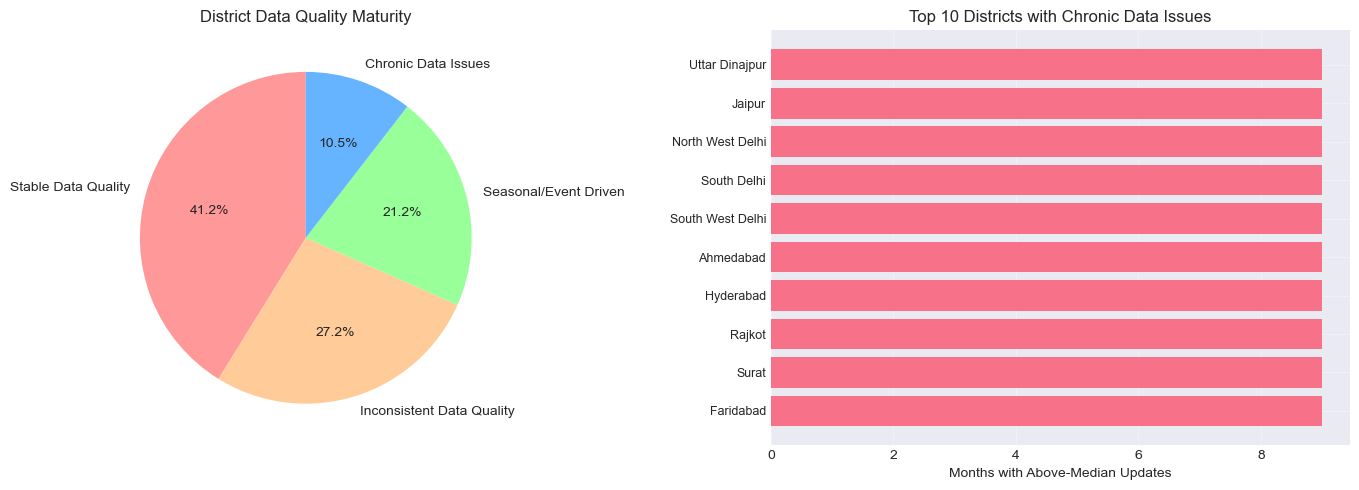

In [515]:
# Calculate national median
national_median = district_month['total_updates'].median()

# Flag months above median
district_month['above_median'] = district_month['total_updates'] > national_median

# Count high-months per district
persistence = district_month.groupby(['state', 'district'])['above_median'].sum().reset_index()
persistence.columns = ['state', 'district', 'high_months_count']

# Classify districts by data quality maturity
def classify_data_maturity(count, total_months):
    if count >= total_months * 0.75:  # High in ≥75% of months
        return 'Chronic Data Issues'
    elif count >= total_months * 0.5:  # High in ≥50% of months
        return 'Inconsistent Data Quality'
    elif count >= 1:
        return 'Seasonal/Event Driven'
    else:
        return 'Stable Data Quality'

# Assuming 3 months of data
total_months = district_month['month'].nunique()
persistence['data_maturity'] = persistence['high_months_count'].apply(
    lambda x: classify_data_maturity(x, total_months)
)

# Distribution of data maturity categories
maturity_dist = persistence['data_maturity'].value_counts()

print("🔍 DATA QUALITY MATURITY ANALYSIS:")
print("=" * 50)
print(f"National median (district-month): {national_median:,.0f} updates")
print(f"Total months analyzed: {total_months}")
print("\n📈 Data Maturity Classification:")
print(maturity_dist)
print(f"\n📊 Percentage with chronic data issues: {maturity_dist['Chronic Data Issues']/len(persistence)*100:.1f}%")

# Display districts with chronic data issues
chronic_issues = persistence[persistence['data_maturity'] == 'Chronic Data Issues'].sort_values(
    'high_months_count', ascending=False)

print("\n⚠️  TOP 10 DISTRICTS WITH CHRONIC DATA QUALITY ISSUES:")
display(chronic_issues.head(10))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of data maturity
colors = ['#ff9999', '#ffcc99', '#99ff99', '#66b3ff']
ax1.pie(maturity_dist.values, labels=maturity_dist.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax1.set_title('District Data Quality Maturity')

# Top chronic issue districts
top_chronic = chronic_issues.head(10)
ax2.barh(range(len(top_chronic)), top_chronic['high_months_count'])
ax2.set_yticks(range(len(top_chronic)))
ax2.set_yticklabels(top_chronic['district'], fontsize=9)
ax2.set_xlabel('Months with Above-Median Updates')
ax2.set_title('Top 10 Districts with Chronic Data Issues')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data_maturity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Correlation Analysis

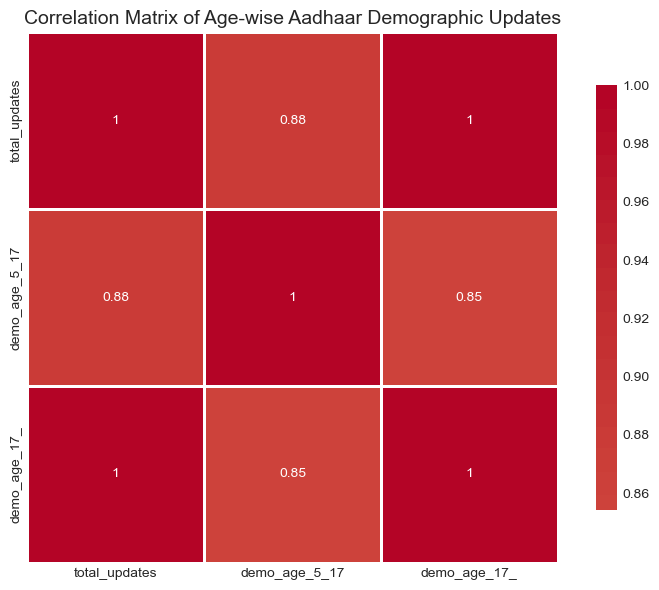

In [521]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select meaningful variables only
correlation_cols = [
    'total_updates',
    'demo_age_5_17',
    'demo_age_17_'
]

# Compute correlation matrix
correlation_matrix = df[correlation_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Matrix of Age-wise Aadhaar Demographic Updates', fontsize=14)
plt.tight_layout()
plt.show()

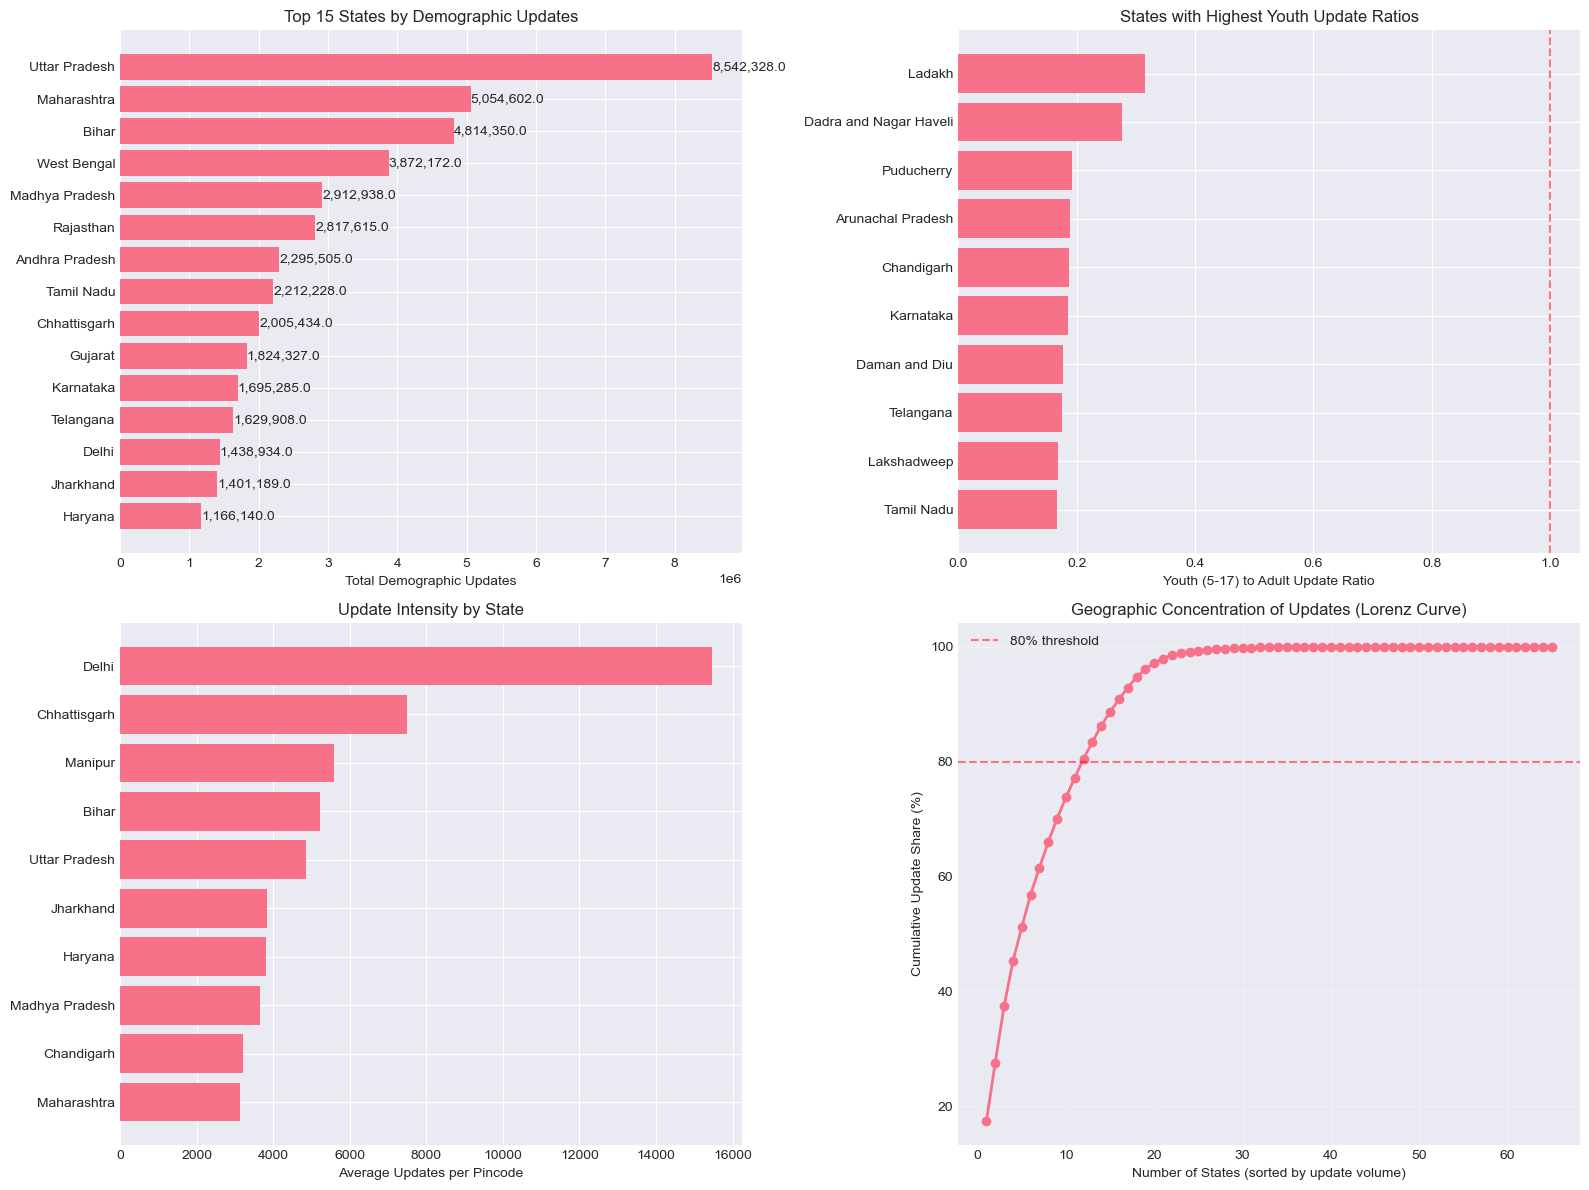


Geographic Concentration Metrics:
Gini Coefficient: -0.796 (Moderate inequality)
Top 3 States Share: 37.3%
HHI Index: 764 (Moderately concentrated)


In [83]:
# State-wise analysis
state_demo_analysis = df.groupby('state').agg({
    'total_updates': 'sum',
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'pincode': 'nunique',
    'district': 'nunique'
}).sort_values('total_updates', ascending=False)

state_demo_analysis['avg_updates_per_pincode'] = state_demo_analysis['total_updates'] / state_demo_analysis['pincode']
state_demo_analysis['youth_update_ratio'] = state_demo_analysis['demo_age_5_17'] / state_demo_analysis['demo_age_17_']
state_demo_analysis['pct_total_updates'] = (state_demo_analysis['total_updates'] / 
                                           state_demo_analysis['total_updates'].sum()) * 100

# Plot geographic distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top 15 states by updates
top_states = state_demo_analysis.head(15)
axes[0, 0].barh(top_states.index, top_states['total_updates'])
axes[0, 0].set_xlabel('Total Demographic Updates')
axes[0, 0].set_title('Top 15 States by Demographic Updates')
axes[0, 0].invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_states.iterrows()):
    axes[0, 0].text(row['total_updates'], i, 
                   f'{row["total_updates"]:,}', 
                   ha='left', va='center')

# Plot 2: Youth update ratio across states
states_for_ratio = state_demo_analysis[state_demo_analysis['demo_age_17_'] > 1000]  # Filter for meaningful ratio
states_for_ratio = states_for_ratio.sort_values('youth_update_ratio', ascending=False).head(10)
axes[0, 1].barh(states_for_ratio.index, states_for_ratio['youth_update_ratio'])
axes[0, 1].set_xlabel('Youth (5-17) to Adult Update Ratio')
axes[0, 1].set_title('States with Highest Youth Update Ratios')
axes[0, 1].axvline(x=1, color='r', linestyle='--', alpha=0.5)
axes[0, 1].invert_yaxis()

# Plot 3: Update intensity (updates per pincode)
update_intensity = state_demo_analysis.sort_values('avg_updates_per_pincode', ascending=False).head(10)
axes[1, 0].barh(update_intensity.index, update_intensity['avg_updates_per_pincode'])
axes[1, 0].set_xlabel('Average Updates per Pincode')
axes[1, 0].set_title('Update Intensity by State')
axes[1, 0].invert_yaxis()

# Plot 4: Geographic concentration analysis
state_update_share = state_demo_analysis['pct_total_updates'].sort_values(ascending=False)
cumulative_share = state_update_share.cumsum()

axes[1, 1].plot(range(1, len(cumulative_share) + 1), cumulative_share.values, 
                marker='o', linewidth=2)
axes[1, 1].axhline(y=80, color='r', linestyle='--', alpha=0.5, label='80% threshold')
axes[1, 1].set_xlabel('Number of States (sorted by update volume)')
axes[1, 1].set_ylabel('Cumulative Update Share (%)')
axes[1, 1].set_title('Geographic Concentration of Updates (Lorenz Curve)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate geographic concentration metrics
def calculate_concentration_metrics(series):
    """Calculate concentration metrics"""
    sorted_series = series.sort_values(ascending=False)
    
    # Gini coefficient approximation
    n = len(sorted_series)
    cum_values = sorted_series.cumsum().values
    gini = (n + 1 - 2 * np.sum(cum_values) / cum_values[-1]) / n
    
    # Top 3 states share
    top3_share = sorted_series.head(3).sum() / sorted_series.sum()
    
    # Herfindahl-Hirschman Index
    hhi = ((sorted_series / sorted_series.sum()) ** 2).sum() * 10000
    
    return gini, top3_share, hhi

gini_coefficient, top3_share, hhi_index = calculate_concentration_metrics(state_demo_analysis['total_updates'])
print(f"\nGeographic Concentration Metrics:")
print(f"Gini Coefficient: {gini_coefficient:.3f} {'(High inequality)' if gini_coefficient > 0.4 else '(Moderate inequality)'}")
print(f"Top 3 States Share: {top3_share:.1%}")
print(f"HHI Index: {hhi_index:.0f} {'(Highly concentrated)' if hhi_index > 2500 else '(Moderately concentrated)'}")

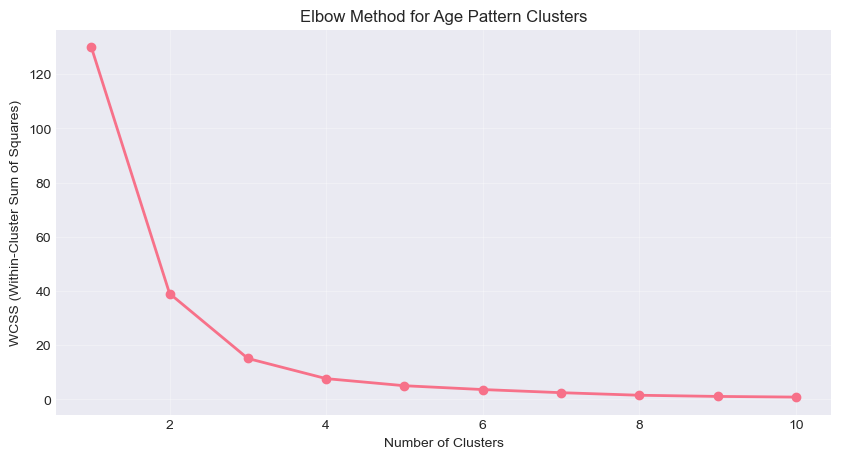

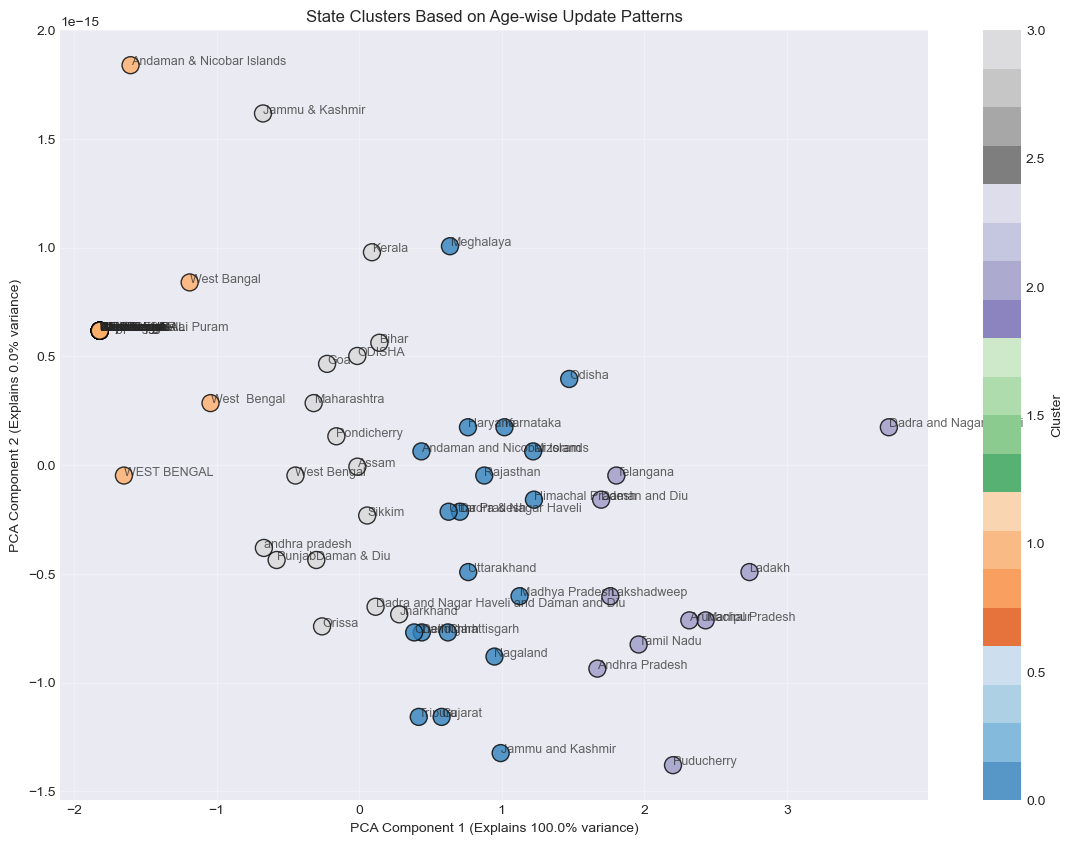


Cluster Characteristics:
            pct_5_17       pct_17_plus       youth_update_ratio       
                mean   std        mean   std               mean median
age_cluster                                                           
0              11.46  1.37       88.54  1.37               0.04   0.00
1               0.39  0.96       99.61  0.96               0.00   0.00
2              17.70  2.76       82.30  2.76               0.07   0.06
3               7.14  1.31       92.86  1.31               0.01   0.00

Cluster 0: Adult-Dominated Update Pattern
Average Youth Update %: 11.5%
Representative States: Odisha, Himachal Pradesh, Mizoram, Madhya Pradesh, Karnataka

Cluster 1: Adult-Dominated Update Pattern
Average Youth Update %: 0.4%
Representative States: West  Bengal, West Bangal, Andaman & Nicobar Islands, WEST BENGAL, West Bengli

Cluster 2: Adult-Dominated Update Pattern
Average Youth Update %: 17.7%
Representative States: Dadra and Nagar Haveli, Ladakh, Manipur, Arunachal

In [15]:
# Analyze age-based update patterns
age_pattern_analysis = df.groupby('state').agg({
    'pct_5_17': 'mean',
    'pct_17_plus': 'mean',
    'youth_update_ratio': 'median'
}).sort_values('pct_5_17', ascending=False)

# Cluster analysis based on update patterns
X_age_patterns = age_pattern_analysis[['pct_5_17', 'pct_17_plus']]

# Standardize data
scaler_age = StandardScaler()
X_age_scaled = scaler_age.fit_transform(X_age_patterns)

# Determine optimal clusters using elbow method
wcss_age = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_age_scaled)
    wcss_age.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss_age, marker='o', linewidth=2)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Age Pattern Clusters')
plt.grid(True, alpha=0.3)
plt.show()

# Apply clustering
optimal_clusters_age = 4
kmeans_age = KMeans(n_clusters=optimal_clusters_age, random_state=42, n_init=10)
age_pattern_analysis['age_cluster'] = kmeans_age.fit_predict(X_age_scaled)

# Visualize clusters using PCA
pca_age = PCA(n_components=2)
pca_result_age = pca_age.fit_transform(X_age_scaled)

plt.figure(figsize=(14, 10))
scatter = plt.scatter(pca_result_age[:, 0], pca_result_age[:, 1], 
                     c=age_pattern_analysis['age_cluster'], 
                     cmap='tab20c', s=150, alpha=0.8, edgecolors='black')

# Add state labels
for i, state in enumerate(age_pattern_analysis.index):
    plt.annotate(state, (pca_result_age[i, 0], pca_result_age[i, 1]), 
                fontsize=9, alpha=0.7)

plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Component 1 (Explains {:.1f}% variance)'.format(pca_age.explained_variance_ratio_[0]*100))
plt.ylabel('PCA Component 2 (Explains {:.1f}% variance)'.format(pca_age.explained_variance_ratio_[1]*100))
plt.title('State Clusters Based on Age-wise Update Patterns')
plt.grid(True, alpha=0.3)
plt.show()

# Analyze cluster characteristics
cluster_characteristics = age_pattern_analysis.groupby('age_cluster').agg({
    'pct_5_17': ['mean', 'std'],
    'pct_17_plus': ['mean', 'std'],
    'youth_update_ratio': ['mean', 'median']
}).round(2)

print("\nCluster Characteristics:")
print(cluster_characteristics)

# Create cluster profiles
cluster_profiles = {}
for cluster_id in sorted(age_pattern_analysis['age_cluster'].unique()):
    cluster_states = age_pattern_analysis[age_pattern_analysis['age_cluster'] == cluster_id].index.tolist()
    avg_youth_pct = age_pattern_analysis.loc[age_pattern_analysis['age_cluster'] == cluster_id, 'pct_5_17'].mean()
    
    if avg_youth_pct > 50:
        profile = "Youth-Dominated Update Pattern"
    elif avg_youth_pct > 30:
        profile = "Balanced Youth-Adult Update Pattern"
    else:
        profile = "Adult-Dominated Update Pattern"
    
    cluster_profiles[cluster_id] = {
        'profile': profile,
        'states': cluster_states[:5],  # Show top 5 states
        'avg_youth_pct': avg_youth_pct
    }
    
    print(f"\nCluster {cluster_id}: {profile}")
    print(f"Average Youth Update %: {avg_youth_pct:.1f}%")
    print(f"Representative States: {', '.join(cluster_states[:5])}")

## 8. Anomaly detection using Z-score

Total anomalies in update volume: 215075
Youth update anomalies: 147428
Anomaly rate: 10.38%

Top 10 anomalous records:
        date           state           district  total_updates  demo_age_5_17  \
0 2025-03-01   Uttar Pradesh          Gorakhpur            578             49   
1 2025-03-01  Andhra Pradesh           Chittoor            397             22   
2 2025-03-01         Gujarat             Rajkot            830             65   
3 2025-03-01  Andhra Pradesh         Srikakulam            338             24   
4 2025-03-01       Rajasthan            Udaipur            830             45   
5 2025-03-01       Rajasthan              Sikar            313             28   
6 2025-03-01       Karnataka           Tumakuru            420             88   
7 2025-03-01   Uttar Pradesh          Gorakhpur            897             61   
8 2025-03-01  Andhra Pradesh            Kurnool           1069             83   
9 2025-03-01     West Bengal  Paschim Medinipur            294        

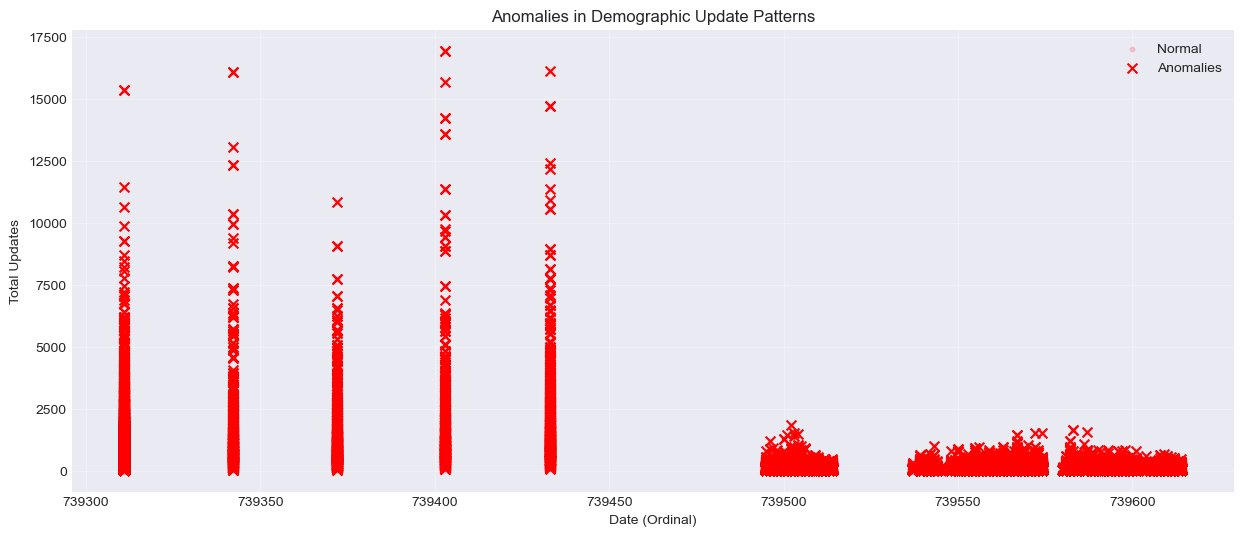

In [524]:
# Statistical anomaly detection
def detect_update_anomalies(data, method='iqr', threshold=1.5):
    """Detect anomalies using different methods"""
    if method == 'iqr':
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        anomalies = np.where((data < lower_bound) | (data > upper_bound))[0]
    elif method == 'zscore':
        z_scores = np.abs((data - np.mean(data)) / np.std(data))
        anomalies = np.where(z_scores > 3)[0]
    return anomalies

# Detect anomalies in update patterns
total_update_anomalies = detect_update_anomalies(df['total_updates'].values, method='iqr')
youth_update_anomalies = detect_update_anomalies(df['demo_age_5_17'].values, method='iqr')

print(f"Total anomalies in update volume: {len(total_update_anomalies)}")
print(f"Youth update anomalies: {len(youth_update_anomalies)}")
print(f"Anomaly rate: {(len(total_update_anomalies)/len(df))*100:.2f}%")

if len(total_update_anomalies) > 0:
    anomalous_data = df.iloc[total_update_anomalies]
    print("\nTop 10 anomalous records:")
    print(anomalous_data[['date', 'state', 'district', 'total_updates', 
                         'demo_age_5_17', 'demo_age_17_']].head(10))

# Time-series anomaly detection
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())
state_time_series = df.groupby(['state', 'date'])['total_updates'].sum().unstack(level=0)

# Detect sudden spikes/drops for each state
state_anomalies = {}
for state in state_time_series.columns:
    state_data = state_time_series[state].dropna()
    if len(state_data) > 10:  # Only analyze states with sufficient data
        rolling_mean = state_data.rolling(window=7, min_periods=3).mean()
        rolling_std = state_data.rolling(window=7, min_periods=3).std()
        anomalies = state_data[(state_data > rolling_mean + 3*rolling_std) | 
                              (state_data < rolling_mean - 3*rolling_std)]
        if len(anomalies) > 0:
            state_anomalies[state] = anomalies

print(f"\nStates with time-series anomalies: {len(state_anomalies)}")
for state, anomalies in list(state_anomalies.items())[:5]:  # Show first 5
    print(f"{state}: {len(anomalies)} anomalous days")

# Visualize anomalies
plt.figure(figsize=(15, 6))
plt.scatter(df['date_ordinal'], df['total_updates'], 
           alpha=0.3, s=10, label='Normal')
plt.scatter(df.iloc[total_update_anomalies]['date_ordinal'],
           df.iloc[total_update_anomalies]['total_updates'],
           color='red', s=50, label='Anomalies', marker='x')
plt.xlabel('Date (Ordinal)')
plt.ylabel('Total Updates')
plt.title('Anomalies in Demographic Update Patterns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Predictive Models

In [ ]:
from sklearn import set_config
set_config(display='diagram')

#### 9.1.1 Custom Date Feature Transformer

In [530]:
from sklearn.base import BaseEstimator, TransformerMixin

class DateFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['day_of_week'] = X['date'].dt.dayofweek
        X['day_of_month'] = X['date'].dt.day
        X['month'] = X['date'].dt.month
        X['quarter'] = X['date'].dt.quarter
        X['year'] = X['date'].dt.year
        X['is_weekend'] = (X['day_of_week'] >= 5).astype(int)
        return X

#### 9.1.2 Column Transformer (Encoding)

In [533]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

categorical_features = ['state', 'district', 'pincode']
numeric_features = [
    'day_of_week', 'day_of_month',
    'month', 'quarter', 'year', 'is_weekend'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

#### 9.1.3 Full Pipeline Model

In [536]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

demo_update_pipeline = Pipeline(steps=[
    ('date_features', DateFeatureEngineer()),
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=18,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

#### 9.1.4 Training the Model

In [ ]:
X = df[['date', 'state', 'district', 'pincode']]
y = df['total_updates']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

demo_update_pipeline.fit(X_train, y_train)

#### 9.1.5 Prediction (Future Demand)

In [ ]:
future_data = pd.DataFrame({
    'date': [pd.to_datetime('2026-04-01')],
    'state': ['Bihar'],
    'district': ['Gaya'],
    'pincode': ['823001']
})

prediction = demo_update_pipeline.predict(future_data)

print(f"Predicted demographic updates: {int(prediction[0])}")

#### 9.1.6 Quarter-over-Quarter Growth (Policy Insight)

In [ ]:
current_q = demo_update_pipeline.predict(current_q_df).sum()
next_q = demo_update_pipeline.predict(next_q_df).sum()

growth_pct = ((next_q - current_q) / current_q) * 100

#### 9.1.7 Age-Group Driver Analysis (Explainability)

In [ ]:
df['age_17_share'] = df['demo_age_17_'] / df['total_demo_updates']

#### 9.1.8 Feature Importance (Explainable AI)

In [ ]:
feature_names = (
    categorical_features +
    numeric_features
)

importances = demo_update_pipeline.named_steps['model'].feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df.head(10))